# LoanTap - Predicting Credit line extension and providing Business recommendations for Repayment Terms

# Context:

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of Micro, Small and Medium Enterprises (MSMEs) as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan

**This case study will focus on the underwriting process behind Personal Loan only**

# Problem Statement:

Given a set of attributes for an Individual, our goal is twofold:

1. **Credit Line Decision**: 
    - Determine if a credit line should be extended to an individual or not.
    - This decision balances the risk (avoiding default) and opportunity (earning interest).
2. **Repayment Terms**:
    - If the credit line is approved, recommend suitable repayment terms in the business recommendations.
    - These terms include loan tenure, interest rate and installment amount.

# Data dictionary:

**loan_amnt :** The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**term :** The number of payments on the loan. Values are in months and can be either 36 or 60.

**int_rate :** Interest Rate on the loan

**installment :** The monthly payment owed by the borrower if the loan originates.

**grade :** LoanTap assigned loan grade

**sub_grade :** LoanTap assigned loan subgrade

**emp_title :** The job title supplied by the Borrower when applying for the loan.*

**emp_length :** Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

**home_ownership :** The home ownership status provided by the borrower during registration or obtained from the credit report.

**annual_inc :** The self-reported annual income provided by the borrower during registration.

**verification_status :** Indicates if income was verified by LoanTap, not verified, or if the income source was verified

**issue_d :** The month which the loan was funded

**loan_status :** Current status of the loan - Target Variable

**purpose :** A category provided by the borrower for the loan request.

**title :** The loan title provided by the borrower

**dti :** A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.

**earliest_cr_line :** The month the borrower's earliest reported credit line was opened

**open_acc :** The number of open credit lines in the borrower's credit file.

**pub_rec :** Number of derogatory public records

**revol_bal :** Total credit revolving balance

**revol_util :** Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

**total_acc :** The total number of credit lines currently in the borrower's credit file

**initial_list_status :** The initial listing status of the loan. Possible values are – W, F

**application_type :** Indicates whether the loan is an individual application or a joint application with two co-borrowers

**mort_acc :** Number of mortgage accounts.

**pub_rec_bankruptcies :** Number of public record bankruptcies

**Address:** Address of the individual

# Concepts Used:

1. Exploratory Data Analysis
2. Feature Engineering
3. Logistic Regression
4. Precision Vs Recall Tradeoff

In [1]:
#!pip3 install missingno
#!pip install git+https://github.com/ResidentMario/missingno.git

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, TargetEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
import warnings

warnings.filterwarnings('ignore') 

In [4]:
orig_data = pd.read_csv("logistic_regression.csv")

#taking a copy to do analysis and preprocessing
data = orig_data.copy()
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


Observations:
1. The address feature contains the address, state code and zip code. These can be extracted.
2. The issue_d and earliest_cr_line contains year and month. These can be extracted.
3. The terms and emp_length contains unwanted texts. These needs to be cleaned.

##### Data Cleaning

In [5]:
#Extracting zip code and state from the address feature
def get_zip(x):
    #Extracts the zipcode from the address feature
    return x.split(' ')[-1]
def get_state(x):
    #Extracts the state-code from the address feature
    return x.split(',')[-1].strip().split(' ')[0]

#extracting month and year data
def get_month(x):
    return x.split('-')[0]
def get_year(x):
    return x.split('-')[1]

#extracting information from address feature
data['address'] = data['address'].str.strip()
data['zip_code'] = data['address'].apply(get_zip)
data['state_code'] = data['address'].apply(get_state)

#extracting month and year
data['issue_d_month'] = data['issue_d'].apply(get_month)
data['issue_d_year'] = data['issue_d'].apply(get_year)
data['earliest_cr_line_month'] = data['earliest_cr_line'].apply(get_month)
data['earliest_cr_line_year'] = data['earliest_cr_line'].apply(get_year)

#removing text from term and emp_length features
data['term'] = data['term'].str.strip().str.extract('(\d+)')
data['emp_length'] = data['emp_length'].str.strip().str.replace(' years','').str.replace(' year','')


In [6]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,application_type,mort_acc,pub_rec_bankruptcies,address,zip_code,state_code,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year
0,10000.0,36,11.44,329.48,B,B4,Marketing,10+,RENT,117000.0,...,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",22690,OK,Jan,2015,Jun,1990
1,8000.0,36,11.99,265.68,B,B5,Credit analyst,4,MORTGAGE,65000.0,...,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",05113,SD,Jan,2015,Jul,2004
2,15600.0,36,10.49,506.97,B,B3,Statistician,< 1,RENT,43057.0,...,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",05113,WV,Jan,2015,Aug,2007
3,7200.0,36,6.49,220.65,A,A2,Client Advocate,6,RENT,54000.0,...,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813",00813,MA,Nov,2014,Sep,2006
4,24375.0,60,17.27,609.33,C,C5,Destiny Management Inc.,9,MORTGAGE,55000.0,...,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650",11650,VA,Apr,2013,Mar,1999


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               396030 non-null  float64
 1   term                    396030 non-null  object 
 2   int_rate                396030 non-null  float64
 3   installment             396030 non-null  float64
 4   grade                   396030 non-null  object 
 5   sub_grade               396030 non-null  object 
 6   emp_title               373103 non-null  object 
 7   emp_length              377729 non-null  object 
 8   home_ownership          396030 non-null  object 
 9   annual_inc              396030 non-null  float64
 10  verification_status     396030 non-null  object 
 11  issue_d                 396030 non-null  object 
 12  loan_status             396030 non-null  object 
 13  purpose                 396030 non-null  object 
 14  title               

Observations:
1. The 'object' type features can be converted to 'category' for ease of handling.

In [8]:
cat_cols = data.select_dtypes(include = 'object').columns.tolist()
data[cat_cols] = data[cat_cols].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   loan_amnt               396030 non-null  float64 
 1   term                    396030 non-null  category
 2   int_rate                396030 non-null  float64 
 3   installment             396030 non-null  float64 
 4   grade                   396030 non-null  category
 5   sub_grade               396030 non-null  category
 6   emp_title               373103 non-null  category
 7   emp_length              377729 non-null  category
 8   home_ownership          396030 non-null  category
 9   annual_inc              396030 non-null  float64 
 10  verification_status     396030 non-null  category
 11  issue_d                 396030 non-null  category
 12  loan_status             396030 non-null  category
 13  purpose                 396030 non-null  category
 14  titl

##### Statistical Description

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


Observations:
1. loan_amt: The least amount lent is 500 and the maximum amount is 40000. At least 75% of customers have borrowed amounts greater or equal to 8000. The distribution is most likely right skewed because the mean is greater than the median.
2. int_rate: The interest rates range between 5.32 to 30.99. The interest rate varies a lot between the min and max values. This indicates that the dataset contains different loan types. At least 75% of the loans in the dataset have interest rate less than or equal to 16.49. This indicates that there could be some outliers in this variable. The distribution could be right skewed because the mean is greater than the median.
3. installment: The installment rates range between 16.08 to 1533.81. At least 75% of the installments in the dataset are greater than or equal to 250.33. The distribution would be right skewed because the mean is much greater than the median.
4. annual_inc: The annual_inc range between 0 to 87,06,582. At least 75% of the borrowers have an annual income of less than or equal to 90,000. This feature has outliers. The distribution would be right skewed because the mean is greater than the median.
5. dti: The dti range between 0 to 9999. At least 75% of the borrowers have dti values less than or equal to 22.98. This feature has outliers. The distribution would be right skewed because the mean is greater than the median.
6. revol_bal: The revol_bal range between 0 to 1743266. At least 75% of the borrowers have revol_bal values less than or equal to 19620. This feature has outliers. The distribution would be right skewed because the mean is greater than the median.
7. revol_util: The revol_util range between 0 to 892.30. At least 75% of the borrowers have revol_bal values less than or equal to 72.90. This feature has outliers. The distribution would be slightly right skewed because the mean is slightly greater than the median.
8. Check if open_acc, pub_rec, mort_acc and pub_rec_bankruptcies needs to be treated as cateforical variable.

In [10]:
data.describe(include = 'category').T

,count,unique,top,freq
term,396030,2,36,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


Observations:
1. The emp_title, title, earliest_cr_line address, issue_d have lot of unique values in them. They have high cardinality.

##### Checking missing data

In [11]:
data.isnull().sum() / data.shape[0] * 100

loan_amnt                 0.000000
term                      0.000000
int_rate                  0.000000
installment               0.000000
grade                     0.000000
sub_grade                 0.000000
emp_title                 5.789208
emp_length                4.621115
home_ownership            0.000000
annual_inc                0.000000
verification_status       0.000000
issue_d                   0.000000
loan_status               0.000000
purpose                   0.000000
title                     0.443401
dti                       0.000000
earliest_cr_line          0.000000
open_acc                  0.000000
pub_rec                   0.000000
revol_bal                 0.000000
revol_util                0.069692
total_acc                 0.000000
initial_list_status       0.000000
application_type          0.000000
mort_acc                  9.543469
pub_rec_bankruptcies      0.135091
address                   0.000000
zip_code                  0.000000
state_code          

Observations:
1. The emp_title, emp_length, title, revol_util, mort_acc and pub_rec_bankruptcies features have missing data.
2. The following are the missing data percentage.        
      
      emp_title is missing 5.79% (categorical)

    emp_length is missing 4.62% (categorical)

    title is missing 0.44% (categorical)

    revol_util is missing 0.07% (numerical)
    
    mort_acc is missing 9.54% (numerical)

    pub_rec_bankruptcies is missing 0.14% (categorical)

## Exploratory Data Analysis

In [12]:
print(f"There are {data['open_acc'].nunique()} unique values in open_acc")
print(f"The range of open_acc is from {data['open_acc'].min()} to {data['open_acc'].max()}.")
print(data['open_acc'].value_counts())

There are 61 unique values in open_acc
The range of open_acc is from 0.0 to 90.0.
open_acc
9.0     36779
10.0    35441
8.0     35137
11.0    32695
7.0     31328
        ...  
55.0        2
76.0        2
58.0        1
57.0        1
90.0        1
Name: count, Length: 61, dtype: int64


Observations:
1. The open_acc is the number of open credit lines in the borrower's credit file.
2. There are 61 unique values in the variable and the values are ranging from 0 to 90.
3. This variable can be considered as a categorical variable.

In [13]:
print(f"There are {data['pub_rec'].nunique()} unique values in pub_rec")
print(f"The range of pub_rec is from {data['pub_rec'].min()} to {data['pub_rec'].max()}.")
print(data['pub_rec'].value_counts())

There are 20 unique values in pub_rec
The range of pub_rec is from 0.0 to 86.0.
pub_rec
0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: count, dtype: int64


Observations:

1. The pub_rec is the Number of derogatory public records.
2. There are 20 unique values in the variable and the values are ranging from 0 to 86.
3. This variable can be considered as a categorical variable.

In [14]:
print(f"There are {data['pub_rec_bankruptcies'].nunique()} unique values in pub_rec_bankruptcies")
print(f"The range of pub_rec_bankruptcies is from {data['pub_rec_bankruptcies'].min()} to {data['pub_rec_bankruptcies'].max()}.")
print(data['pub_rec_bankruptcies'].value_counts())

There are 9 unique values in pub_rec_bankruptcies
The range of pub_rec_bankruptcies is from 0.0 to 8.0.
pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64


Observations:

1. The pub_rec_bankruptcies is the Number of public record bankruptcies.
2. There are 9 unique values in the variable and the values are ranging from 0 to 8.
3. This variable can be considered as a categorical variable.

In [15]:
#converting as categorical type
data[['open_acc','pub_rec','pub_rec_bankruptcies']] = data[['open_acc','pub_rec','pub_rec_bankruptcies']].astype('category')

In [16]:
def analyze_cat_variable(df, col, plot_size = None, xtick_rotate = 0, hue = None):
    """
    This function uses the seaboarn and matplotlib to create countplots
    """
    null_count = df[col].isnull().sum()
    if null_count:
        print(f"There are {null_count} missing values in {col}.")
    if hue == None:
        print(f"There are {df[col].nunique()} categories in {col}.")
    if df[col].nunique() < 66:
        plt.figure(figsize = plot_size)
        sns.countplot(data = df, x = col, hue = hue)
        plt.xticks(rotation = xtick_rotate)
        plt.show()
    if hue == None:
        if df[col].nunique() < 11:
            print("Percentage of data:")
            print(df[col].value_counts()/df.shape[0]*100)
        else:
            print(f"Top 5 categories in {col}:")
            print(df[col].value_counts().head()/df.shape[0]*100)
            print("-"*20)
            print(f"Bottom 5 categories in {col}:")
            print(df[col].value_counts().sort_values(ascending = True).head()/df.shape[0]*100)


In [17]:
def analyze_cont_variable_plts(df, x, hue = None, kde = False, plot_size = None):
    """
    This function uses seaborn and matplotlib to create hisplot, boxplot in subplots.
    """
    null_count = df[x].isnull().sum()
    if null_count:
        print(f"There are {null_count} missing values in {x}.")
    if hue:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=plot_size)
        #plt.subplot(1,2,1)
        sns.histplot(data = df, x = x, kde = kde, ax = ax1)
        
        #plt.subplot(1,2,2)
        sns.histplot(data = df, x = x, kde = kde, hue = hue, ax = ax2)
        
        #plt.subplot(2,2,1)
        sns.boxplot(data = df, y = x, ax = ax3)
        
        #plt.subplot(2,2,2)
        sns.boxplot(data = df, x = hue, y = x, ax = ax4)
    else:
        plt.subplot(1,2,1)
        sns.histplot(data = df, x = x, kde = kde)
        plt.subplot(1,2,2)
        sns.boxplot(data = df, y = x)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4,hspace=0.4)
    plt.show()

There are 2 categories in loan_status.


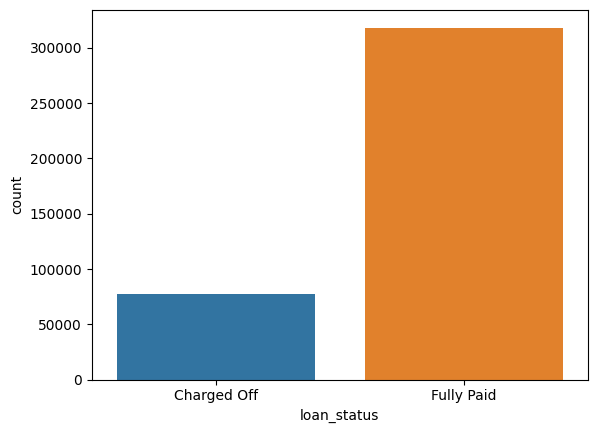

Percentage of data:
loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: count, dtype: float64


In [18]:
analyze_cat_variable(data, 'loan_status')

Observations:
1. The target variable loan_status has two unique values 'Charged Off' and 'Fully Paid'.
2. The dataset is highly imbalanced because the data split between 'Charge Off' and 'Fully Paid' is 19.61% : 80.39%.

There are 37795 missing values in mort_acc.
There are 33 categories in mort_acc.


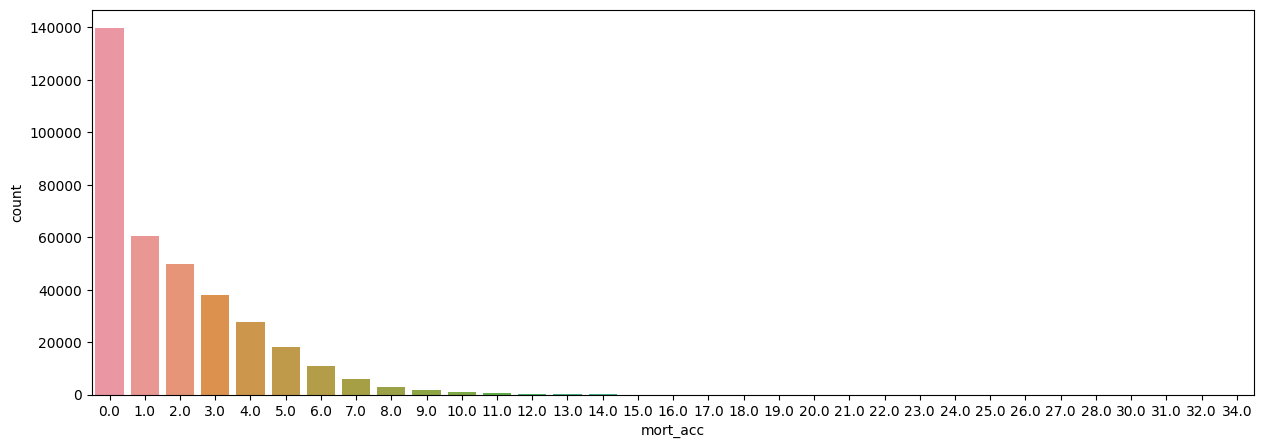

Top 5 categories in mort_acc:
mort_acc
0.0    35.294548
1.0    15.255410
2.0    12.612176
3.0     9.607605
4.0     7.041638
Name: count, dtype: float64
--------------------
Bottom 5 categories in mort_acc:
mort_acc
34.0    0.000253
28.0    0.000253
30.0    0.000253
26.0    0.000505
23.0    0.000505
Name: count, dtype: float64


In [19]:
analyze_cat_variable(data, 'mort_acc', plot_size = (15,5))

Observations:
1. We can see that above 35% of the data points have mort_acc = 0 followed by mort_accs 1, 2 and 3 with 15%, 12% and 9.5% datapoints.

There are 37795 missing values in mort_acc.


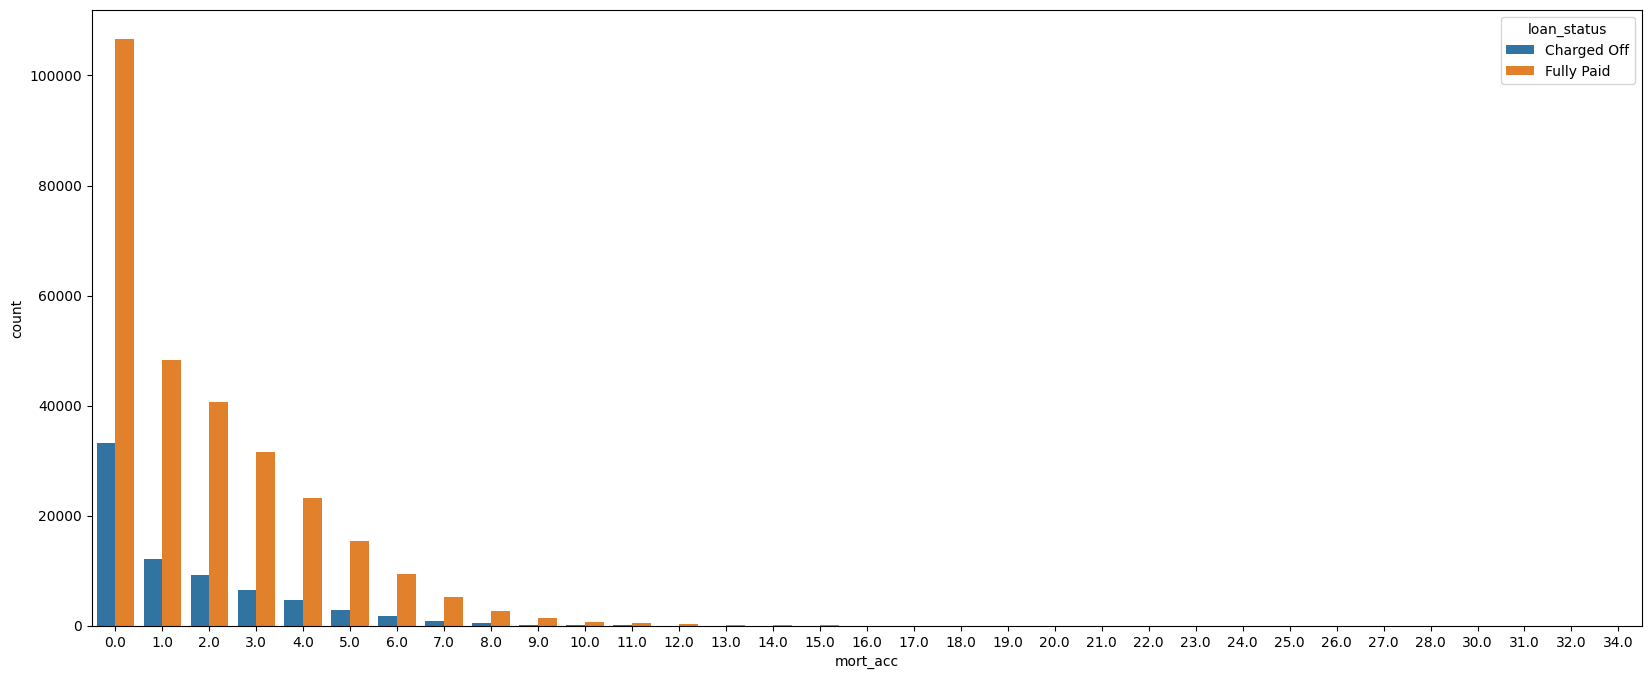

In [20]:
analyze_cat_variable(data, 'mort_acc', plot_size = (20,8), hue = 'loan_status')

Observations:
1. The Fully Paid vs Charged Off loan status don't seem to be different for each of the mort_acc categories.
2. We can create a feature that says if a Borrower has another mortage already or not and see how it works with the loan_status.

In [21]:
#creating a new feature to flag is a borrower has a mortgage account or not
data['has_mort_acc'] = data['mort_acc'].apply(lambda x: 1 if x > 0 else 0)

There are 2 categories in has_mort_acc.


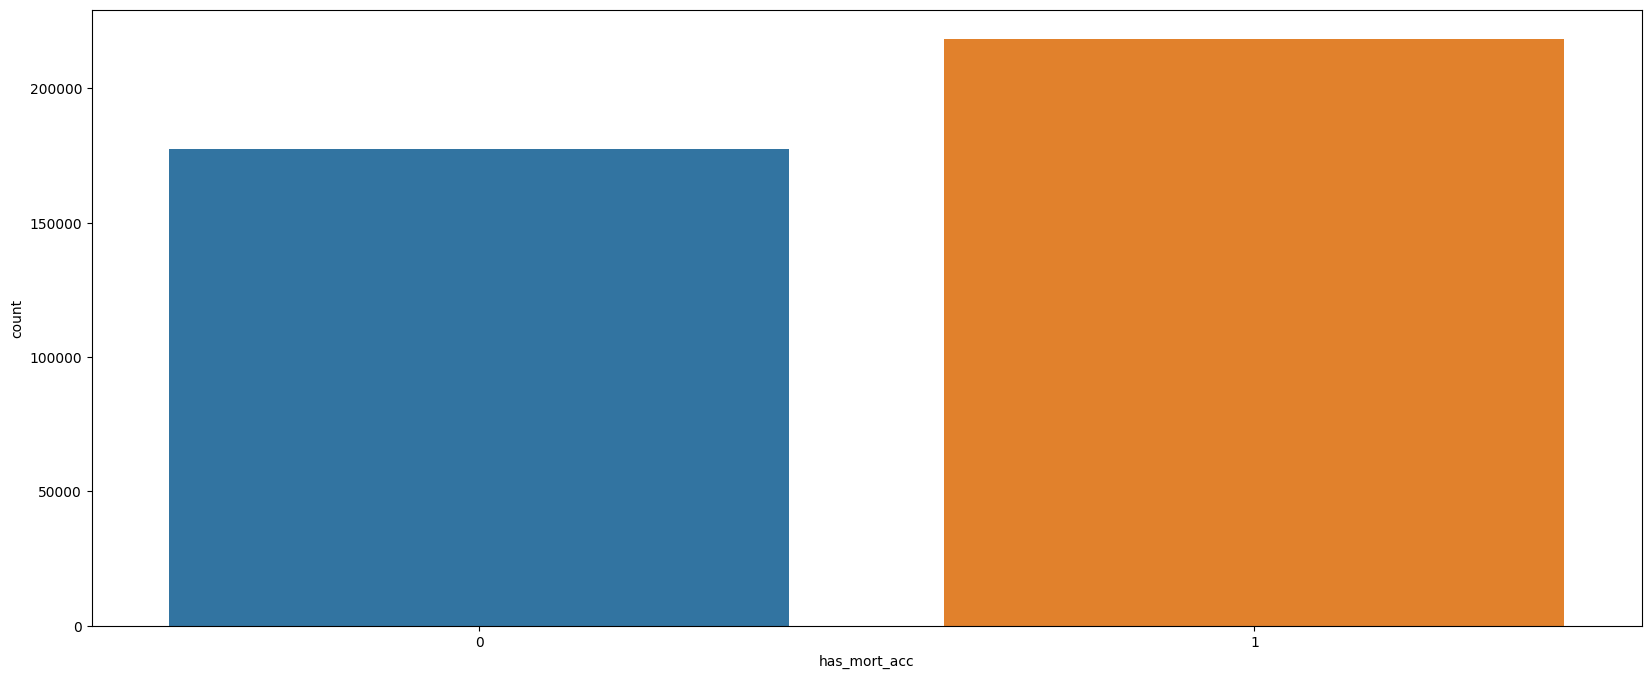

Percentage of data:
has_mort_acc
1    55.161983
0    44.838017
Name: count, dtype: float64


In [22]:
analyze_cat_variable(data, 'has_mort_acc', plot_size = (20,8))

Observations:
1. About 55% of the borrowers have 1 or more mortgage account. About 45% of the borrowers do not have any other mortgage accounts.

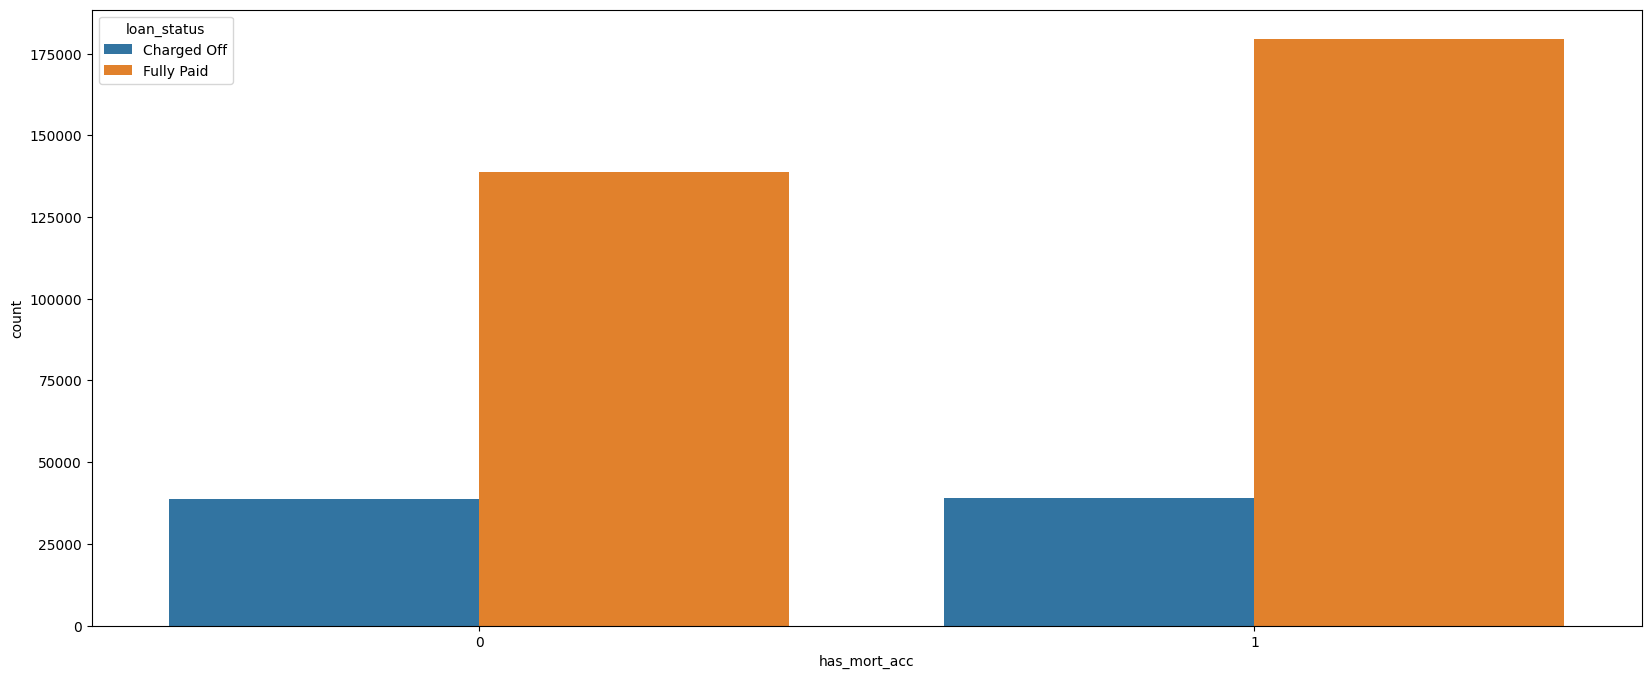

In [23]:
analyze_cat_variable(data, 'has_mort_acc', plot_size = (20,8), hue = 'loan_status')

Observations:
1. The 'Charged Off' category is very similar for borrowers that have mortgages accounts vs those that do not have mortgage accounts. However, the 'Fully Paid' category is slightly more in the borrowers group that have another mortgage accounts vs borrower group that have no another mortgage account.

There are 61 categories in open_acc.


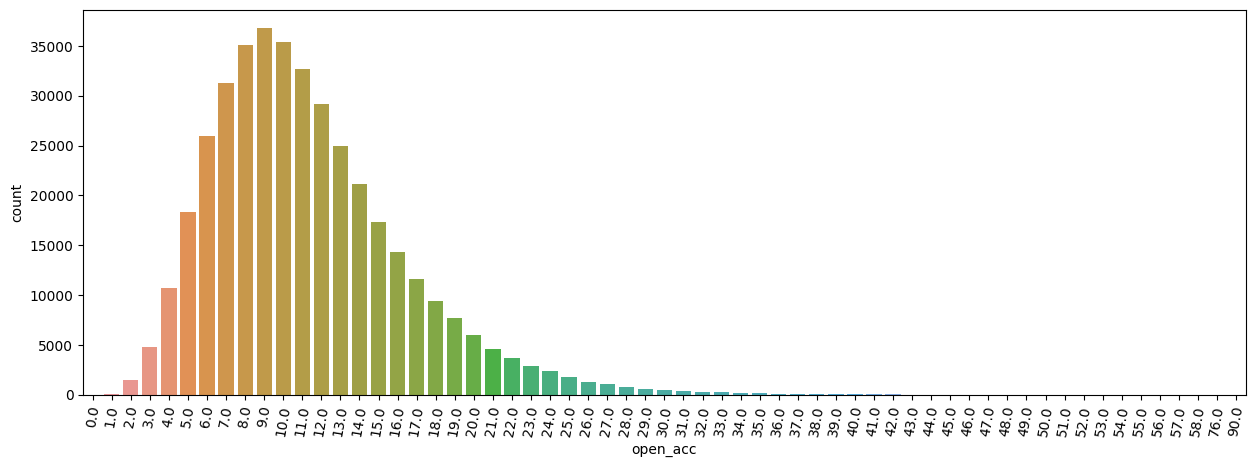

Top 5 categories in open_acc:
open_acc
9.0     9.286923
10.0    8.949070
8.0     8.872308
11.0    8.255688
7.0     7.910512
Name: count, dtype: float64
--------------------
Bottom 5 categories in open_acc:
open_acc
90.0    0.000253
58.0    0.000253
57.0    0.000253
76.0    0.000505
56.0    0.000505
Name: count, dtype: float64


In [24]:
analyze_cat_variable(data, 'open_acc', plot_size = (15,5), xtick_rotate = 80)

Observations:
1. Most of the borrowers have 5 to 15 open credit lines in their credit file.
2. The most number of borrowers have about 9 open credit lines in their credit file.

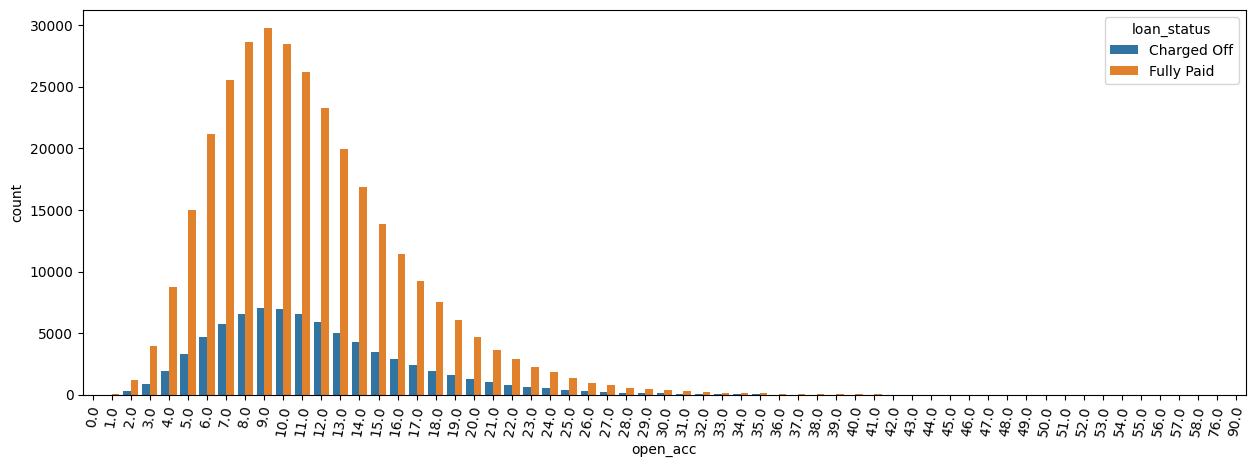

In [25]:
analyze_cat_variable(data, 'open_acc', plot_size = (15,5), xtick_rotate = 80, hue = 'loan_status')

There are 20 categories in pub_rec.


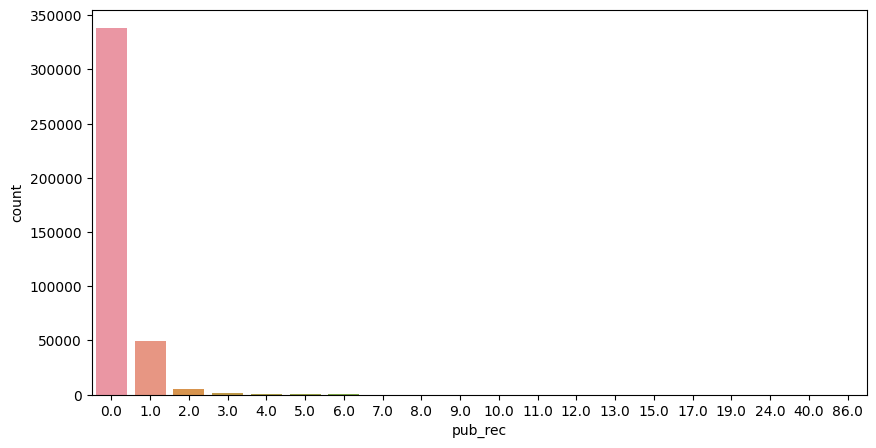

Top 5 categories in pub_rec:
pub_rec
0.0    85.415751
1.0    12.559402
2.0     1.382724
3.0     0.384062
4.0     0.133071
Name: count, dtype: float64
--------------------
Bottom 5 categories in pub_rec:
pub_rec
86.0    0.000253
24.0    0.000253
17.0    0.000253
15.0    0.000253
40.0    0.000253
Name: count, dtype: float64


In [26]:
analyze_cat_variable(data, 'pub_rec', plot_size = (10,5))

Observations:
1. Most of the borrowers in the dataset have no derogatory public records.

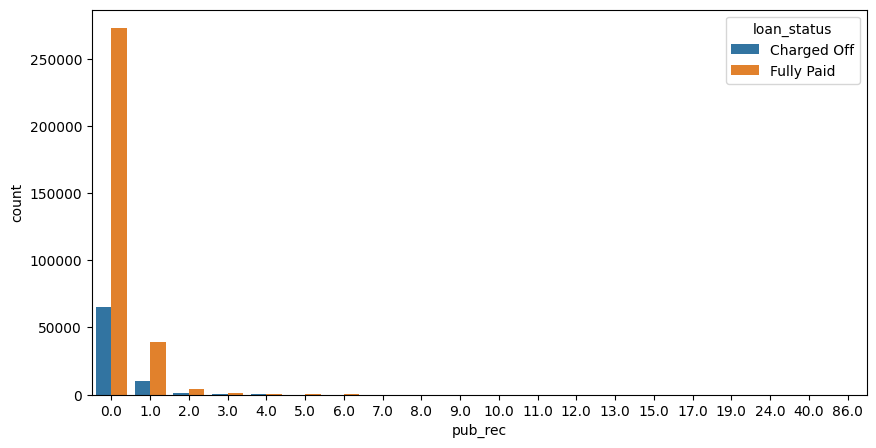

In [27]:
analyze_cat_variable(data, 'pub_rec', plot_size = (10,5), hue = 'loan_status')

In [28]:
# Creating a new feature setting 1 for any customers with public derogatory record.
data['has_pub_rec'] = data['pub_rec'].apply(lambda x: 1 if x > 0 else 0)

There are 2 categories in has_pub_rec.


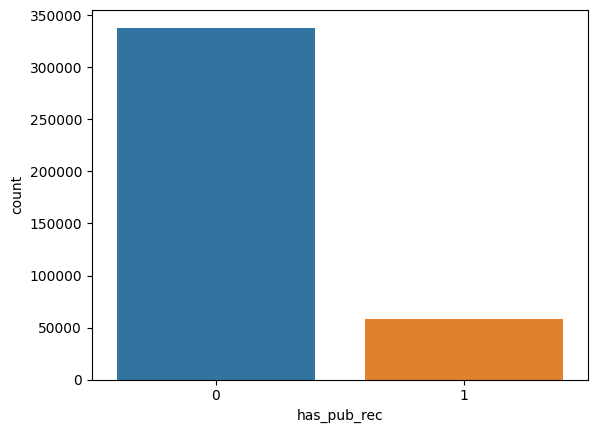

Percentage of data:
has_pub_rec
0    85.415751
1    14.584249
Name: count, dtype: float64


In [29]:
analyze_cat_variable(data, 'has_pub_rec')

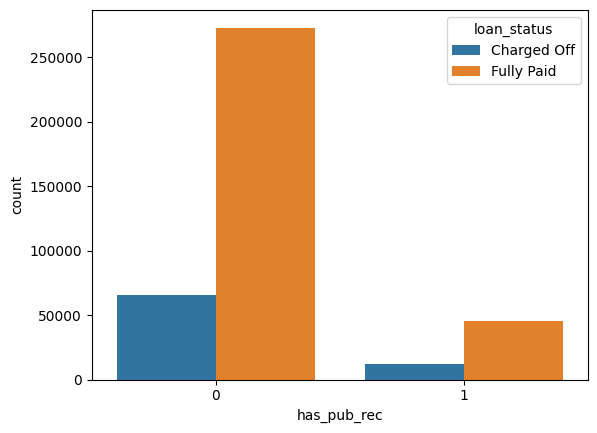

In [30]:
analyze_cat_variable(data, 'has_pub_rec', hue = 'loan_status')

Observations:
1. The difference between the number of loans Charged Off vs Fully Paid might be less for borrowers with derogatory public records compared to borrowers without derogatory public records. 

There are 535 missing values in pub_rec_bankruptcies.
There are 9 categories in pub_rec_bankruptcies.


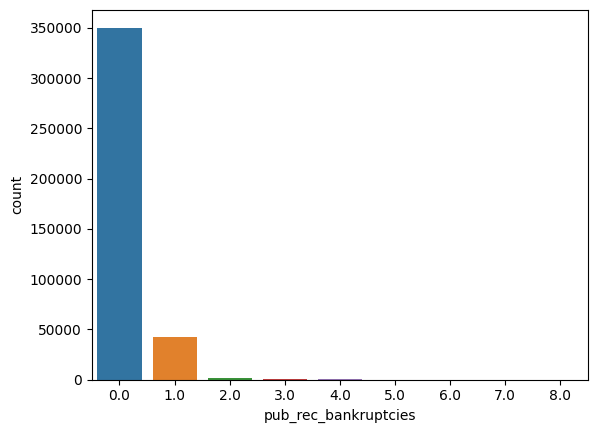

Percentage of data:
pub_rec_bankruptcies
0.0    88.473095
1.0    10.804737
2.0     0.466379
3.0     0.088630
4.0     0.020706
5.0     0.008080
6.0     0.001768
7.0     0.001010
8.0     0.000505
Name: count, dtype: float64


In [31]:
analyze_cat_variable(data, 'pub_rec_bankruptcies')

There are 535 missing values in pub_rec_bankruptcies.


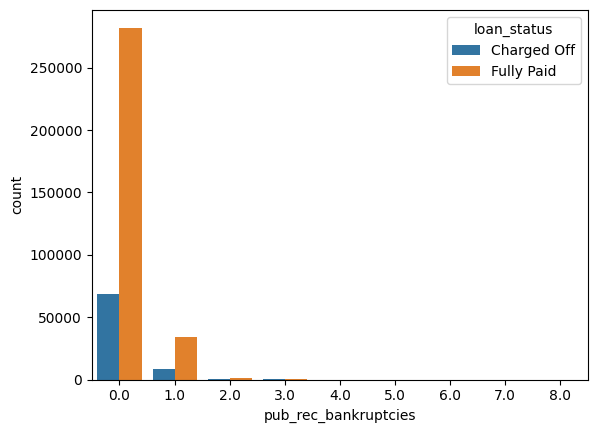

In [32]:
analyze_cat_variable(data, 'pub_rec_bankruptcies', hue = 'loan_status')

In [33]:
# Creating a new feature to find anyone with at least 1 public record bankruptcy
data['has_pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)

There are 535 missing values in has_pub_rec_bankruptcies.
There are 2 categories in has_pub_rec_bankruptcies.


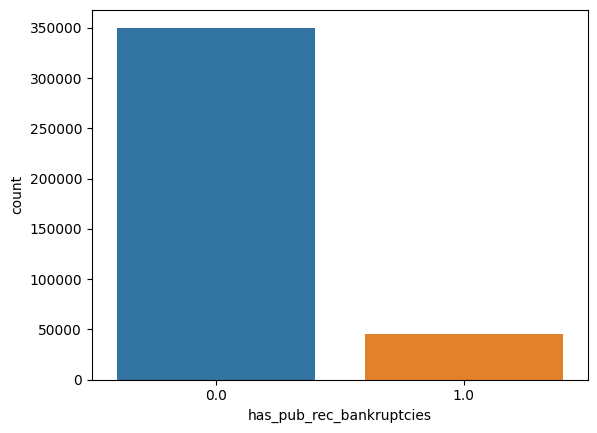

Percentage of data:
has_pub_rec_bankruptcies
0.0    88.473095
1.0    11.391814
Name: count, dtype: float64


In [34]:
analyze_cat_variable(data, 'has_pub_rec_bankruptcies')

Observations:
1. About 88.47% of the customers have no public record bankruptcy. About 11.4% of the customers have at least 1 public record bankruptcy.

There are 535 missing values in has_pub_rec_bankruptcies.


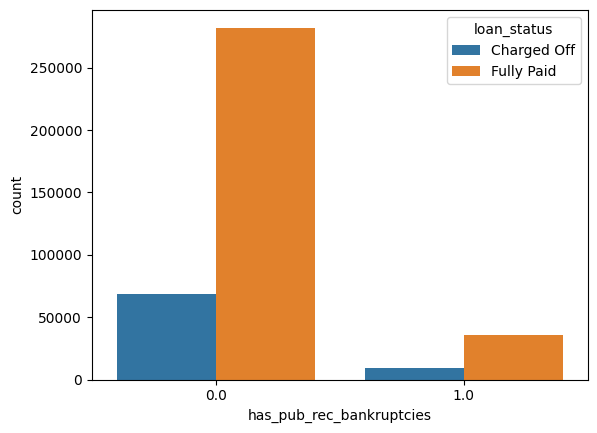

In [35]:
analyze_cat_variable(data, 'has_pub_rec_bankruptcies', hue = 'loan_status')

There are 2 categories in term.


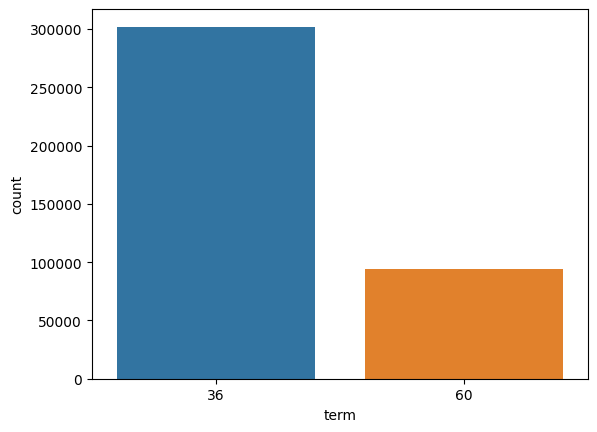

Percentage of data:
term
36    76.258112
60    23.741888
Name: count, dtype: float64


In [36]:
analyze_cat_variable(data, 'term')

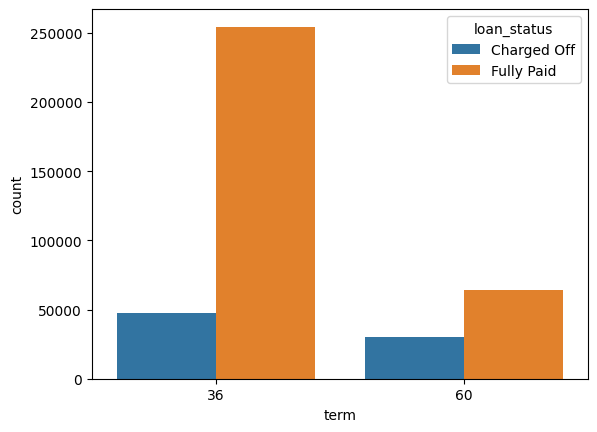

In [37]:
analyze_cat_variable(data, 'term', hue = 'loan_status')

Observations:
1. There are two terms of repayments 36 months and 60 months.
2. About 76.56% of the customers have chosen the 36 months term and 23.7% of the customers have chosen 60 months term.
3. There seem to be more percentage of Charge Off loans in 60 term than in 36.

There are 7 categories in grade.


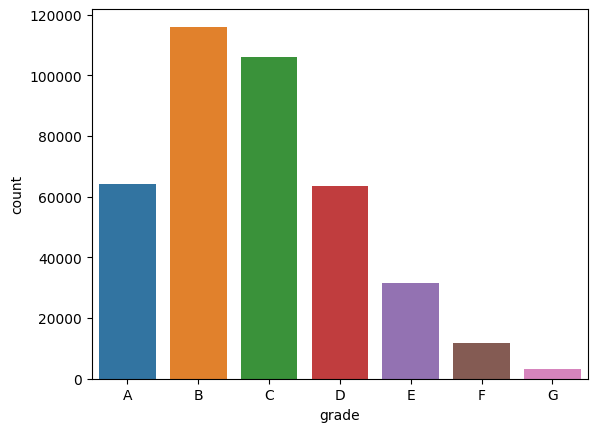

Percentage of data:
grade
B    29.295255
C    26.762366
A    16.207611
D    16.040199
E     7.950913
F     2.972502
G     0.771154
Name: count, dtype: float64


In [38]:
analyze_cat_variable(data, 'grade')

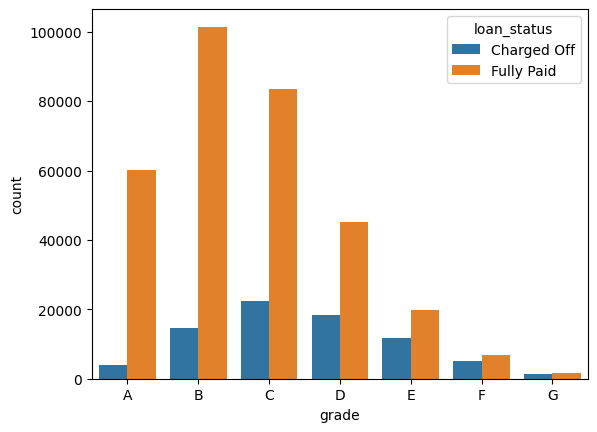

In [39]:
analyze_cat_variable(data, 'grade', hue = 'loan_status')

Observations:
1. The top 3 number of borrowers are in grades B, C and A.
2. The grades G, F and E are the ones with the least number of borrowers.
3. Grades G, F, E and D also seem to be a risky grades because they have more percentage of Charged Off loans although the Fully Paid is more.

There are 35 categories in sub_grade.


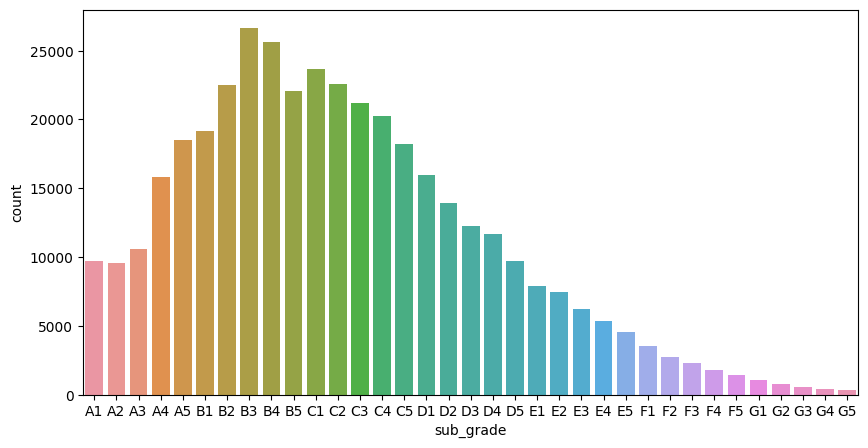

Top 5 categories in sub_grade:
sub_grade
B3    6.730551
B4    6.464409
C1    5.974800
C2    5.701588
B2    5.680125
Name: count, dtype: float64
--------------------
Bottom 5 categories in sub_grade:
sub_grade
G5    0.079792
G4    0.094437
G3    0.139383
G2    0.190390
G1    0.267151
Name: count, dtype: float64


In [40]:
analyze_cat_variable(data, 'sub_grade', plot_size = (10,5))

Observation:
1. The sub grades with top 3 number of data are the categories B3, B4 and C1 with 6.73%, 6.46% and 5.97% of data in these categories.
2. The sub grades with bottom 3 number of data are the categories G5, G4 and G3 with 6.73%, 6.46% and 5.97% of data in these categories.
3. The distribution seems to be skewed with less number of borrowers belonging to the F and G sub grades.

In [41]:
analyze_cat_variable(data, 'emp_title')

There are 22927 missing values in emp_title.
There are 173105 categories in emp_title.
Top 5 categories in emp_title:
emp_title
Teacher             1.108249
Manager             1.073151
Registered Nurse    0.468651
RN                  0.466126
Supervisor          0.462086
Name: count, dtype: float64
--------------------
Bottom 5 categories in emp_title:
emp_title
USMS                                   0.000253
Alcoa Fasteners                        0.000253
Alco Sales                             0.000253
Albertville City Board of Education    0.000253
Alcatraz Cruises, LLC                  0.000253
Name: count, dtype: float64


Observations:
1. About 11.1% and 1.07% of the customers are teachers and managers.

Checking which job titles have the ability to repay the loans more.

In [42]:
# encoding loan status
data['loan_status_num'] = data['loan_status'].map({'Fully Paid':1, 'Charged Off': 0})
data['loan_status_num'] = data['loan_status_num'].astype('int64')
#group by emp_title and sort by the number of Fully paid loans
data.groupby('emp_title')['loan_status_num'].sum().sort_values(ascending=False).head(2)

emp_title
Teacher    3532
Manager    3321
Name: loan_status_num, dtype: int64

In [43]:
# Calculating the percentage of customers that repaid the loan based on their job tiles.
title_count = data['emp_title'].value_counts()
repaid_count = data[data['loan_status'] == 'Fully Paid']['emp_title'].value_counts()
#getting the percentage of repayments in each emp_title
data['repay_ability_by_emp_title'] = data['emp_title'].map(repaid_count / title_count).fillna(0)


In [44]:
#calculating the mean repayability
job_title_df = data.groupby(by = 'emp_title').agg(repayability= ('repay_ability_by_emp_title','mean'),
                                   Number_of_borrowers = ('emp_title','count'),
                                   avg_loan_amnt = ('loan_amnt','mean'))
#.sort_values(['Number_of_borrowers','repayability','avg_loan_amnt'], ascending = False)

In [45]:
job_title_df = job_title_df.reset_index()

In [46]:
#Normalizing the repay strength and creating a new feature that captures the interaction between
#repayability and number of loans borrowed.
normalize = MinMaxScaler()
job_title_df['norm_borrowers_weight'] = normalize.fit_transform(job_title_df[['Number_of_borrowers']])
job_title_df['repay_strength_by_emp_title_and_count'] = job_title_df['repayability'] * job_title_df['norm_borrowers_weight']
job_title_df.sort_values(['repay_strength_by_emp_title_and_count'], ascending = False).head()

,emp_title,repayability,Number_of_borrowers,avg_loan_amnt,norm_borrowers_weight,repay_strength_by_emp_title_and_count
131646,Teacher,0.804739,4389,13899.863295,1.000000,0.804739
79440,Manager,0.781412,4250,15306.000000,0.968323,0.756659
107851,Registered Nurse,0.795259,1856,16470.514547,0.422744,0.336191
105520,RN,0.794691,1846,16217.727519,0.420465,0.334140
128747,Supervisor,0.778689,1830,14264.098361,0.416819,0.324572


Observations:
1. Based on the repayability strength, the top 2 job titles are teacher and manager.

In [47]:
data.groupby(['emp_title']).mean('annual_inc')[['annual_inc']].sort_values(['annual_inc'], ascending = False)

,annual_inc
emp_title,
Correctional Sgt.,8706582.0
Interim Director of Case Management,7600000.0
Legal admin asst,7000000.0
BOONE AND SONS JEWELERS,6100000.0
VISIUM asset management,5000000.0
...,...
public partnership,4888.0
Yogurt Stop,4800.0
The Art Institute of Phoenix,4800.0


Observations:
1. The most paid professions are Correctional Sgt., Interim Director of Case Management and Legal admin asst with 8706582, 7600000 and 7000000 as annual income.

In [48]:
data.groupby(['emp_title']).mean('dti')[['dti']].sort_values(['dti'], ascending = True).head(130)

,dti
emp_title,
Grahams Greenhouse,0.00
Staff Software Development Engineer,0.00
Rowland USD,0.00
ny state department of corrections,0.00
Cambrldge Care,0.00
...,...
"Park Place Everett, LLC",0.00
Federation of State Medical Boards,0.01
DLW Consulting,0.01


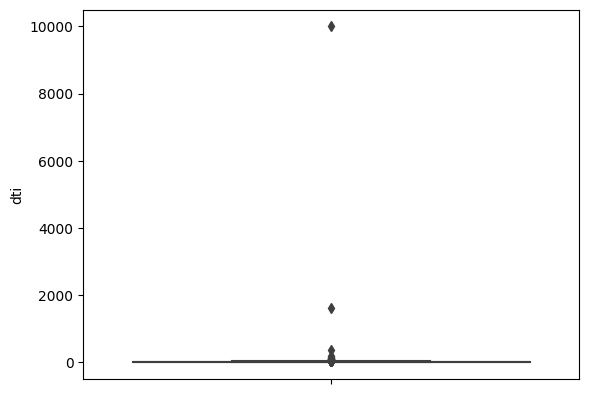

In [49]:
sns.boxplot(data, y = 'dti')
plt.show()

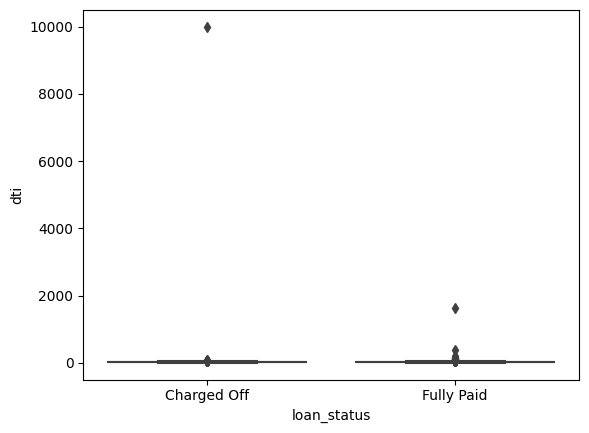

In [50]:
sns.boxplot(data, x = 'loan_status', y = 'dti')
plt.show()

Observations:
1. The boxplot shows that the values in dti are very close to each other. However, there are some large outliers in it.
2. The extreme outlier is in the Charged Off group. The Fully Paid group also have some outliers.

There are 18301 missing values in emp_length.
There are 11 categories in emp_length.


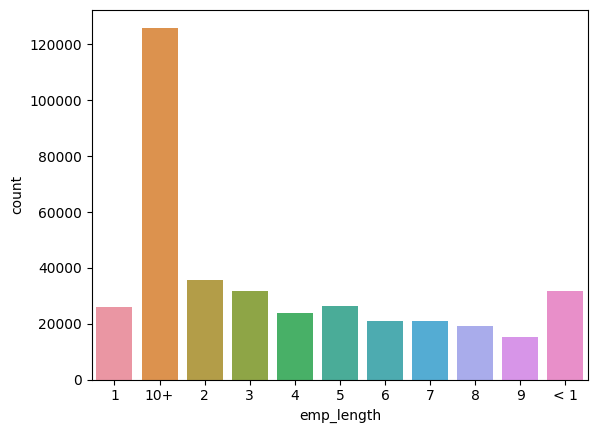

Top 5 categories in emp_length:
emp_length
10+    31.826124
2       9.046537
< 1     8.010757
3       7.995606
5       6.690150
Name: count, dtype: float64
--------------------
Bottom 5 categories in emp_length:
emp_length
9    3.866879
8    4.840037
7    5.256925
6    5.262480
4    6.048027
Name: count, dtype: float64


In [51]:
analyze_cat_variable(data, 'emp_length')

There are 18301 missing values in emp_length.


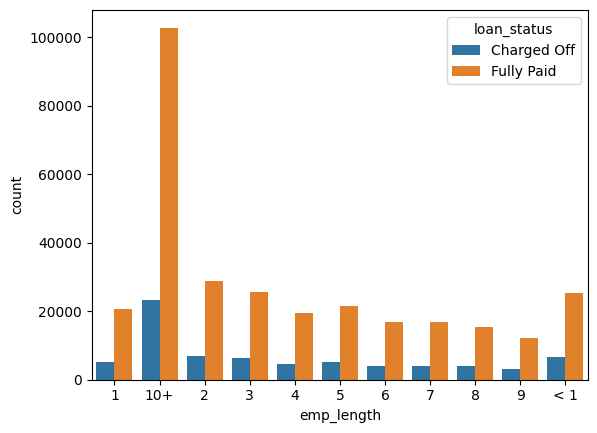

In [52]:
analyze_cat_variable(data, 'emp_length', hue = 'loan_status')

Observations:
1. About 31.8% of the customers are in the 10+ years bucket followed by 2 years with 9% customers and less than 1 year with 8% of the customers.

There are 3 categories in verification_status.


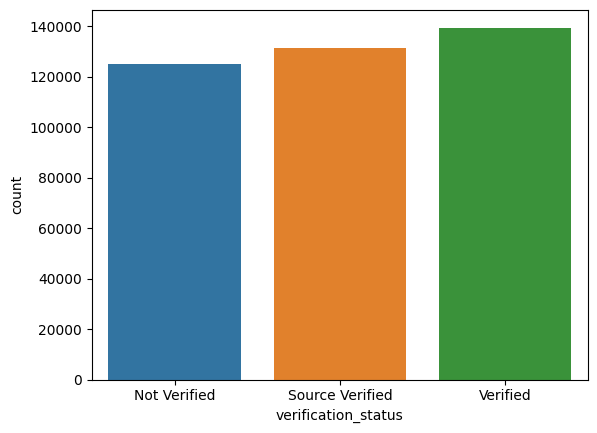

Percentage of data:
verification_status
Verified           35.240512
Source Verified    33.175517
Not Verified       31.583971
Name: count, dtype: float64


In [53]:
analyze_cat_variable(data, 'verification_status')

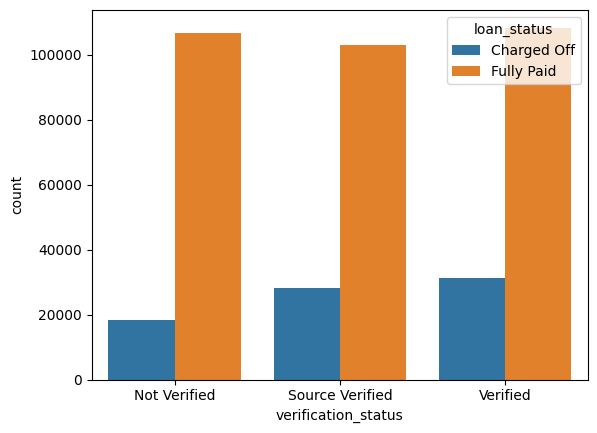

In [54]:
analyze_cat_variable(data, 'verification_status', hue = 'loan_status')

Observations:
1. For most of the customers, their income source have been verified. Income was not verified for only a 31.6% of the customers.
2. An interesting information noticed that the number of Charged Off loans are the least in the Not verified group. The verified groups have slightly more percentage of Charged Off loans.

There are 14 categories in purpose.


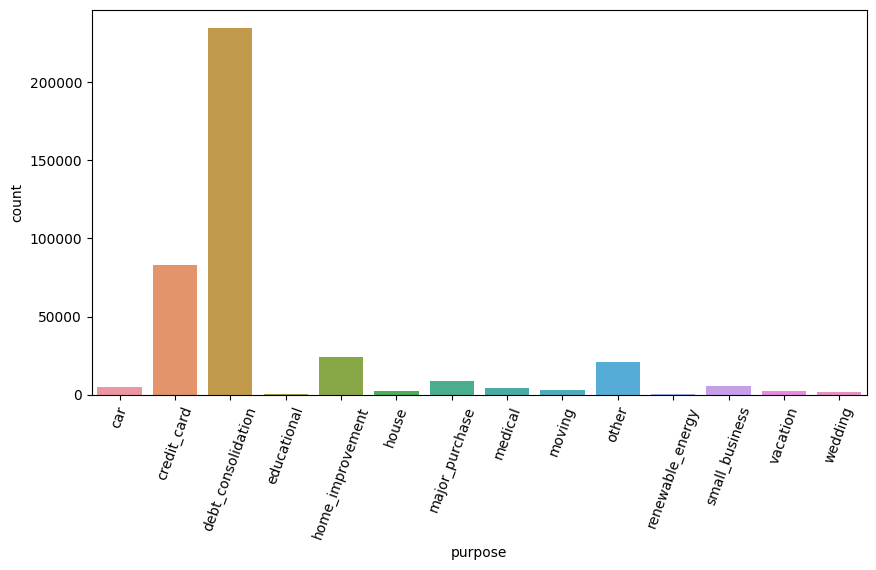

Top 5 categories in purpose:
purpose
debt_consolidation    59.214453
credit_card           20.962806
home_improvement       6.067722
other                  5.349342
major_purchase         2.219529
Name: count, dtype: float64
--------------------
Bottom 5 categories in purpose:
purpose
educational         0.064894
renewable_energy    0.083075
wedding             0.457541
house               0.555766
vacation            0.619145
Name: count, dtype: float64


In [55]:
analyze_cat_variable(data, 'purpose', plot_size = (10,5), xtick_rotate = 70)

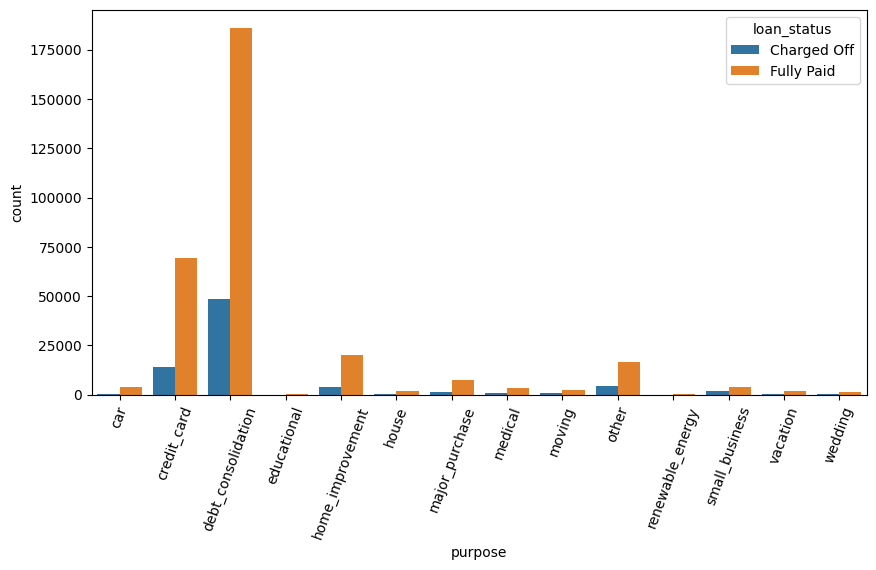

In [56]:
analyze_cat_variable(data, 'purpose', plot_size = (10,5), xtick_rotate = 70, hue = 'loan_status')

Observations:
1. About 59.2% of the borrowers say that the purpose of the loan is for debt_consolidation. They are taking the loan in-order to close out other loans. This could be a potential product opportunity. The bank may offer a new product where they can take over the customers' existing loan for a better rate of interest, installment or tenure that attracts the customer.
2. The 2nd most popular reason is to close credit card balances.
3. The least popular purpose is education and renewable energy.
4. The 'debt_consolidation group has the highest number of Charge Off loans. It is crucial to check the background of these customers before approving their loans.

In [57]:
analyze_cat_variable(data, 'title')

There are 1756 missing values in title.
There are 48816 categories in title.
Top 5 categories in title:
title
Debt consolidation         38.500114
Credit card refinancing    13.000783
Home improvement            3.854253
Other                       3.264904
Debt Consolidation          2.931091
Name: count, dtype: float64
--------------------
Bottom 5 categories in title:
title
family emergency travel    0.000253
AWESOME                    0.000253
AYUDA                      0.000253
AZ home                    0.000253
A_Small_Loan               0.000253
Name: count, dtype: float64


Observations:
1. Similar to the purpose, the title also shows that most of the loans are for debt consolidation and credit card refinancing.

There are 2 categories in initial_list_status.


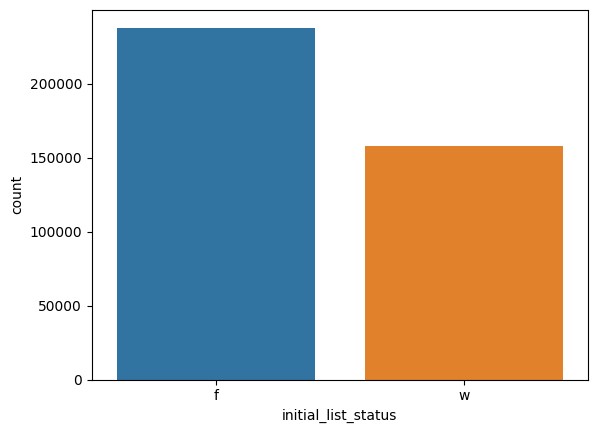

Percentage of data:
initial_list_status
f    60.113123
w    39.886877
Name: count, dtype: float64


In [58]:
analyze_cat_variable(data, 'initial_list_status')

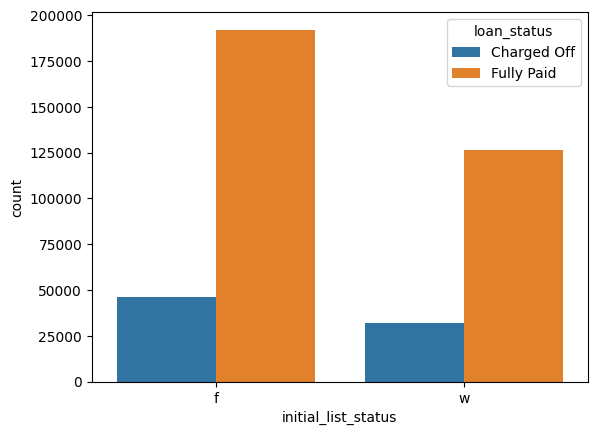

In [59]:
analyze_cat_variable(data, 'initial_list_status', hue = 'loan_status')

There are 3 categories in application_type.


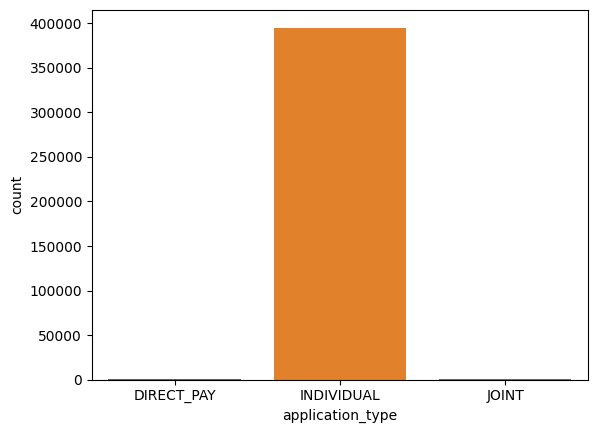

Percentage of data:
application_type
INDIVIDUAL    99.820468
JOINT          0.107315
DIRECT_PAY     0.072217
Name: count, dtype: float64


In [60]:
analyze_cat_variable(data, 'application_type')

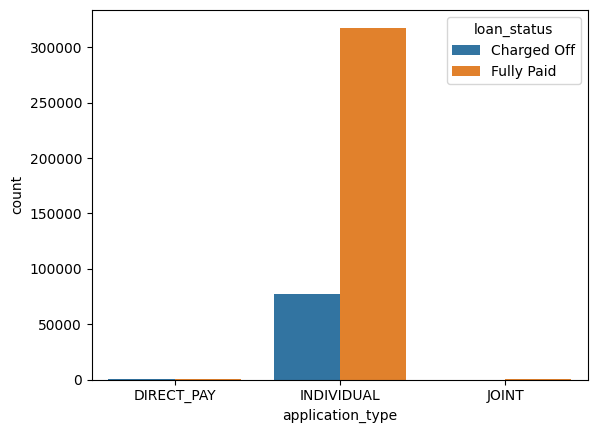

In [61]:
analyze_cat_variable(data, 'application_type', hue = 'loan_status')

There are 10 categories in zip_code.


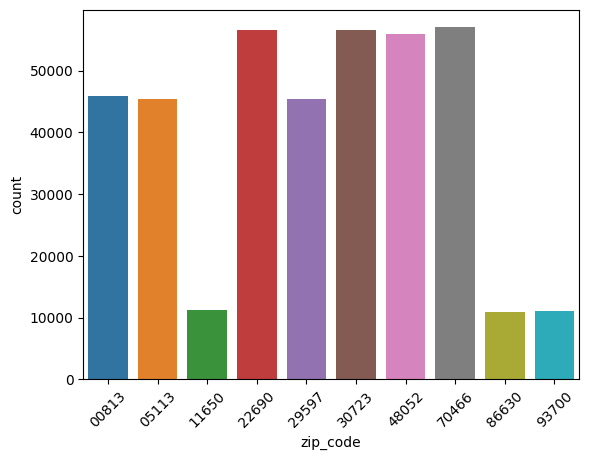

Percentage of data:
zip_code
70466    14.389061
30723    14.278211
22690    14.273414
48052    14.119385
00813    11.570841
29597    11.481706
05113    11.464283
11650     2.834634
93700     2.815696
86630     2.772770
Name: count, dtype: float64


In [62]:
analyze_cat_variable(data, 'zip_code', xtick_rotate = 45)

Observations:
1. The top 3 number of customers are from zip_codes 70466, 30723 and 22690.

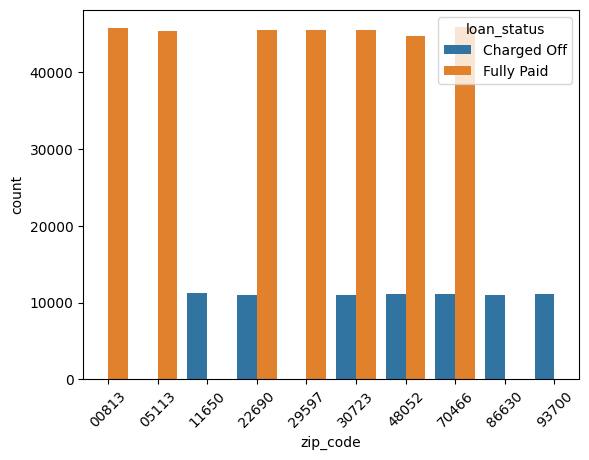

In [63]:
analyze_cat_variable(data, 'zip_code', xtick_rotate = 45, hue = 'loan_status')

Observations:
1. Customers from zip codes 00813, 05113 and 29597 have a very good repayment behaviour and customers from zip codes 11650, 86630 and 93700 are high risk since they show a risky behaviour of loans being charged off.

There are 57 categories in state_code.


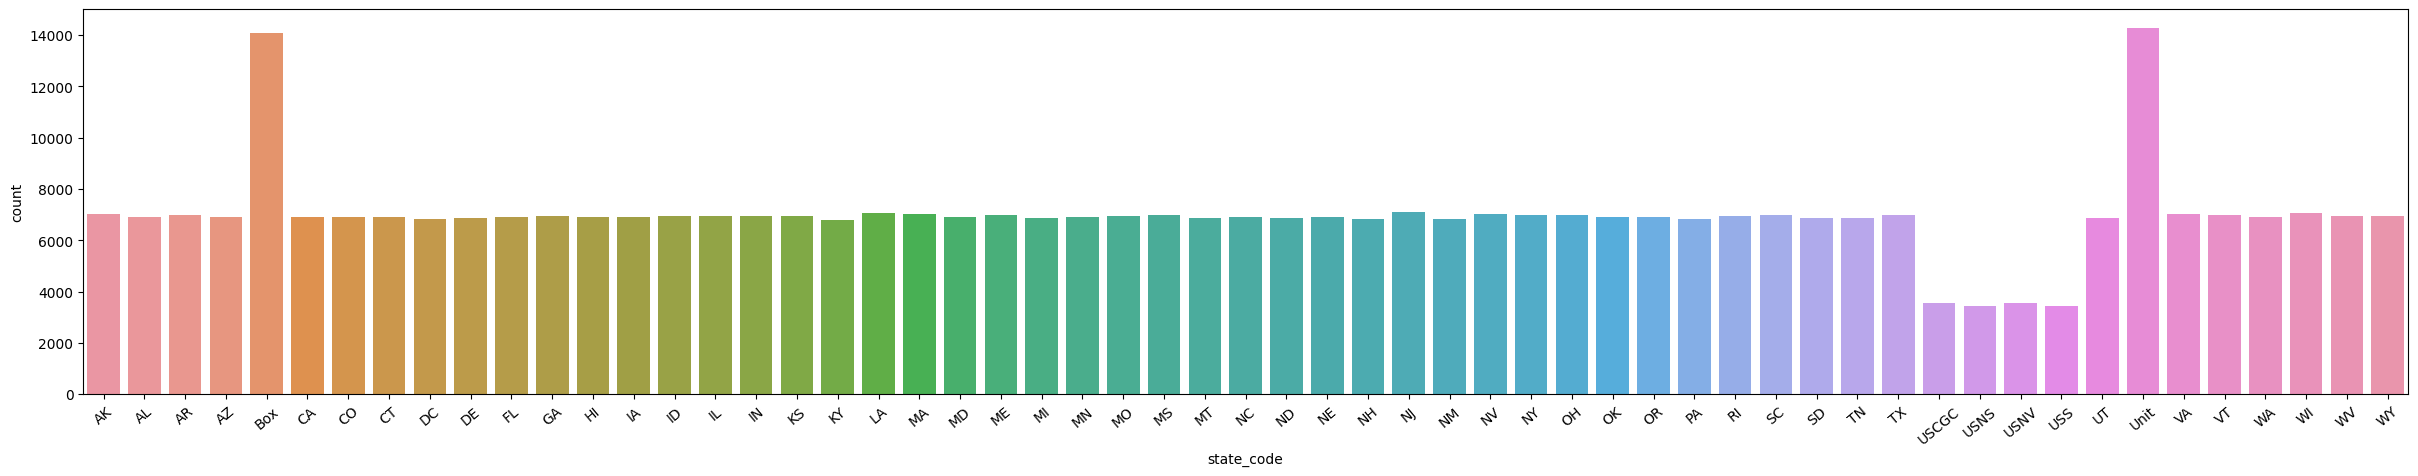

Top 5 categories in state_code:
state_code
Unit    3.608060
Box     3.550236
NJ      1.790521
WI      1.787996
LA      1.784713
Name: count, dtype: float64
--------------------
Bottom 5 categories in state_code:
state_code
USS      0.870389
USNS     0.872409
USNV     0.900184
USCGC    0.900942
KY       1.717042
Name: count, dtype: float64


In [64]:
analyze_cat_variable(data, 'state_code', plot_size = (30,5), xtick_rotate = 40)

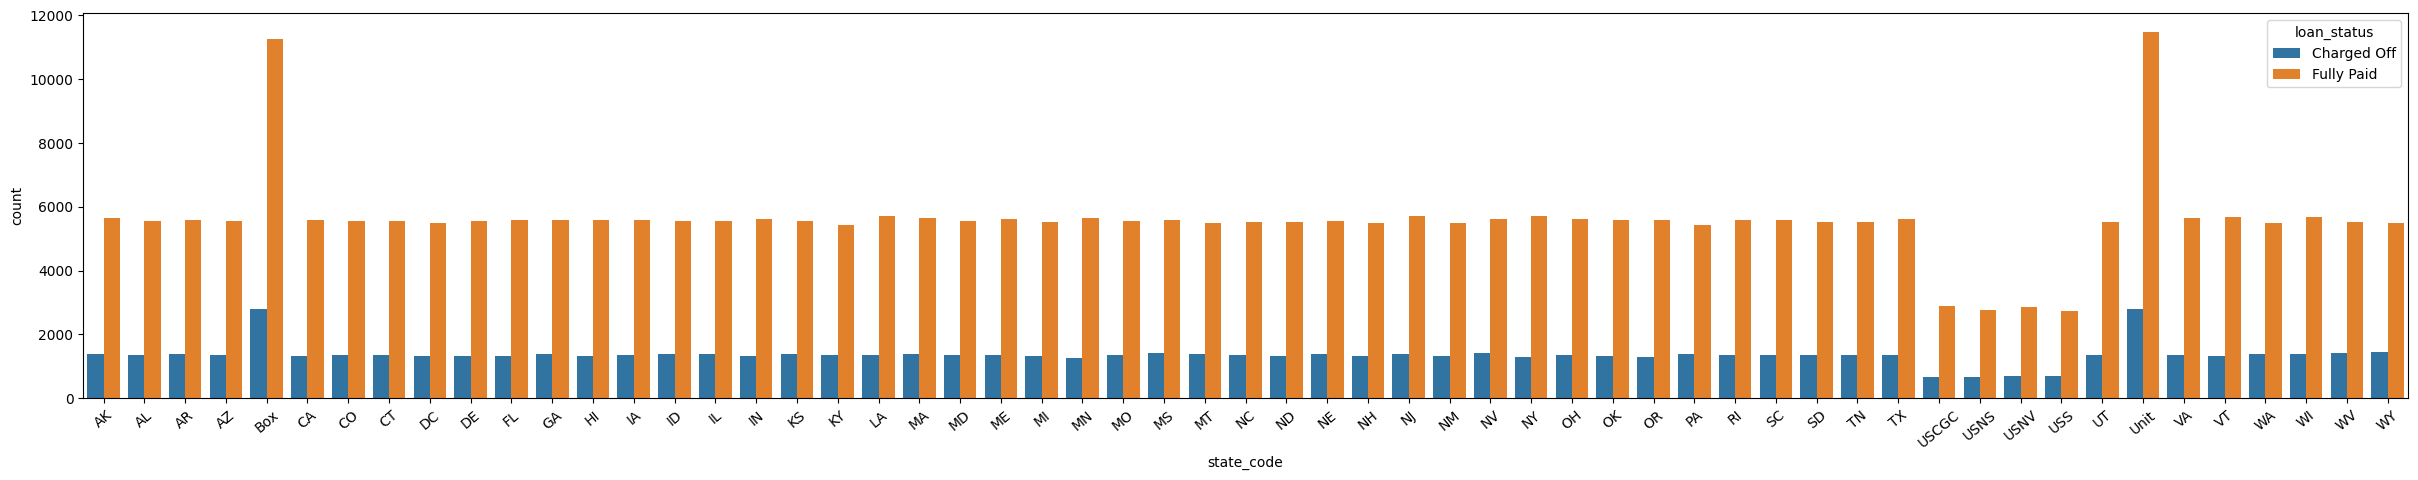

In [65]:
analyze_cat_variable(data, 'state_code', plot_size = (30,5), xtick_rotate = 40, hue = 'loan_status')

In [66]:
states_total = data['state_code'].value_counts()
paid_states_total = data[data['loan_status'] == 'Fully Paid']['state_code'].value_counts()
pd.DataFrame(paid_states_total/ states_total).sort_values(['count'], ascending = False).head(3)

,count
state_code,
MN,0.819090
NY,0.813535
USCGC,0.811659


Observations:
1. All state_codes show 79% and more percent of Fully Paid loan statuses.

##### Testing the association between state codes and the loan status.

In [67]:
H0 = "There is no association between state_code and loan_status."
H1 = "There is an association between state_code and loan_status."
alpha = 0.05
#creating cross table and performing chi2 test
crs_tab = pd.crosstab(data['loan_status'], data['state_code'])
p_value= chi2_contingency(crs_tab).pvalue
print(f"P value is {p_value}.")

if p_value <= alpha:
    print("Rejected Null Hypothesis.")
    print("Result: ",H1)
else:
    print("Failed to reject Null Hypothesis.")
    print("Result: ", H0)

P value is 0.7190461743894501.
Failed to reject Null Hypothesis.
Result:  There is no association between state_code and loan_status.


Observations:
1. There is not association between the state_code and the loan_status.

##### Testing the association between zip code and loan status

In [68]:
H0 = "There is no association between zip_code and loan_status."
H1 = "There is an association between zip_code and loan_status."
alpha = 0.05
#creating cross table and performing chi2 test
crs_tab = pd.crosstab(data['loan_status'], data['zip_code'])
p_value= chi2_contingency(crs_tab).pvalue
print(f"P value is {p_value}.")

if p_value <= alpha:
    print("Rejected Null Hypothesis.")
    print("Result: ",H1)
else:
    print("Failed to reject Null Hypothesis.")
    print("Result: ", H0)

P value is 0.0.
Rejected Null Hypothesis.
Result:  There is an association between zip_code and loan_status.


Observations:
1. The chi2 test confirms that there is statistically significant association between the zip_code and loan_status.

There are 12 categories in issue_d_month.


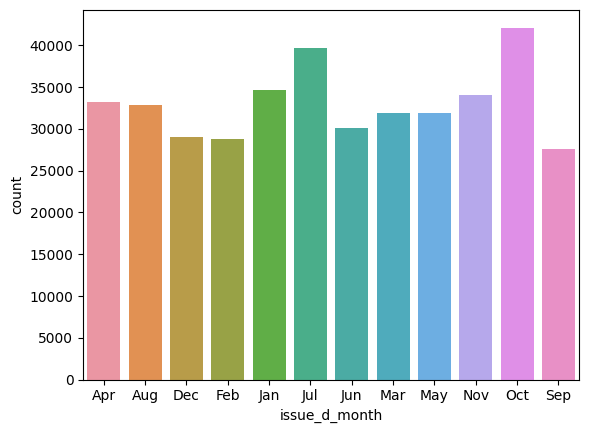

Top 5 categories in issue_d_month:
issue_d_month
Oct    10.638083
Jul    10.028028
Jan     8.757417
Nov     8.602379
Apr     8.389011
Name: count, dtype: float64
--------------------
Bottom 5 categories in issue_d_month:
issue_d_month
Sep    6.973967
Feb    7.257531
Dec    7.343383
Jun    7.610535
May    8.053683
Name: count, dtype: float64


In [69]:
analyze_cat_variable(data, 'issue_d_month')

There are 10 categories in issue_d_year.


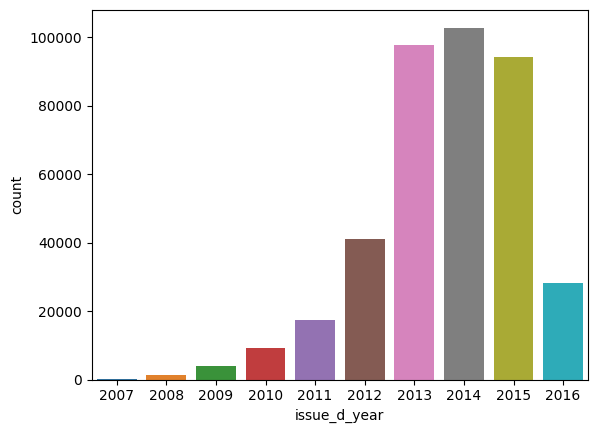

Percentage of data:
issue_d_year
2014    25.972780
2013    24.660253
2015    23.802237
2012    10.403757
2016     7.092392
2011     4.402444
2010     2.337702
2009     0.966088
2008     0.313108
2007     0.049239
Name: count, dtype: float64


In [70]:
analyze_cat_variable(data, 'issue_d_year')

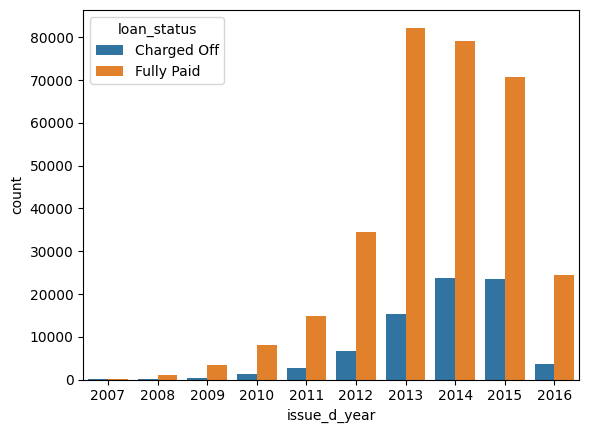

In [71]:
analyze_cat_variable(data, 'issue_d_year', hue = 'loan_status')

Onservations:
1. The years 2013, 2014 and 2015 have the highest number of loans issued.
2. The year 2015 shows the highest percentage of Charged Off loans.

There are 12 categories in earliest_cr_line_month.


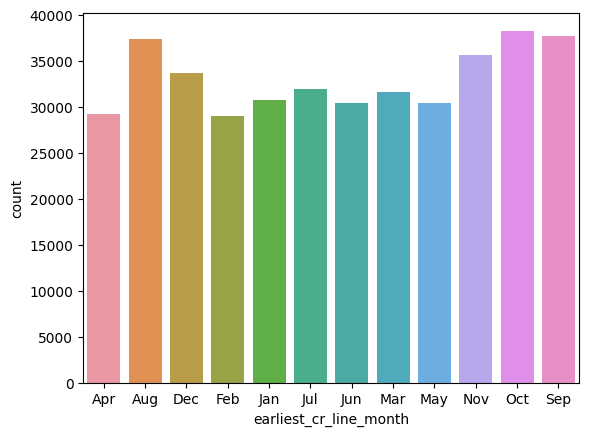

Top 5 categories in earliest_cr_line_month:
earliest_cr_line_month
Oct    9.668712
Sep    9.512663
Aug    9.430851
Nov    8.984925
Dec    8.506174
Name: count, dtype: float64
--------------------
Bottom 5 categories in earliest_cr_line_month:
earliest_cr_line_month
Feb    7.333535
Apr    7.381006
Jun    7.687549
May    7.687549
Jan    7.750423
Name: count, dtype: float64


In [72]:
analyze_cat_variable(data, 'earliest_cr_line_month')

There are 65 categories in earliest_cr_line_year.


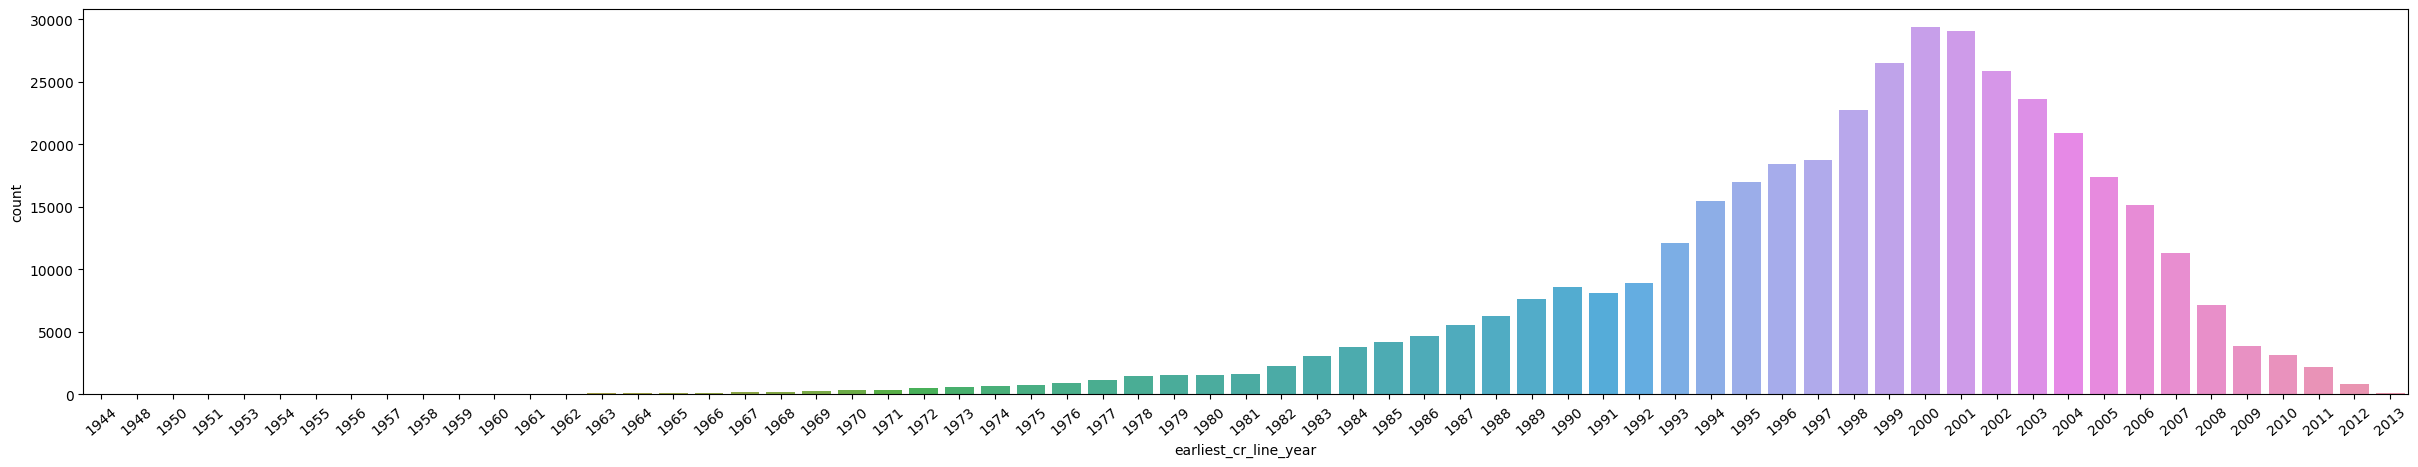

Top 5 categories in earliest_cr_line_year:
earliest_cr_line_year
2000    7.415095
2001    7.343636
1999    6.689140
2002    6.540161
2003    5.973537
Name: count, dtype: float64
--------------------
Bottom 5 categories in earliest_cr_line_year:
earliest_cr_line_year
1944    0.000253
1948    0.000253
1953    0.000505
1950    0.000758
1951    0.000758
Name: count, dtype: float64


In [73]:
analyze_cat_variable(data, 'earliest_cr_line_year', plot_size = (30,5), xtick_rotate = 40)

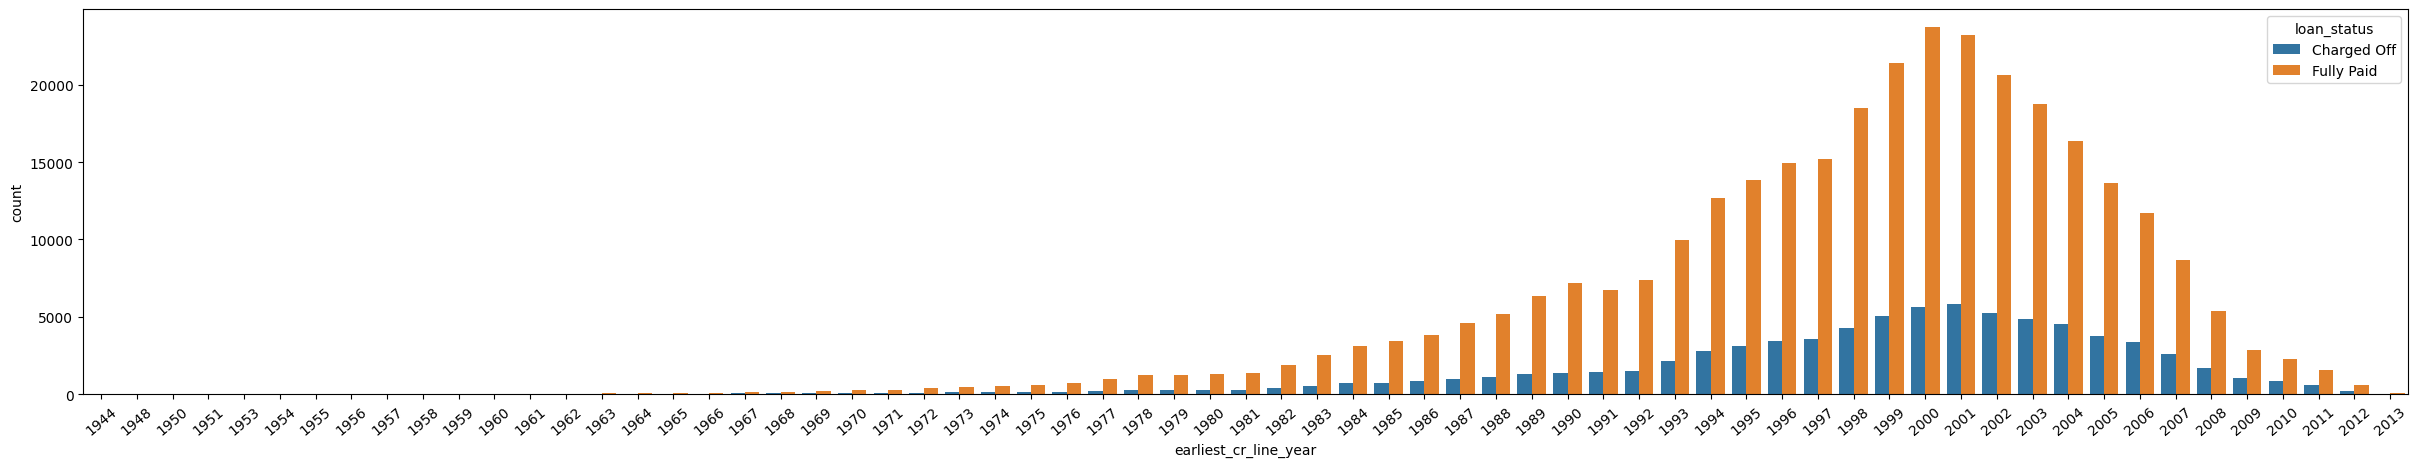

In [74]:
analyze_cat_variable(data, 'earliest_cr_line_year', plot_size = (30,5), xtick_rotate = 40, hue = 'loan_status')

Observations:
1. Most of the customers have the earliest credit line year between 1997 to 2005.

There are 7 categories in grade.


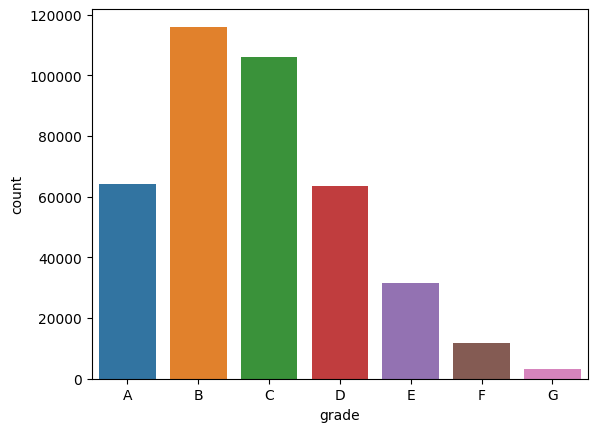

Percentage of data:
grade
B    29.295255
C    26.762366
A    16.207611
D    16.040199
E     7.950913
F     2.972502
G     0.771154
Name: count, dtype: float64


In [75]:
analyze_cat_variable(data, 'grade')

Observations:
1. Most of the customers fall in the loan grade B (29.3%) followed by C (26.76%) and A (16.2%).
2. Least number of customers fall in loan grade G (0.77%).

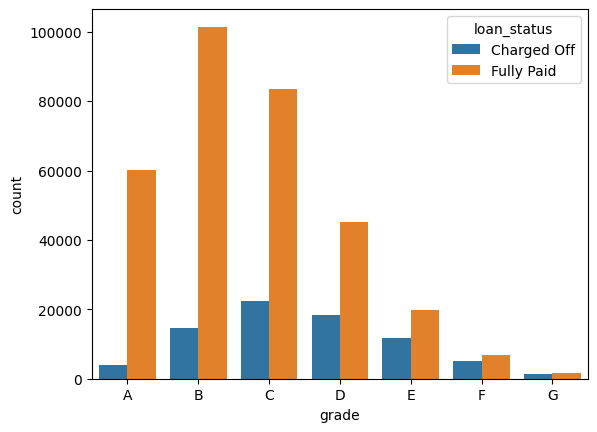

In [76]:
analyze_cat_variable(data, 'grade', hue = 'loan_status')

In [77]:
#calculating the percentage of Fully paid and Charged Off loans from each grade 
for grd in data['grade'].unique():
    f_percent = data[(data['grade'] == grd) & (data['loan_status'] == 'Fully Paid')].shape[0]
                /data[(data['grade'] == grd)].shape[0]*100
    c_percent = data[(data['grade'] == grd) & (data['loan_status'] == 'Charged Off')].shape[0]
                /data[(data['grade'] == grd)].shape[0]*100
    print(f"For Grade: {grd}")
    print(f"{f_percent}% of customers have Paid the loan fully and {c_percent}% of customers have their loan charged off.")


For Grade: B
87.42695099036357% of customers have Paid the loan fully and 12.573049009636437% of customers have their loan charged off.
For Grade: A
93.71212239238476% of customers have Paid the loan fully and 6.28787760761525% of customers have their loan charged off.
For Grade: C
78.81910045571627% of customers have Paid the loan fully and 21.180899544283733% of customers have their loan charged off.
For Grade: E
62.63655995934959% of customers have Paid the loan fully and 37.36344004065041% of customers have their loan charged off.
For Grade: D
71.13217051822933% of customers have Paid the loan fully and 28.86782948177067% of customers have their loan charged off.
For Grade: F
57.21202854230377% of customers have Paid the loan fully and 42.78797145769623% of customers have their loan charged off.
For Grade: G
52.16110019646365% of customers have Paid the loan fully and 47.83889980353634% of customers have their loan charged off.


Observations:
1. Although grade A has only the third most number of customers in it, about 93.71% of the customers in grade A have Fully Paid the loan amount.
2. Grade B comes 2nd with 87.4% of customers fully paid the loan and Grade C comes 3rd with 78.8%.
3. Customers in Grade G have the most number or customers for whom the loan is charge off (47.8%). This grade is the most riskiest followed by Grade F with 42.8% of the loans charged off.
4. Grade could be an important feature in determining the loan_status.

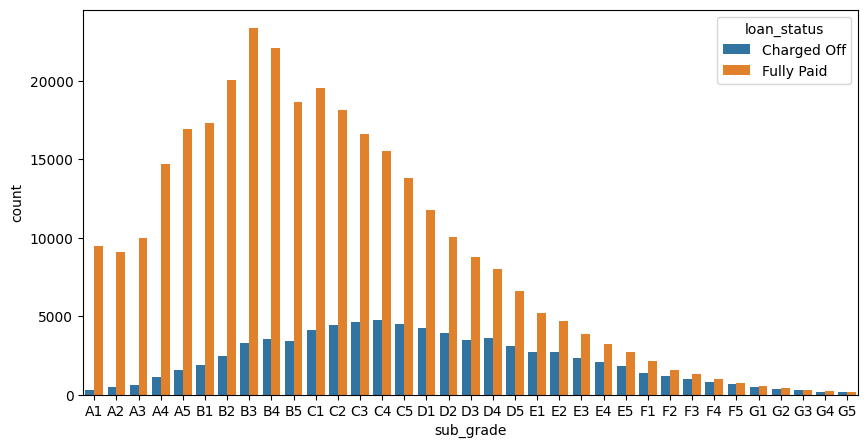

In [78]:
analyze_cat_variable(data, 'sub_grade', hue = 'loan_status', plot_size = (10,5))

Observations:
1. The sub-grades of C have the most percentage of Charge Off loans.
2. The sub-grade of B seem to be the safest with most percentage of Fully Paid loans.

There are 6 categories in home_ownership.


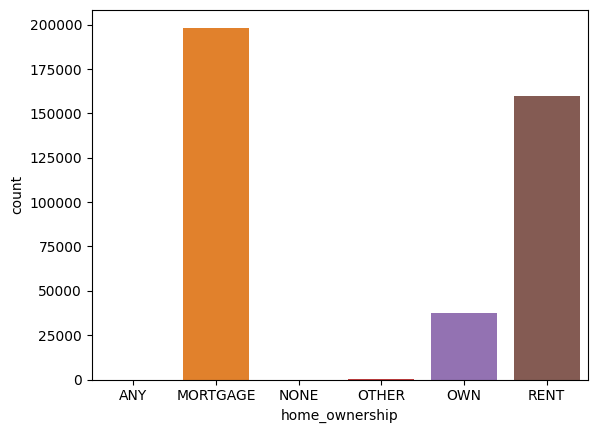

Percentage of data:
home_ownership
MORTGAGE    50.084085
RENT        40.347953
OWN          9.531096
OTHER        0.028281
NONE         0.007828
ANY          0.000758
Name: count, dtype: float64


In [79]:
analyze_cat_variable(data, 'home_ownership')

Observations:
1. Most of the customers have home ownership as Mortgage (50%) followed by RENT (40%).
2. There are only 9.5% of customers with home ownership as OWN.

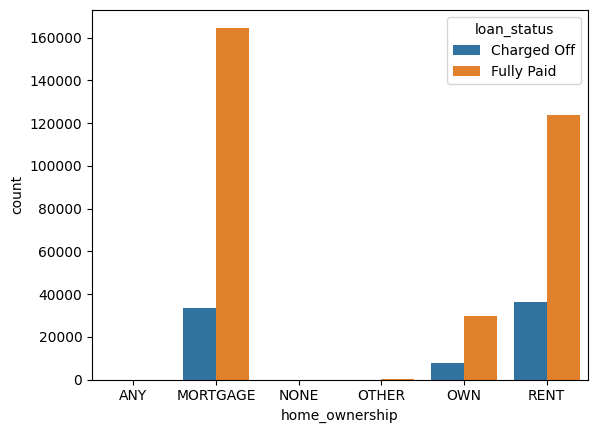

In [80]:
analyze_cat_variable(data, 'home_ownership', hue = 'loan_status')

Observations:
1. MORTGAGE: A significant number of customers have ‘Fully Paid’, with fewer ‘Charged Off’, suggesting better loan performance among homeowners with mortgages.
2. OWN: The numbers of ‘Charged Off’ and ‘Fully Paid’ customers are almost equal, with a slight edge to ‘Fully Paid’.
3. RENT: A large number of renters have ‘Fully Paid’ their loans compared to those who have been ‘Charged Off’, but the risk of charge-off is still notable.

In [81]:
def analyze_cont_variable(df, x, hue = None, kde = False, plot_size = None, xtick_rotate = None, 
                          box_plt_size = None, box_xtick_rotate = None):
    """
    This function uses seaboard and matplotlib to create hisplot and boxplot for continuous variables
    """
    plt.figure(figsize = plot_size)
    sns.histplot(data = df, x = x, kde = kde, hue = hue)
    plt.xticks(rotation = xtick_rotate)
    plt.show()
    if hue:
        plt.figure(figsize = box_plt_size)
        plt.subplot(1,2,1)
        sns.boxplot(data = df, y = x)
        plt.subplot(1,2,2)
        sns.boxplot(data = df, x = hue, y = x)
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.4,hspace=0.4)
        plt.xticks(rotation = box_xtick_rotate)
        plt.show()
    

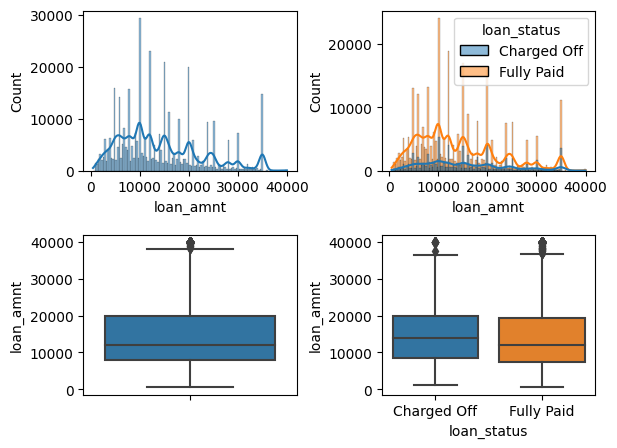

In [82]:
analyze_cont_variable_plts(data, 'loan_amnt',kde = True, hue = 'loan_status')

Observations:
1. There are outliers in the loan_amnt.
2. There is a slight difference in the median loan_amnts between the Charged Off and Fully Paid groups.

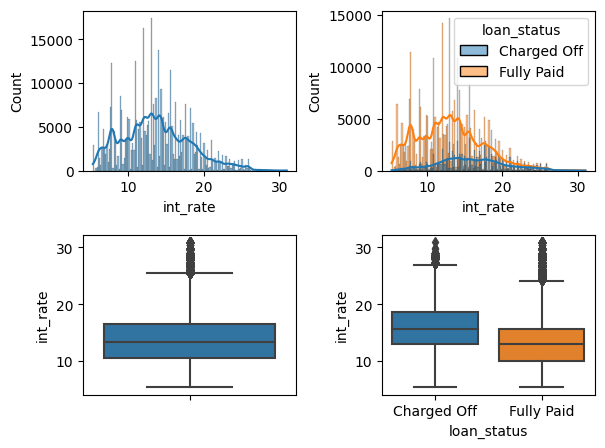

In [83]:
analyze_cont_variable_plts(data, 'int_rate',kde = True, hue = 'loan_status')

Observations:
1. There are outliers in the int_rate.
2. The median int_rate of Charged Off group is higher than the median int_rate of Fully Paid groups.
3. This could mean that higher interest rates might be a risky indicator.

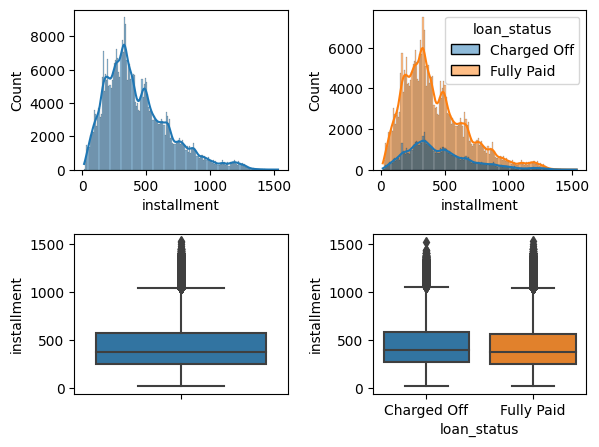

In [84]:
analyze_cont_variable_plts(data, 'installment',kde = True, hue = 'loan_status')

Observations:
1. The installment variable is right skewed. Most of the customers have installments in the range of 100 to 500.
2. The boxplot shows that there is a very small difference in the median installments of Charged Off and Fully Paid groups. The difference is not significant. This indicates that there is no correlation between the installment and the loan status. We can further test the correlation using the point biserial correlation coefficient statistical test.

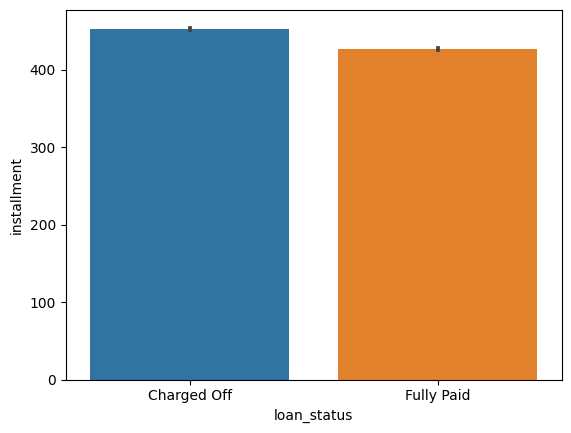

In [85]:
sns.barplot(data = data, y = 'installment', x = 'loan_status')
plt.show()

Observations:
1. The barplot shows that the customers for whom the loan was charged off have slightly increased installment than those that paid. But the difference is not very significant. This can be confirmed through statistical test.

Performing hypothesis testing between loan status and installments

In [86]:
# Reference: https://www.statology.org/correlation-between-continuous-categorical-variables/


H0 = "There is no correlation between installment and loan status."
H1 = "There is a correlation between installment and loan status."
alpha = 0.05

# converting the loan status into 0 for Charged Off and 1 for Fully Paid
loan_status = np.array([1 if i == 'Fully Paid' else 0 for i in data['loan_status']])

# values of installment.
installment = np.array(data['installment'].tolist())

# calculate point-biserial correlation
correlation, p_value = pointbiserialr(loan_status, installment)

print(f'Correlation: {correlation}, P-value: {p_value}')

if p_value <= alpha:
    print("Rejected Null Hypothesis")
    print("Result: ",H1)
else:
    print("Failed to reject Null Hypothesis")
    print("Result: ",H0)

Correlation: -0.04108213720234179, P-value: 1.684401143174276e-147
Rejected Null Hypothesis
Result:  There is a correlation between installment and loan status.


Observations:
1. The dataset shows a very week negative correlation between installment and Loan status of -0.041. The p-value is significantly lower than the alpha = 0.05. The point biserial correlation test confirmed that there is infact a correlation between the installment and loan status.

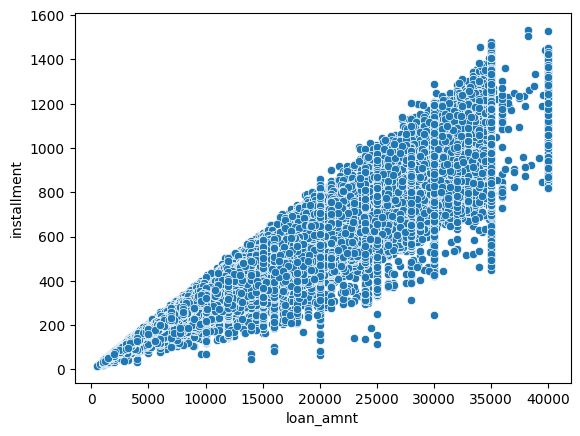

In [87]:
sns.scatterplot(data = data, x = 'loan_amnt', y = 'installment')
plt.show()

Observations:
1. There is a positive correlation between the loan amount and installments. This indicates that borrowers with larger loan amounts tend to have higher installment payments.
2. The loan_amnt ranges from close to 0 to 40,000, and the installment on the y-axis ranges from close to 0 to 1,600. The concentration of data points increases with the loan amount, suggesting that higher loans are common.
3. The scatter plot indicates variability in the installments as the loan amount increases. This variability means that for higher loan amounts, the installment amounts are not consistent and can vary widely among different borrowers.
4. Some possible reasons for this observation:
    - Interest Rates: Borrowers may have different interest rates based on their creditworthiness, which affects the installment amount.
    - Loan Terms: Different loan terms (e.g., length of the loan) can result in different installment amounts for the same loan amount.
    - Borrower’s Creditworthiness: Borrowers with better credit scores may receive more favorable loan conditions, leading to lower installments.

Performing hypothesis testing between loan amount and installment

In [88]:

H0 = "There is no correlation between installment and loan amount."
H1 = "There is a correlation between installment and loan amount."
alpha = 0.05

# converting the loan status into 0 for Charged Off and 1 for Fully Paid
loan_amount = np.array(data['loan_amnt'].tolist())

# values of installment.
installment = np.array(data['installment'].tolist())

# calculate point-biserial correlation
correlation, p_value = pearsonr(loan_amount, installment)

print(f'Correlation: {correlation}, P-value: {p_value}')

if p_value < alpha:
    print("Rejected Null Hypothesis.")
    print("Result: ",H1)
else:
    print("Failed to reject Null Hypothesis")
    print("Result: ",H0)

Correlation: 0.9539289082615551, P-value: 0.0
Rejected Null Hypothesis.
Result:  There is a correlation between installment and loan amount.


Observations:
1. There is a significant correlation between the installment and loan amount.
2. This confirms there is some multicollinearity in the dataset.

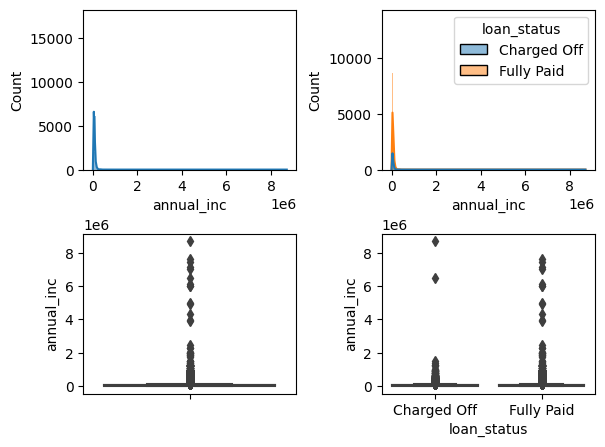

In [89]:
analyze_cont_variable_plts(data, 'annual_inc',kde = True, hue = 'loan_status')

Observations:
1. There are a lot of outliers in the annual_inc.
2. There are extreme outliers in annual_inc in the Charges Off group and there are outliers in Fully Paid group.

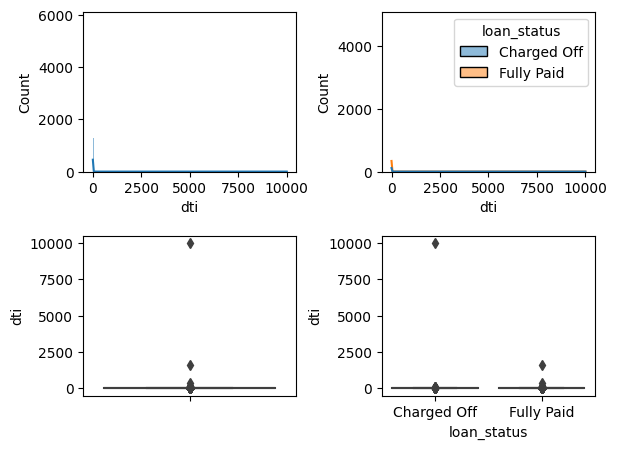

In [90]:
analyze_cont_variable_plts(data, 'dti',kde = True, hue = 'loan_status')

Observations:
1. There are some extreme outliers in the dti.

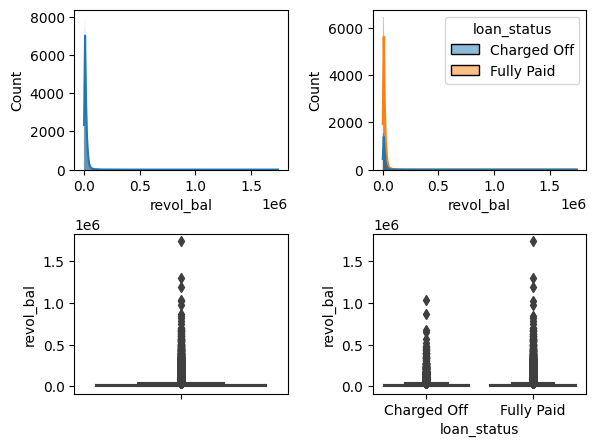

In [91]:
analyze_cont_variable_plts(data, 'revol_bal',kde = True, hue = 'loan_status')

Observations:
1. There are lot of outliers in the revol_bal in both groups.

There are 276 missing values in revol_util.


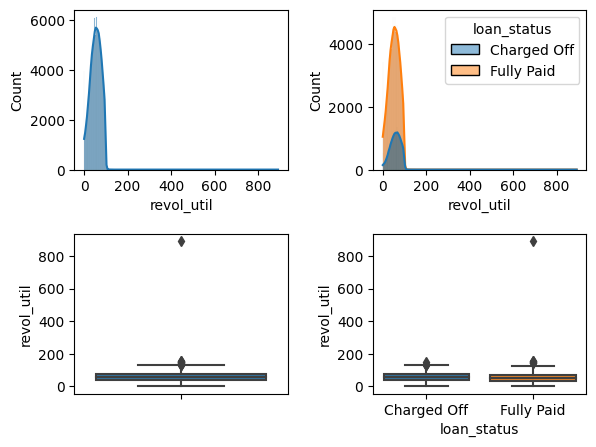

In [92]:
analyze_cont_variable_plts(data, 'revol_util',kde = True, hue = 'loan_status')

Obeservations:
1. There are outliers in revol_util. The Fully Paid group has an extreme outlier for revol_util feature.

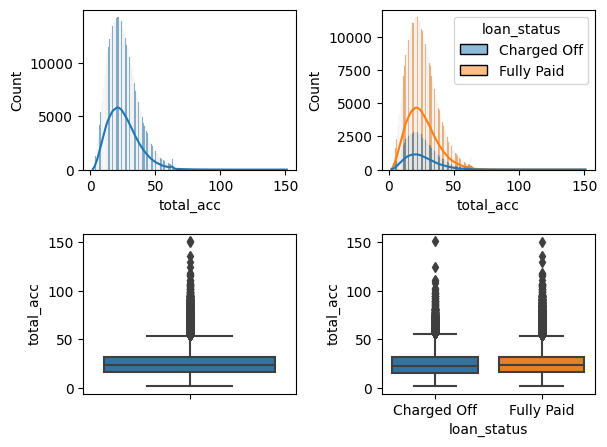

In [93]:
analyze_cont_variable_plts(data, 'total_acc',kde = True, hue = 'loan_status')

Observations:
1. There are outliers in the total_acc feature.

There are 37795 missing values in mort_acc.


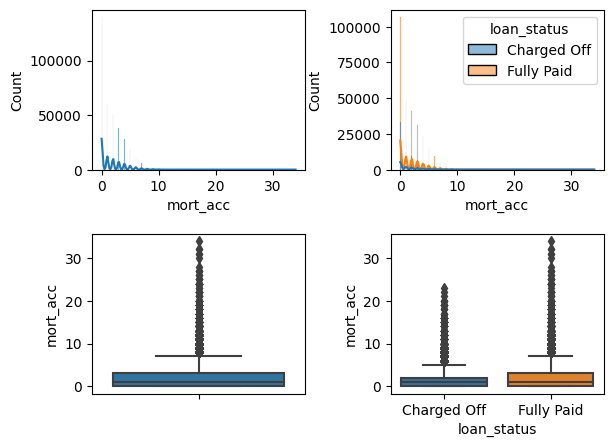

In [94]:
analyze_cont_variable_plts(data, 'mort_acc',kde = True, hue = 'loan_status')

Outliers:
1. There are outliers in the mort_acc feature.

### Correlations

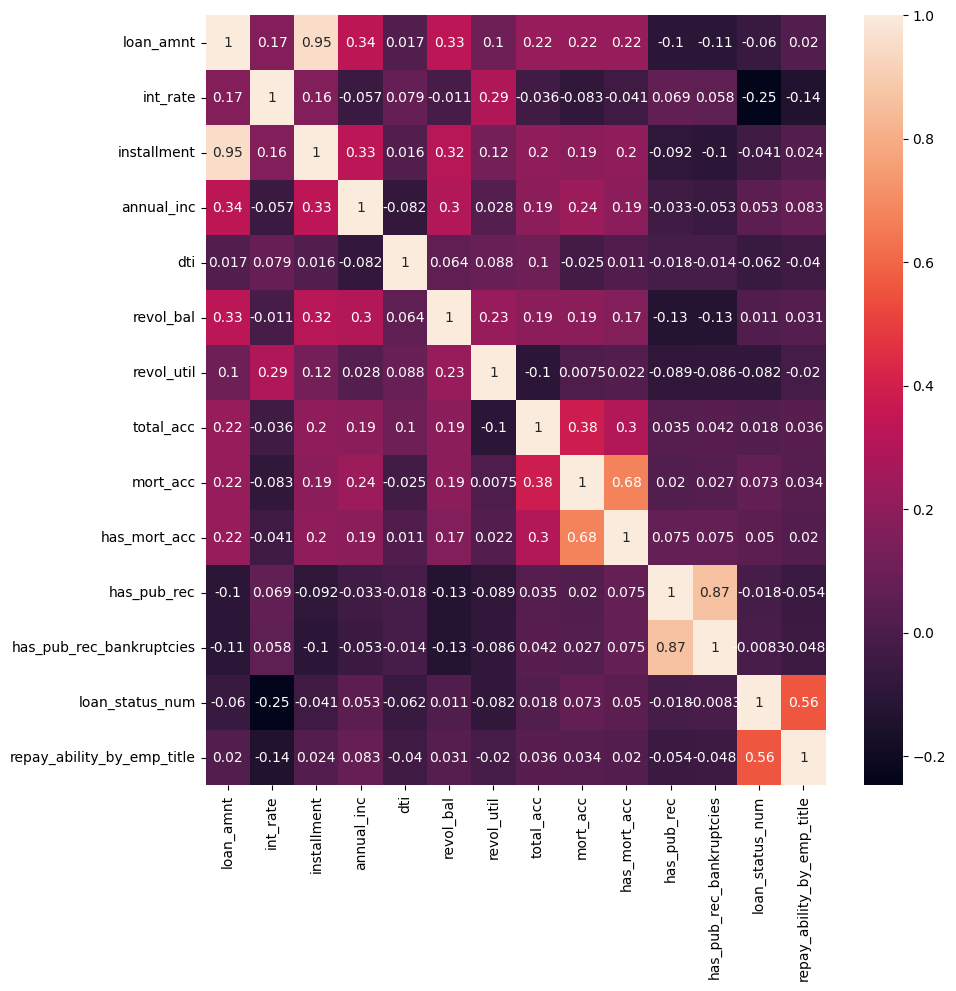

In [95]:
plt.figure(figsize = (10,10))
sns.heatmap(data.select_dtypes(exclude = 'category').corr(),annot = True)
plt.show()

Observations:
1. The loan_amnt and installment have a strong positive correlation between each other.
2. The repay_ability_by_emp_title and loan_status has a positive corelation between each other.
3. The pub_rec and pub_rec_bankruptcies have a strong positive correlation between each other.

## Checing for duplicates

In [96]:
data.duplicated().sum()

0

Observations:
1. There are no duplicate data points in the dataset.

## Handling Missing data

In [97]:
data.isnull().sum() / data.shape[0] * 100

loan_amnt                     0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_title                     5.789208
emp_length                    4.621115
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
purpose                       0.000000
title                         0.443401
dti                           0.000000
earliest_cr_line              0.000000
open_acc                      0.000000
pub_rec                       0.000000
revol_bal                     0.000000
revol_util                    0.069692
total_acc                     0.000000
initial_list_status           0.000000
application_type              0.000000
mort_acc                      9.543469
pub_rec_bankruptcies     

Observations:
1. emp_title is missing 5.79% (categorical)
2. emp_length is missing 4.62% (categorical)
3. title is missing 0.44% (categorical)
4. revol_util is missing 0.07% (numerical)
5. mort_acc is missing 9.54% (numerical)
6. pub_rec_bankruptcies is missing 0.14% (categorical)

<Figure size 5000x5000 with 0 Axes>

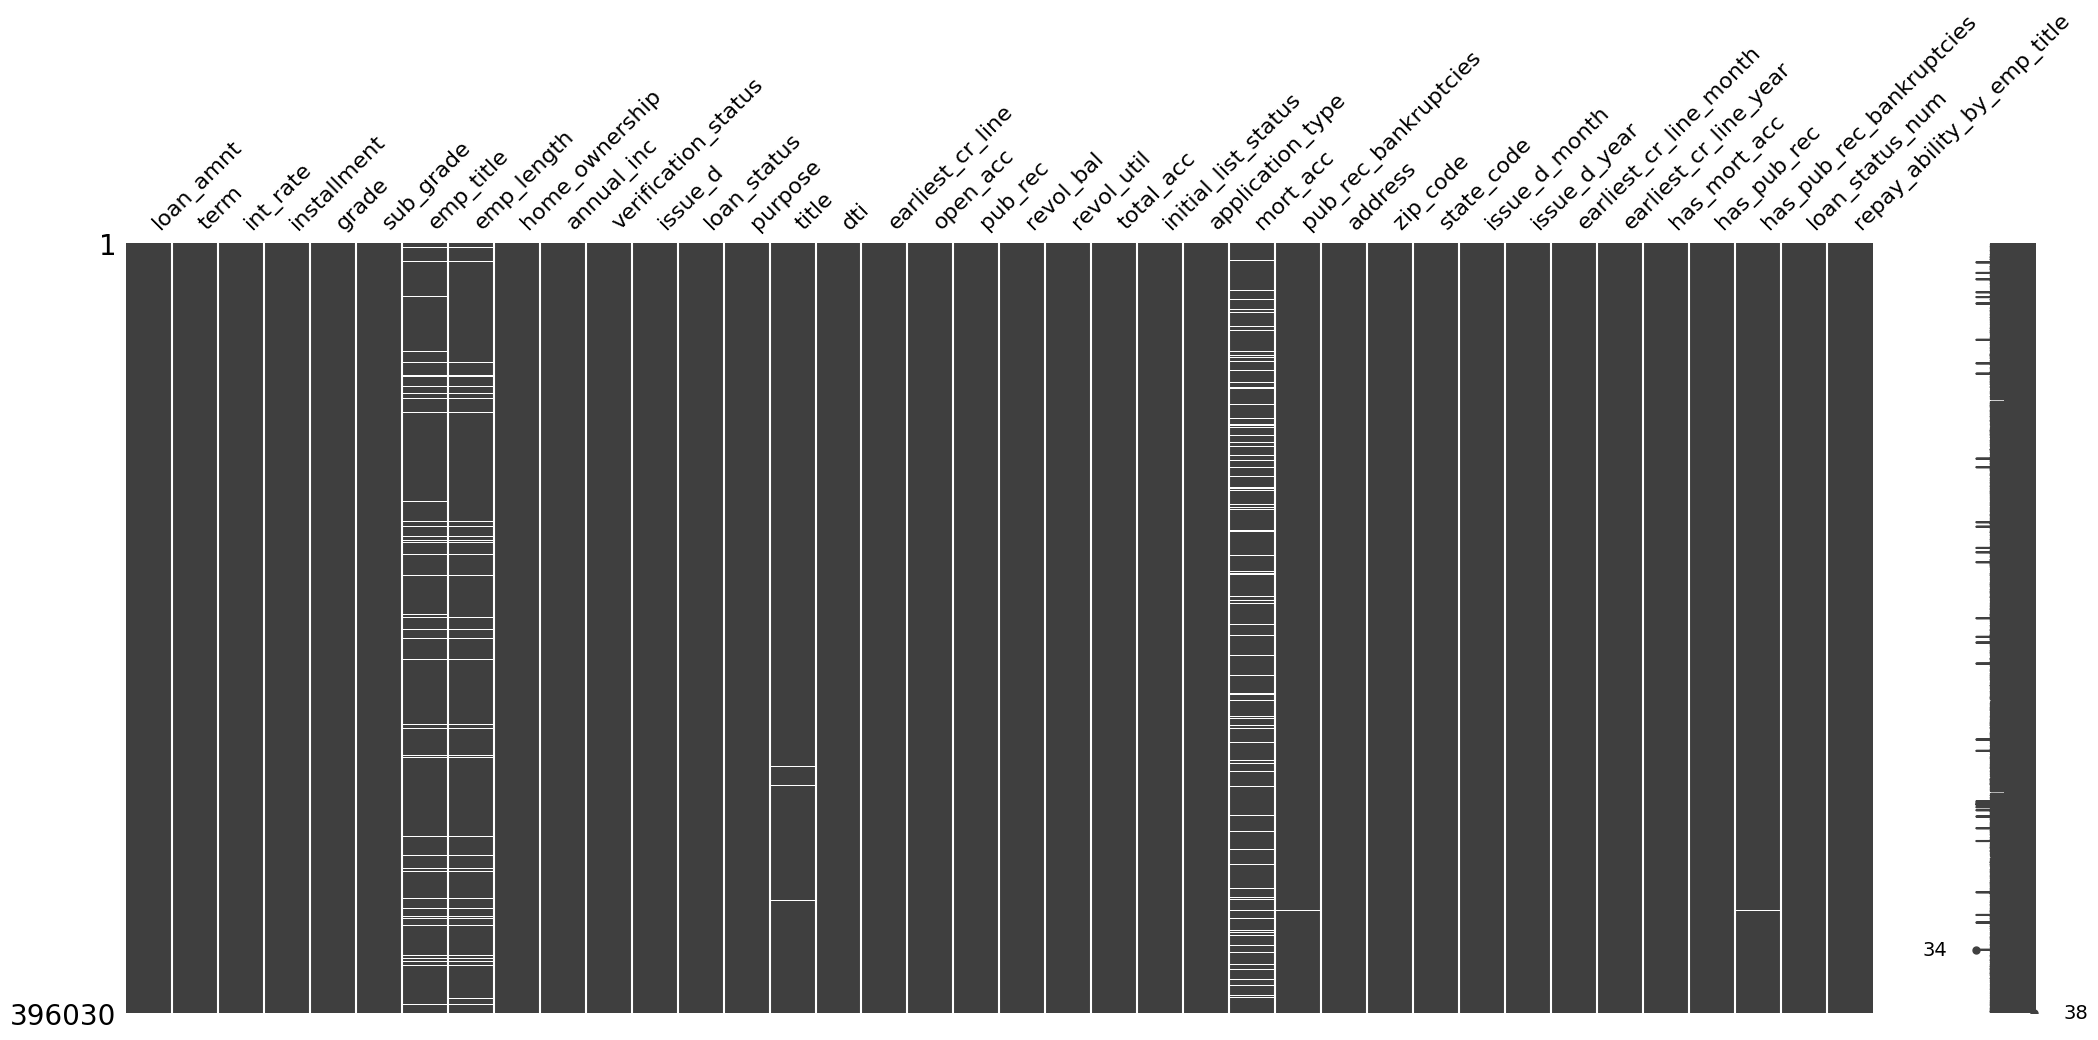

In [98]:
# Creating a missingno matrix to visually inspect the missing data pattern
plt.figure(figsize = (50,50))
msno.matrix(data)
plt.show()

Observations:
1. The matrix clearly shows a pattern in the missing values for 'emp_title' and 'emp_length'. Most of the 'emp_length' are missing for those borrowers for whom the 'emp_title' is missing.

<Figure size 5000x5000 with 0 Axes>

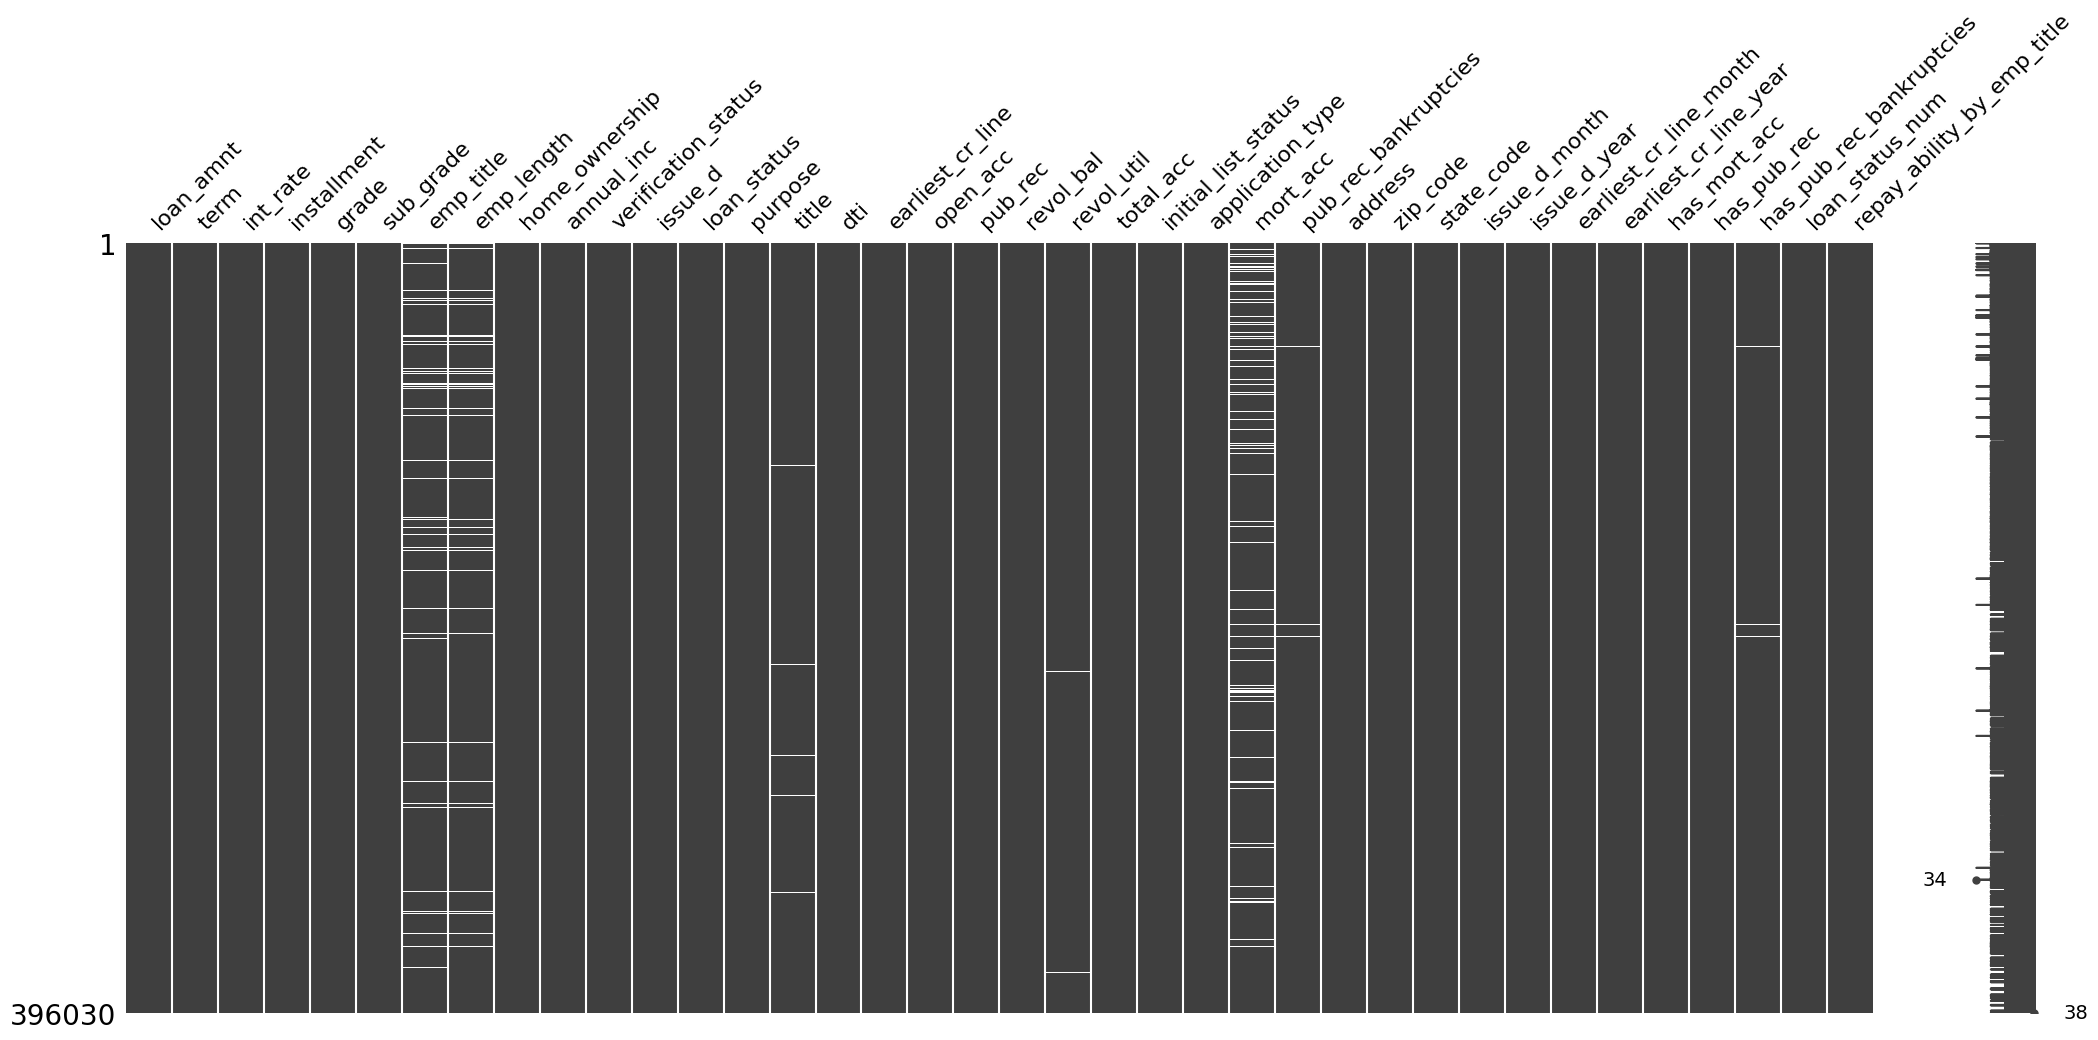

In [99]:
# Creating a missingno matrix to visually inspect the missing data pattern
plt.figure(figsize = (50,50))
msno.matrix(data.sort_values('installment'))
plt.show()

Observations:
1. The 'mort_acc' seem to be missing more data for lower installment. There seems to be an association between installment and mort_acc.

In [100]:
var1 = data[data['mort_acc'].isnull()]['installment']
var2 = data[~data['mort_acc'].isnull()]['installment']
ttest_ind(var1, var2, alternative = 'less')

Ttest_indResult(statistic=-77.32915444858045, pvalue=0.0)

Observations:
1. Based on the t-test of independence (gives a p value of 0), we can say that there is a statistically significant difference in the mean installment amount for borrowers missing 'mort_acc' vs not missing 'mort_acc'.
2. In fact, the mean installment amount of borrowers whose mort_acc is missing is lesser than the mean installment amount of borrowers whose mort_acc is not missing.

In [101]:
data.loc[:,'mort_acc_missing'] = data['mort_acc'].isna()

In [102]:
pd.crosstab(data['mort_acc_missing'], data['home_ownership'], margins = True)

home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,All
mort_acc_missing,,,,,,,
False,3,181706,29,34,34779,141684,358235
True,0,16642,2,78,2967,18106,37795
All,3,198348,31,112,37746,159790,396030


Observations:
1. Mortgage Holders: A significant number of individuals with a mortgage have reported their mortgage accounts.
2. Renters: A considerable number of renters have also reported their mortgage accounts, but there is a notable portion where 'mort_acc' data is missing.
3. Other Categories: The 'ANY', 'NONE', 'OTHER', and 'OWN' categories have fewer instances, but it seems that missing data is less prevalent among these groups compared to 'MORTGAGE' and 'RENT'.
4. This suggests that there might be a pattern in the missingness of 'mort_acc' related to the home ownership status, which could be further investigated for insights. 

In [103]:
# Performing the chi-square test
chi2, p, dof, expected = chi2_contingency(pd.crosstab(data['mort_acc_missing'], data['home_ownership']).values)
print(f"Chi-square Statistic : {chi2} , p-value: {p}")

Chi-square Statistic : 1490.1824510155157 , p-value: 0.0


Observations:
1. The chi2 test shows there is a statistically significant association between home_ownership and missing instances of mort_acc.

##### Strategy to impute the missing data

1. emp_title is missing 5.79% (categorical) - Replace the missing value with 'unknown' because missing value in emp_title may mean something about the defaulters.
2. emp_length is missing 4.62% (categorical) - Use '-1' to impute the missing values.
3. title is missing 0.44% (categorical) - Replace the missing values with 'unknown'.
4. revol_util is missing 0.07% (numerical) - Create a new feature to flag the missing values, then use median to impute.
5. mort_acc is missing 9.54% (numerical) - Create a new feature to flag the missing values. then use  median to impute.
6. pub_rec_bankruptcies is missing 0.14% (categorical) - Create a new feature to flag the missing values. then use mode to impute.

In [104]:
# Adding new values to the categories
data['emp_title'] = data['emp_title'].cat.add_categories('unknown')
data['title'] = data['title'].cat.add_categories('unknown')
data['emp_length'] = data['emp_length'].cat.add_categories('-1')

In [105]:
#Creating new values to flag the missing data
data.loc[:,'missing_revol_util'] = data['revol_util'].isnull()
data.loc[:,'missing_pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].isnull()

In [106]:
# Imputing using fillna
data.loc[:,['emp_title', 'title']] = data[['emp_title', 'title']].fillna('unknown')
data.loc[:,'emp_length'] = data['emp_length'].fillna('-1')

In [107]:
data.isnull().sum()

loan_amnt                           0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                           0
emp_length                          0
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
loan_status                         0
purpose                             0
title                               0
dti                                 0
earliest_cr_line                    0
open_acc                            0
pub_rec                             0
revol_bal                           0
revol_util                        276
total_acc                           0
initial_list_status                 0
application_type                    0
mort_acc                        37795
pub_rec_bankruptcies              535
address     

In [108]:
# Imputing using fillna
#imputing missing value in revol_util with medians. Using 'Fully Paid' and 'Charged Off' groups from loan status
data.loc[data['loan_status']=='Fully Paid','revol_util']  = data.loc[data['loan_status']=='Fully Paid','revol_util']
                            .fillna(data.loc[data['loan_status']=='Fully Paid','revol_util'].median())
data.loc[data['loan_status']=='Charged Off','revol_util'] = data.loc[data['loan_status']=='Charged Off','revol_util']
                            .fillna(data.loc[data['loan_status']=='Charged Off','revol_util'].median())

#imputing missing value in mort_acc with medians. Using 'Fully Paid' and 'Charged Off' groups from loan status
data.loc[data['loan_status']=='Fully Paid','mort_acc']  = data.loc[data['loan_status']=='Fully Paid','mort_acc']
                            .fillna(data.loc[data['loan_status']=='Fully Paid','mort_acc'].median())
data.loc[data['loan_status']=='Charged Off','mort_acc'] = data.loc[data['loan_status']=='Charged Off','mort_acc']
                            .fillna(data.loc[data['loan_status']=='Charged Off','mort_acc'].median())

#imputing missing value in pub_rec_bankruptcies with medians. Using 'Fully Paid' and 'Charged Off' groups from loan status
data.loc[data['loan_status']=='Fully Paid','pub_rec_bankruptcies']  
                        = data.loc[data['loan_status']=='Fully Paid','pub_rec_bankruptcies']
                        .fillna(data.loc[data['loan_status']=='Fully Paid','pub_rec_bankruptcies'].mode().values[0])
data.loc[data['loan_status']=='Charged Off','pub_rec_bankruptcies'] 
                        = data.loc[data['loan_status']=='Charged Off','pub_rec_bankruptcies']
                        .fillna(data.loc[data['loan_status']=='Charged Off','pub_rec_bankruptcies'].mode().values[0])

#Update has_pub_rec_bankruptcies
data['has_pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 1 if x > 0 else 0)

In [109]:
data.isnull().sum()

loan_amnt                       0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_title                       0
emp_length                      0
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
purpose                         0
title                           0
dti                             0
earliest_cr_line                0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                      0
total_acc                       0
initial_list_status             0
application_type                0
mort_acc                        0
pub_rec_bankruptcies            0
address                         0
zip_code                        0
state_code                      0
issue_d_month 

Observations:
1. The following fetures can be label encoded:
    - grade, subgrade, emp_length, home_ownership, verification_status, issue_d_month, earliest_cr_line_month, mort_acc_missing, missing_revol_util, missing_mort_acc, missing_pub_rec_bankruptcies
2. The following features can be target encoded:
    - emp_title, purpose, title, initial_list_status, application_type, state_code,
3. Drop the following features:
    - Drop loan_amt due to its correlation with installment.
    - Drop address feature since the state_code and zip_code are extracted.
    - Drop issue_d feature since the month and year data are extracted.
    - Drop earliest_cr_line feature since the month and year data are extracted.
    - Drop loan_status since the encoded version is loan_status_num.
4. The following are already numerical values:
    - term, pub_rec, open_acc, pub_rec_bankruptcies, 

In [110]:
df = data.copy() # taking a copy of the dataset to work on

# loan_status is converted into numeric as loan_status_num
df = df.drop(['loan_amnt', 'address', 'issue_d', 'earliest_cr_line', 'loan_status'], axis = 1)

## Handling Outliers

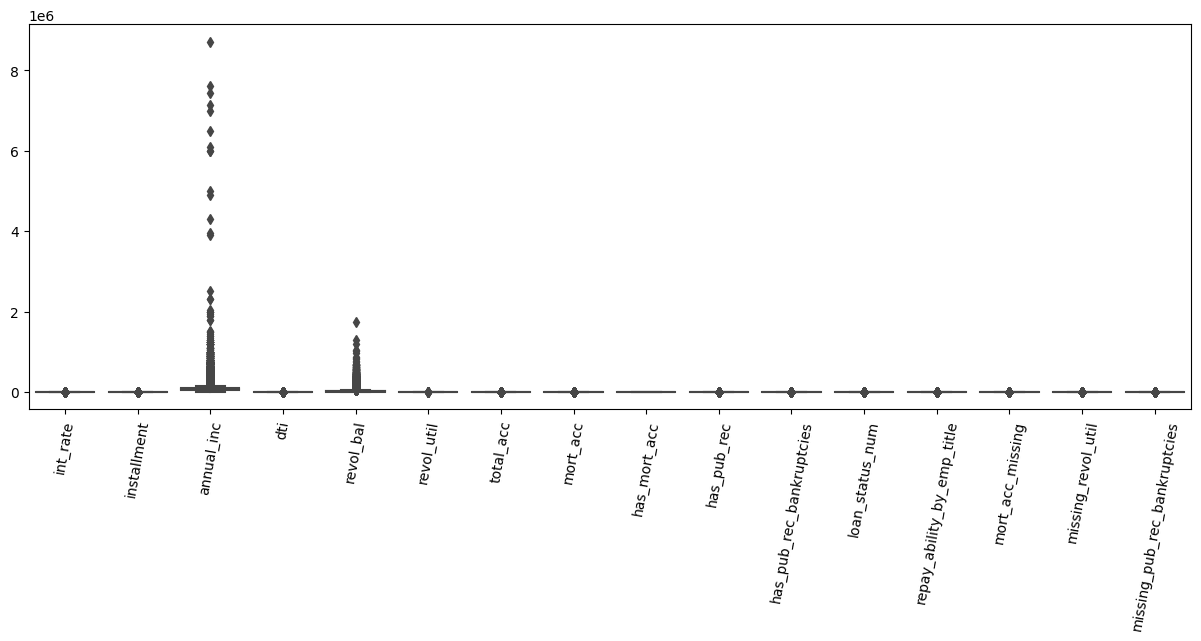

In [111]:
plt.figure(figsize = (15,5))
sns.boxplot(df)
plt.xticks(rotation = 80)
plt.show()

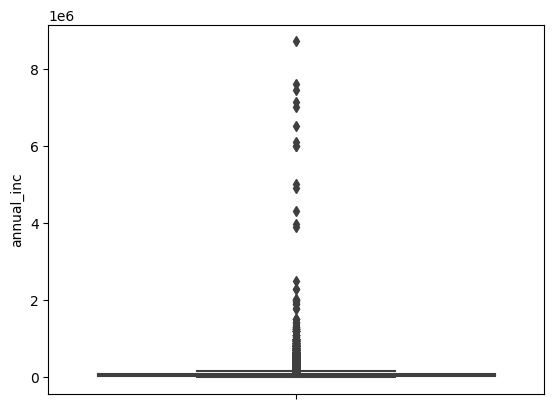

In [112]:
sns.boxplot(df, y = 'annual_inc')
plt.show()

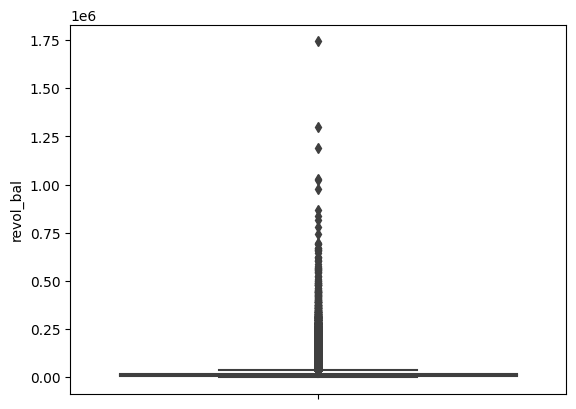

In [113]:
sns.boxplot(df, y = 'revol_bal')
plt.show()

In [114]:
np.percentile(df['annual_inc'],75),  np.percentile(df['revol_bal'],75)

(90000.0, 19620.0)

In [115]:
df['annual_inc'].max(), df['revol_bal'].max()

(8706582.0, 1743266.0)

In [116]:
def get_outliers(dataset, feature):
    """
    This function identifies the outliers in the data using the IQR method
    """
    Q1 = np.percentile(dataset[feature],25)
    Q3 = np.percentile(dataset[feature],75)

    IQR = Q3 - Q1
    
    lb = Q1 - (IQR * 1.5)
    ub = Q3 + (IQR * 1.5)

    outliers = dataset.loc[(dataset[feature] < lb) | (dataset[feature] > ub)]
    non_outliers = dataset.loc[(dataset[feature] > lb) & (dataset[feature] < ub)]
    return outliers, non_outliers
    
    

In [117]:
d_outliers_ann, d_non_outliers_ann = get_outliers(df, 'annual_inc')
d_outliers_rev, d_non_outliers_rev = get_outliers(df, 'revol_bal')

In [118]:
print(f"Number of outliers using annual income: {d_outliers_ann.shape[0]}")
print(f"Number of outliers using total credit revolving balance: {d_outliers_rev.shape[0]}")

Number of outliers using annual income: 16700
Number of outliers using total credit revolving balance: 21259


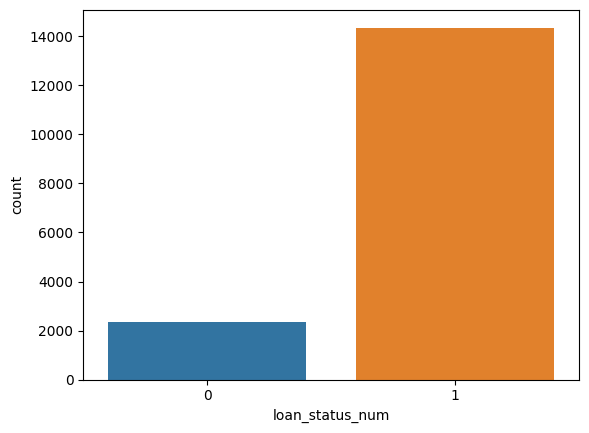

In [119]:
sns.countplot(data = d_outliers_ann, x = 'loan_status_num')
plt.show()

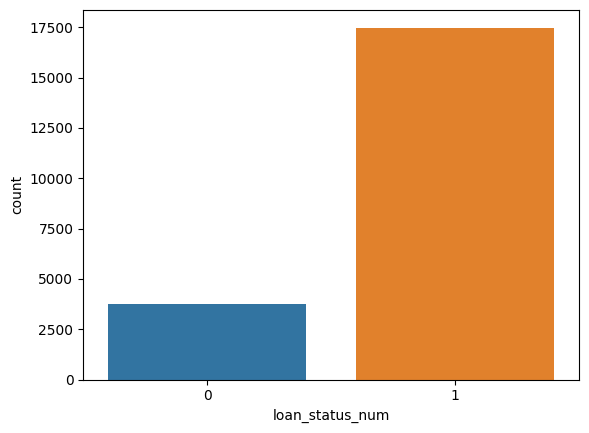

In [120]:
sns.countplot(data = d_outliers_rev, x = 'loan_status_num')
plt.show()

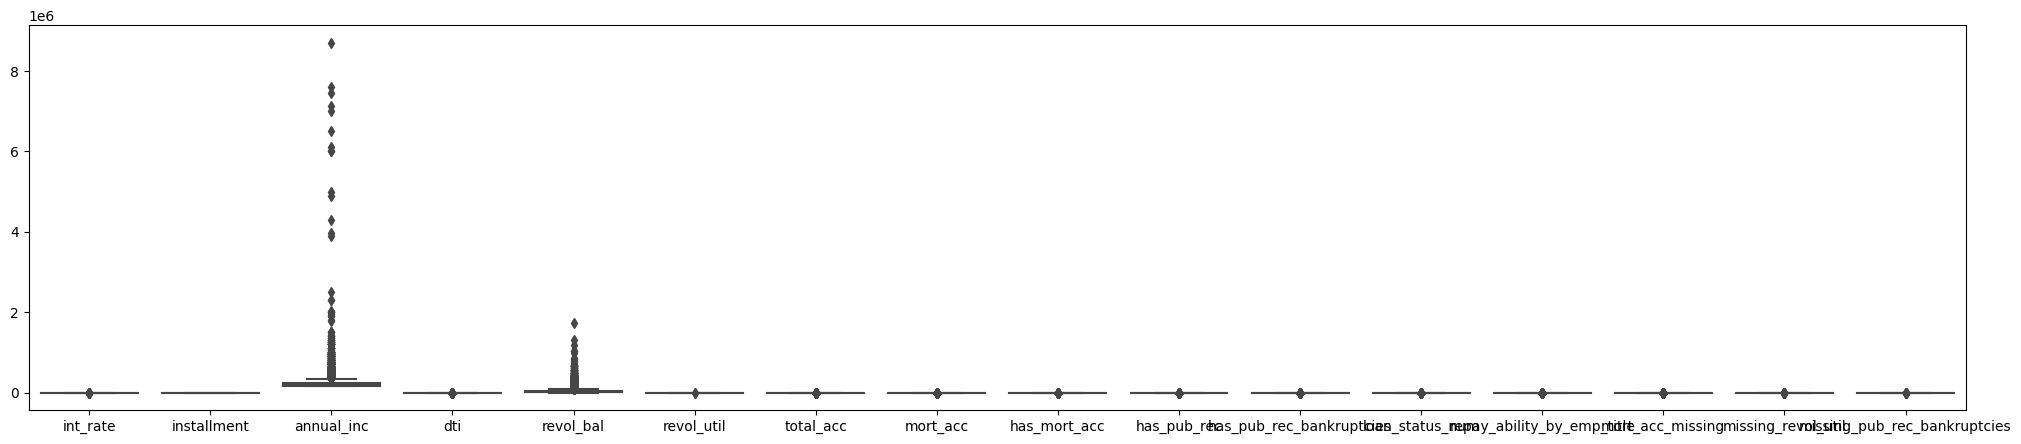

In [121]:
plt.figure(figsize = (25,5))
sns.boxplot(d_outliers_ann)
plt.show()

Onservations:
1. Both annual_inc and revol_bal have considerable number of Fully Paid and Charged Off customers. Removing these outliers means that we will lose valuable data.
2. Customers with high annual income might indicate creditworthiness and customers with high revol_bal may indicate credit risk. These two information are crucial for our model.
3. Instead of removing the outliers, a robust scaling technique can be used that can reduce the impact of the outliers.

## Preparing the data for modelling

### Encoding Scaling the dataset

In [122]:
# splitting the predictors and target variables.
X = df.drop(['loan_status_num'], axis = 1)
y = df['loan_status_num']

In [123]:
#Converting the categorical features into numeric for data preparation for model
X['open_acc'] = X['open_acc'].astype('float64')
X['term'] = X['term'].astype('float64')
X['pub_rec'] = X['pub_rec'].astype('float64')
X['pub_rec_bankruptcies'] = X['pub_rec_bankruptcies'].astype('float64')
X['zip_code'] = X['zip_code'].astype('float64')
X['issue_d_year'] = X['issue_d_year'].astype('float64')
X['earliest_cr_line_year'] = X['earliest_cr_line_year'].astype('float64')

In [124]:
# Spliting data into training data, evaluation data and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)
print(f"Number of training datapoints: {x_train.shape}")
print(y_train.value_counts(), end = "\n")
print(f"Number of evaluation datapoints: {x_eval.shape}")
print(y_eval.value_counts(), end = "\n")
print(f"Number of testing datapoints: {x_test.shape}")
print(y_test.value_counts())

Number of training datapoints: (253459, 35)
loan_status_num
1    203749
0     49710
Name: count, dtype: int64
Number of evaluation datapoints: (63365, 35)
loan_status_num
1    50937
0    12428
Name: count, dtype: int64
Number of testing datapoints: (79206, 35)
loan_status_num
1    63671
0    15535
Name: count, dtype: int64


In [125]:
# Label encoding
label_encoders_dict = {}
for feature in ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d_month',
                'earliest_cr_line_month', 'mort_acc_missing', 'missing_revol_util', 'missing_pub_rec_bankruptcies']:
    label_encoders_dict[feature] = LabelEncoder()
    x_train[feature] = label_encoders_dict.get(feature).fit_transform(x_train[feature])
    x_eval[feature] = label_encoders_dict.get(feature).transform(x_eval[feature])
    x_test[feature] = label_encoders_dict.get(feature).transform(x_test[feature])

In [126]:
#Target Encoding
target_encoders_dict = {}
for feature in ['emp_title', 'purpose', 'title', 'initial_list_status', 'application_type', 'state_code']:
    target_encoders_dict[feature] = TargetEncoder()
    x_train[feature] = target_encoders_dict.get(feature).fit_transform(x_train[[feature]],y_train)
    x_eval[feature] = target_encoders_dict.get(feature).transform(x_eval[[feature]])
    x_test[feature] = target_encoders_dict.get(feature).transform(x_test[[feature]])

### Handling Multicollinearity

Since we are using LogisticRegression which is a linear model, removing multicollinearity is curial

In [127]:
#calculate Variance Inflation Factor

def perform_vif(ind_vars_df, vif_limit = 10, verify_with_f1 = True):
    """
    This function performs VIF analysis with or without F1 score verification and 
    removes the features with high VIF score to reduce multicollinearity in the dataset.
    """
    vif_x_train = ind_vars_df.copy()
    max_vif = 11
    prev_f1 = 0
    curr_f1 = 0
    #Trains a Logistic Regression model with the available features and checks F1 score before removing the features
    if verify_with_f1:
        print(f"Performing initial f1 score ckeck with all features for LogisticRegression model.")
        lr = LogisticRegression(max_iter = 100000)
        lr.fit(vif_x_train, y_train)
        prev_f1 = metrics.f1_score(lr.predict(vif_x_train), y_train)
    #Performs VIF analysis and removes the features with high VIF score
    while max_vif > vif_limit:
        vif_scores = pd.DataFrame()
        vif_scores["Attribute"] = vif_x_train.columns
        # calculating VIF for each feature 
        vif_scores["VIF Scores"] = [variance_inflation_factor(vif_x_train.values, i) for i in range(len(vif_x_train.columns))]
        max_vif = vif_scores['VIF Scores'].max()
        max_attrb = vif_scores.loc[vif_scores['VIF Scores'] == vif_scores['VIF Scores'].max(),'Attribute'].values[0]
        #dropping feature with high vif score
        vif_x_train.drop([max_attrb], axis = 1, inplace = True)
        #checking F1 score if verify_with_f1 is True
        if verify_with_f1:
            print(f"Checking f1 score of LogisticRegression model if {max_attrb} is removed from the data.")
            lr = LogisticRegression(max_iter = 100000)
            lr.fit(vif_x_train, y_train)
            curr_f1 = metrics.f1_score(lr.predict(vif_x_train), y_train)

            if curr_f1 <= prev_f1:
                # df._append(df2, ignore_index = True)
                print(f"F1 score reduces from {prev_f1} to {curr_f1}. Hence stopping the opperation.")
                vif_scores._append({'Attribute':max_attrb,'VIF Scores':max_vif}, ignore_index = True)
                break
            else:
                print(f"F1 score is improving from {prev_f1} to {curr_f1}. Hence continuing the operation.")
                prev_f1 = curr_f1
        print(f"Dropped {max_attrb}")

    display(vif_scores)
    print(f"Selected features are:\n {vif_scores['Attribute'].tolist()}")

In [128]:
perform_vif(x_train)

Performing initial f1 score ckeck with all features for LogisticRegression model.
Checking f1 score of LogisticRegression model if issue_d_year is removed from the data.
F1 score reduces from 0.905779511299759 to 0.9053695792524624. Hence stopping the opperation.


,Attribute,VIF Scores
0,term,25.004097
1,int_rate,247.810097
2,installment,5.462856
3,grade,64.925191
4,sub_grade,176.465192
5,emp_title,41.645613
6,emp_length,3.059441
7,home_ownership,5.528591
8,annual_inc,2.999931
9,verification_status,3.115157


Selected features are:
 ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'state_code', 'issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year', 'has_mort_acc', 'has_pub_rec', 'has_pub_rec_bankruptcies', 'repay_ability_by_emp_title', 'mort_acc_missing', 'missing_revol_util', 'missing_pub_rec_bankruptcies']


In [129]:
perform_vif(x_train, verify_with_f1 = False)

Dropped issue_d_year
Dropped earliest_cr_line_year
Dropped initial_list_status
Dropped application_type
Dropped state_code
Dropped purpose
Dropped int_rate
Dropped sub_grade
Dropped title
Dropped emp_title
Dropped term
Dropped has_pub_rec_bankruptcies
Dropped total_acc
Dropped open_acc


,Attribute,VIF Scores
0,installment,5.371481
1,grade,3.445703
2,emp_length,2.945774
3,home_ownership,4.248806
4,annual_inc,2.932364
5,verification_status,3.008827
6,dti,5.987109
7,open_acc,6.800912
8,pub_rec,3.091064
9,revol_bal,2.076336


Selected features are:
 ['installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'issue_d_month', 'earliest_cr_line_month', 'has_mort_acc', 'has_pub_rec', 'repay_ability_by_emp_title', 'mort_acc_missing', 'missing_revol_util', 'missing_pub_rec_bankruptcies']


In [130]:
features = ['installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'issue_d_month', 'earliest_cr_line_month', 'has_mort_acc', 'has_pub_rec', 'repay_ability_by_emp_title', 'mort_acc_missing', 'missing_revol_util', 'missing_pub_rec_bankruptcies']
x_train_vif = x_train[features]
x_eval_vif = x_eval[features]
x_test_vif = x_test[features]

In [131]:
features1 = ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code', 'state_code', 'issue_d_month', 'earliest_cr_line_month', 'earliest_cr_line_year', 'has_mort_acc', 'has_pub_rec', 'has_pub_rec_bankruptcies', 'repay_ability_by_emp_title', 'mort_acc_missing', 'missing_revol_util', 'missing_pub_rec_bankruptcies']
x_train_vif1 = x_train[features1]
x_eval_vif1 = x_eval[features1]
x_test_vif1 = x_test[features1]

In [132]:
# using RobustScaler to scale the data since the data has too many outliers
sc = RobustScaler()
x_train_sc = sc.fit_transform(x_train)
x_eval_sc = sc.transform(x_eval)
x_test_sc = sc.transform(x_test)

sc_vif = RobustScaler()
x_train_vif_sc = sc.fit_transform(x_train_vif)
x_eval_vif_sc = sc.transform(x_eval_vif)
x_test_vif_sc = sc.transform(x_test_vif)

sc_vif1 = RobustScaler()
x_train_vif_sc1 = sc.fit_transform(x_train_vif1)
x_eval_vif_sc1 = sc.transform(x_eval_vif1)
x_test_vif_sc1 = sc.transform(x_test_vif1)

In [133]:
def evaluation(model, x, y, pos_label = 1):
    """
    This functions uses the sklearn library to perform model evaluations for a classification model
    """
    pres = metrics.precision_score(model.predict(x), y, pos_label = pos_label)
    recal = metrics.recall_score(model.predict(x), y, pos_label = pos_label)
    f1 = metrics.f1_score(model.predict(x), y, pos_label = pos_label)
    print("Precision: ",pres)
    print("Recall: ",recal)
    print("F1 Score: ",f1)
    tn, fp, fn, tp = metrics.confusion_matrix(y, model.predict(x)).ravel()
    print(f"True Positives:{tp}\tFalse Positives: {fp}\nTrue Negatives:{tn}\tFalse Negatives:{fn}")
    print("Classification Matrics:\n ",metrics.classification_report(model.predict(x), y))
    return pres, recal, f1

In [134]:
base_model_logr = LogisticRegression(max_iter = 100000, class_weight = 'balanced')
base_model_logr.fit(x_train_sc, y_train)

base_model_logr_vif = LogisticRegression(max_iter = 100000)
base_model_logr_vif.fit(x_train_vif_sc, y_train)

base_model_logr_vif1 = LogisticRegression(max_iter = 100000)
base_model_logr_vif1.fit(x_train_vif_sc1, y_train)

LogisticRegression(max_iter=100000)

In [135]:
print("Train scores for all features:")
evaluation(base_model_logr, x_train_sc, y_train, pos_label = 1)
print("-"*60)
print("Train scores for VIF features:")
evaluation(base_model_logr_vif, x_train_vif_sc, y_train, pos_label = 1)
print("-"*60)
print("Train scores for VIF with f1 score check features:")
evaluation(base_model_logr_vif1, x_train_vif_sc1, y_train, pos_label = 1)

Train scores for all features:
Precision:  0.858453293022297
Recall:  0.9472820523929962
F1 Score:  0.9006828153000063
True Positives:174909	False Positives: 9734
True Negatives:39976	False Negatives:28840
Classification Matrics:
                precision    recall  f1-score   support

           0       0.80      0.58      0.67     68816
           1       0.86      0.95      0.90    184643

    accuracy                           0.85    253459
   macro avg       0.83      0.76      0.79    253459
weighted avg       0.84      0.85      0.84    253459

------------------------------------------------------------
Train scores for VIF features:
Precision:  0.9571875199387482
Recall:  0.9013874894852146
F1 Score:  0.928449862060265
True Positives:195026	False Positives: 21336
True Negatives:28374	False Negatives:8723
Classification Matrics:
                precision    recall  f1-score   support

           0       0.57      0.76      0.65     37097
           1       0.96      0.90      

(0.9585224958159304, 0.9044463277621092, 0.9306995806328633)

In [136]:
print("Evaluation scores for all features:")
evaluation(base_model_logr, x_eval_sc, y_eval, pos_label = 1)
print("-"*60)
print("Evaluation scores for VIF features:")
evaluation(base_model_logr_vif, x_eval_vif_sc, y_eval, pos_label = 1)
print("-"*60)
print("Evaluation scores for VIF with f1 score check features:")
evaluation(base_model_logr_vif1, x_eval_vif_sc1, y_eval, pos_label = 1)

Evaluation scores for all features:
Precision:  0.8612992520171977
Recall:  0.9464759562487864
F1 Score:  0.9018809744064138
True Positives:43872	False Positives: 2481
True Negatives:9947	False Negatives:7065
Classification Matrics:
                precision    recall  f1-score   support

           0       0.80      0.58      0.68     17012
           1       0.86      0.95      0.90     46353

    accuracy                           0.85     63365
   macro avg       0.83      0.77      0.79     63365
weighted avg       0.84      0.85      0.84     63365

------------------------------------------------------------
Evaluation scores for VIF features:
Precision:  0.9576339399650549
Recall:  0.9007293878681563
F1 Score:  0.9283104327636738
True Positives:48779	False Positives: 5376
True Negatives:7052	False Negatives:2158
Classification Matrics:
                precision    recall  f1-score   support

           0       0.57      0.77      0.65      9210
           1       0.96      0.90

(0.9595578852307752, 0.9039076803580345, 0.9309018188743928)

In [137]:
print("Test scores for all features:")
evaluation(base_model_logr, x_test_sc, y_test, pos_label = 1)
print("-"*60)
print("Test scores for VIF features:")
evaluation(base_model_logr_vif, x_test_vif_sc, y_test, pos_label = 1)
print("-"*60)
print("Test scores for VIF with f1 score check features:")
evaluation(base_model_logr_vif1, x_test_vif_sc1, y_test, pos_label = 1)

Test scores for all features:
Precision:  0.8608471674702769
Recall:  0.9484348774030559
F1 Score:  0.9025209530552766
True Positives:54811	False Positives: 2980
True Negatives:12555	False Negatives:8860
Classification Matrics:
                precision    recall  f1-score   support

           0       0.81      0.59      0.68     21415
           1       0.86      0.95      0.90     57791

    accuracy                           0.85     79206
   macro avg       0.83      0.77      0.79     79206
weighted avg       0.85      0.85      0.84     79206

------------------------------------------------------------
Test scores for VIF features:
Precision:  0.9573118060027328
Recall:  0.902365725113993
F1 Score:  0.9290270463880993
True Positives:60953	False Positives: 6595
True Negatives:8940	False Negatives:2718
Classification Matrics:
                precision    recall  f1-score   support

           0       0.58      0.77      0.66     11658
           1       0.96      0.90      0.93  

(0.9589294969452341, 0.9056200774262448, 0.9315127011976504)

##### Feature selection using Recurrent Feature Elimination

In [138]:

logreg_model = LogisticRegression(max_iter = 10000, class_weight = 'balanced')

# Initialize the RFE object with the logistic regression model
# Specify the number of features you want to select (e.g., 5)

rfe = RFE(estimator = logreg_model, n_features_to_select = None)

# Fit RFE to your data
rfe.fit(x_train_vif_sc, y_train)

# Get the selected features
selected_features = x_train_vif.columns[rfe.support_]
features_ranks = rfe.ranking_
# Print the selected features
print("Selected features:")
print(selected_features)
print("Feature Ranks:")
print(features_ranks)

Selected features:
Index(['installment', 'grade', 'emp_length', 'home_ownership',
       'verification_status', 'dti', 'mort_acc', 'zip_code',
       'repay_ability_by_emp_title', 'mort_acc_missing',
       'missing_pub_rec_bankruptcies'],
      dtype='object')
Feature Ranks:
[ 1  1  1  1  9  1  1  3  6  8  2  1  5  1 11 12  7 10  1  1  4  1]


In [139]:
x_train_rfe_vif = x_train[selected_features]
x_eval_rfe_vif = x_eval[selected_features]
x_test_rfe_vif = x_test[selected_features]

In [140]:
sc_rfe_vif = RobustScaler()
x_train_rfe_vif_sc = sc_rfe_vif.fit_transform(x_train_rfe_vif)
x_eval_rfe_vif_sc = sc_rfe_vif.transform(x_eval_rfe_vif)
x_test_rfe_vif_sc = sc_rfe_vif.transform(x_test_rfe_vif)

In [141]:
base_model_logr_rfe_vif = LogisticRegression(max_iter = 100000, class_weight = 'balanced')
base_model_logr_rfe_vif.fit(x_train_rfe_vif_sc, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

In [142]:
print("Train scores for features selected by vif and rfe:")
evaluation(base_model_logr_rfe_vif, x_train_rfe_vif_sc, y_train, pos_label = 1)

Train scores for features selected by vif and rfe:
Precision:  0.8550127853388237
Recall:  0.9442731002932424
F1 Score:  0.8974288967076897
True Positives:174208	False Positives: 10281
True Negatives:39429	False Negatives:29541
Classification Matrics:
                precision    recall  f1-score   support

           0       0.79      0.57      0.66     68970
           1       0.86      0.94      0.90    184489

    accuracy                           0.84    253459
   macro avg       0.82      0.76      0.78    253459
weighted avg       0.84      0.84      0.83    253459



(0.8550127853388237, 0.9442731002932424, 0.8974288967076897)

In [143]:
print("Evaluation scores for features selected by vif and rfe:")
evaluation(base_model_logr_rfe_vif, x_eval_rfe_vif_sc, y_eval, pos_label = 1)

Evaluation scores for features selected by vif and rfe:
Precision:  0.856175275340126
Recall:  0.9433892878774769
F1 Score:  0.8976689137034941
True Positives:43611	False Positives: 2617
True Negatives:9811	False Negatives:7326
Classification Matrics:
                precision    recall  f1-score   support

           0       0.79      0.57      0.66     17137
           1       0.86      0.94      0.90     46228

    accuracy                           0.84     63365
   macro avg       0.82      0.76      0.78     63365
weighted avg       0.84      0.84      0.83     63365



(0.856175275340126, 0.9433892878774769, 0.8976689137034941)

In [144]:
print("Test scores for features selected by vif and rfe:")
evaluation(base_model_logr_rfe_vif, x_test_rfe_vif_sc, y_test, pos_label = 1)

Test scores for features selected by vif and rfe:
Precision:  0.8557742143204913
Recall:  0.9452993528911712
F1 Score:  0.8983117910841467
True Positives:54488	False Positives: 3153
True Negatives:12382	False Negatives:9183
Classification Matrics:
                precision    recall  f1-score   support

           0       0.80      0.57      0.67     21565
           1       0.86      0.95      0.90     57641

    accuracy                           0.84     79206
   macro avg       0.83      0.76      0.78     79206
weighted avg       0.84      0.84      0.84     79206



(0.8557742143204913, 0.9452993528911712, 0.8983117910841467)

## Hyperparameter Tuning

Combining train and eval datasets together to perform Cross-validattion for hyperparameter tuning

In [146]:
#Dataset with features selection from RFE + VIF analysis(with F1 score check)
x_trainingset_rfe_vif_sc = np.vstack([x_train_rfe_vif_sc, x_eval_rfe_vif_sc])

#Dataset with features selection VIF analysis(without F1 score check)
x_trainingset_vif_sc = np.vstack([x_train_vif_sc, x_eval_vif_sc])

#Dataset with features selection from VIF analysis(with F1 score check)
x_trainingset_vif_sc1 = np.vstack([x_train_vif_sc1, x_eval_vif_sc1])

#Dataset with all the features
x_trainingset_sc = np.vstack([x_train_sc, x_eval_sc])

#Labels for training
y_trainingset = pd.concat([y_train, y_eval])

Performing Hyperparameter tuning

In [381]:
# Datasets
data_dict = {'ref_vif' : x_trainingset_rfe_vif_sc, 
            'vif': x_trainingset_vif_sc, 
             'vif_f1' : x_trainingset_vif_sc1, 
             'all_features' : x_trainingset_sc}

best_params_dict = dict()
best_scores_dict = dict()

#Performing hyperparameter tuning with different datasets
for k,v in data_dict.items():
    print(f"Running GridSearchCV for {k}")
    #model
    logreg = LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 42)
    #hyperparameters
    param_grid = {
        'solver': ['sag', 'saga', 'newton-cholesky'],
        'penalty': ['l1', 'l2', 'elasticnet'],
         'C': [0.5, 1.0, 1.5],
        'tol': [0.001, 0.0001, 0.00001],
        'l1_ratio' : [0, 0.25 , 0.5, 0.75, 1]
    }
    #stratified kfold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    #performing hyperparameter tuning
    logreg_cv = GridSearchCV(logreg, param_grid, cv=skf, n_jobs = -1, scoring = 'f1_weighted')
    logreg_cv.fit(v, y_trainingset)
    
    print(f"Result with {k} data:")
    print("Tuned Logistic Regression Parameters:" , logreg_cv.best_params_)
    print("Best score is" , logreg_cv.best_score_)
    print("CV results:" , logreg_cv)
    best_params_dict[k] = logreg_cv.best_params_
    best_scores_dict[k] = logreg_cv.best_score_


Running GridSearchCV for ref_vif
Result with ref_vif data:
Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}
Best score is 0.8517500870134593
CV results: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.5, 1.0, 1.5],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['sag', 'saga', 'newton-cholesky'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='f1_weighted')
Running GridSearchCV for vif
Result with vif data:
Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
Best score is 0.8519449796197339
CV results: 

Observations:
1. Hyperparameter tuning with features selected via RFE and VIF using GridSearchCV with weighted F1 score:
    - Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}
    - Best score is 0.8517500870134593
    - estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,random_state=42)
2. Hyperparameter tuning with features selected via VIF(eliminated all features with vif_score > 10) using GridSearchCV with weighted F1 score:
    - Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
    - Best score is 0.8519449796197339
    - estimator=LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
3. Hyperparameter tuning with features selected via VIF(feature elimination verified with F1 score) using GridSearchCV with weighted F1 score:
    - Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'newton-cholesky', 'tol': 0.001}
    - Best score is 0.8570254763998747
    - estimator=LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
4. Hyperparameter tuning with all the features using GridSearchCV with weighted F1 score:
    - Tuned Logistic Regression Parameters: {'C': 0.5, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'newton-cholesky', 'tol': 0.001}
    - Best score is 0.8566847136717867
    - estimator=LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

## Final models with best hyperparameters

In [147]:
def evaluation(xtrain = None, ytrain = None, xtest = None, ytest = None, ytrain_preds = None , 
               ypreds = None,model = None, test_only = False, pos_label = 1):
    """
    This fuction uses the sklearn library to evaluate a classification model.
    This function is capable of performing evaluations with training data as well as test data with the passed model.
    This function is capable of performing evaluation for test data alone when the predictions are passed and 'test_data'
    parameter is set to True. When test_data is True, do not pass a model but pass the predictions.
    """
    #Perform is model is passed
    if model:
        if test_only == False:
            train_pres = metrics.precision_score( ytrain, model.predict(xtrain), pos_label = pos_label)
            train_recal = metrics.recall_score( ytrain, model.predict(xtrain), pos_label = pos_label)
            train_f1 = metrics.f1_score( ytrain, model.predict(xtrain), pos_label = pos_label, average = 'weighted')
            train_tn, train_fp, train_fn, train_tp = metrics.confusion_matrix(ytrain, model.predict(xtrain)).ravel()
            traing_accuracy = metrics.balanced_accuracy_score(ytrain, model.predict(xtrain))
        
        test_pres = metrics.precision_score(ytest, model.predict(xtest), pos_label = pos_label)
        test_recal = metrics.recall_score(ytest, model.predict(xtest), pos_label = pos_label)
        test_f1 = metrics.f1_score(ytest, model.predict(xtest), pos_label = pos_label, average = 'weighted')
        test_tn, test_fp, test_fn, test_tp = metrics.confusion_matrix(ytest, model.predict(xtest)).ravel()
        test_accuracy = metrics.balanced_accuracy_score(ytest, model.predict(xtest))
        print(f"Model Evaluation Results for {model.__class__.__name__}:")
        print("-"*50)
    #perform if model is not passed
    else:
        if test_only == False:
            train_pres = metrics.precision_score( ytrain, ytrain_preds, pos_label = pos_label)
            train_recal = metrics.recall_score( ytrain, ytrain_preds, pos_label = pos_label)
            train_f1 = metrics.f1_score( ytrain, ytrain_preds, pos_label = pos_label, average = 'weighted')
            train_tn, train_fp, train_fn, train_tp = metrics.confusion_matrix(ytrain, ytrain_preds).ravel()
            traing_accuracy = metrics.balanced_accuracy_score(ytrain, ytrain_preds)

        test_pres = metrics.precision_score(ytest, ypreds, pos_label = pos_label)
        test_recal = metrics.recall_score(ytest, ypreds, pos_label = pos_label)
        test_f1 = metrics.f1_score(ytest, ypreds, pos_label = pos_label, average = 'weighted')
        test_tn, test_fp, test_fn, test_tp = metrics.confusion_matrix(ytest, ypreds).ravel()
        test_accuracy = metrics.balanced_accuracy_score(ytest, ypreds)
    #Perform if evalueation needs to be done on train and test data 
    if test_only == False:
        print(f"Train data Precision score: {train_pres} | Test data Precision score: {test_pres}")
        print(f"Train data Recall score: {train_recal} | Test data Recall score: {test_recal}")
        print(f"Train data weighted F1 Score: {train_f1} | Test data weighted F1 score: {test_f1}")
        print("-"*120)
        print("Training scores:")
        print("-"*16)
        print(f"True Positives:{train_tp}\tFalse Positives: {train_fp}\nTrue Negatives:{train_tn}\tFalse Negatives:{train_fn}")
        print("-"*120)
        print("Test scores:")
        print("-"*12)
        print(f"True Positives:{test_tp}\tFalse Positives: {test_fp}\nTrue Negatives:{test_tn}\tFalse Negatives:{test_fn}")
        print()
        print("Training data Classification report:")
        print('-'*42)
        #perform if model is passed
        if model:
            print("Classification Matrics:\n ",metrics.classification_report(ytrain, model.predict(xtrain)))
        #perform if model is not passed
        else:
            print("Classification Matrics:\n ",metrics.classification_report(ytrain, ytrain_preds))
        print("Test data Classification report:")
        print('-'*42)
        #perform if model is passed
        if model:
            print("Classification Matrics:\n ",metrics.classification_report(ytest, model.predict(xtest)))
        #perform if model is not passed
        else:
            print("Classification Matrics:\n ",metrics.classification_report(ytest, ypreds))
    #Perform if only test data needs to be verified against the predictions.. 
    else:
        print(f"Test data Precision score: {test_pres}")
        print(f"Test data Recall score: {test_recal}")
        print(f"Test data weighted F1 score: {test_f1}")
        print("-"*120)
        print("Test scores:")
        print("-"*12)
        print(f"True Positives:{test_tp}\tFalse Positives: {test_fp}\nTrue Negatives:{test_tn}\tFalse Negatives:{test_fn}")
        print()
        print("Test data Classification report:")
        print('-'*42)
        print("Classification Matrics:\n ",metrics.classification_report(ytest, ypreds))
    return test_f1

In [148]:
# Creating model1 with features seelcted via RFE and VIF analysis with the best hyperparameters
logreg_model_rfe_vif_sc = LogisticRegression(class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42,
                                             C = 0.5,
                                             l1_ratio = 0,
                                             penalty = 'l1',
                                             solver = 'saga',
                                             tol = 0.001)

logreg_model_rfe_vif_sc.fit(x_trainingset_rfe_vif_sc, y_trainingset)

evaluation(model = logreg_model_rfe_vif_sc, xtrain = x_trainingset_rfe_vif_sc, 
           ytrain = y_trainingset, xtest = x_test_rfe_vif_sc, ytest = y_test)

Model Evaluation Results for LogisticRegression:
--------------------------------------------------
Train data Precision score: 0.9442486049143437 | Test data Precision score: 0.9455129317826766
Train data Recall score: 0.8550646678655285 | Test data Recall score: 0.855507216786292
Train data weighted F1 Score: 0.8517512732006985 | Test data weighted F1 score: 0.8530382217743578
------------------------------------------------------------------------------------------------------------------------
Training scores:
----------------
True Positives:217773	False Positives: 12858
True Negatives:49280	False Negatives:36913
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:54471	False Positives: 3139
True Negatives:12396	False Negatives:9200

Training data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  f

0.8530382217743578

In [149]:
# Creating model2 with best hyperparameters with features selected by removing features with VIF score > 10

logreg_model_vif_sc = LogisticRegression(class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42,
                                             C = 0.5,
                                             l1_ratio = 0,
                                             penalty = 'l2',
                                             solver = 'sag',
                                             tol = 0.001)

logreg_model_vif_sc.fit(x_trainingset_vif_sc, y_trainingset)

evaluation(model = logreg_model_vif_sc, xtrain = x_trainingset_vif_sc,
           ytrain = y_trainingset, xtest = x_test_vif_sc, 
           ytest = y_test)

Model Evaluation Results for LogisticRegression:
--------------------------------------------------
Train data Precision score: 0.9444654063501563 | Test data Precision score: 0.9460214941750439
Train data Recall score: 0.8550607414620356 | Test data Recall score: 0.8557742143204913
Train data weighted F1 Score: 0.8519209209185987 | Test data weighted F1 score: 0.8536119986323747
------------------------------------------------------------------------------------------------------------------------
Training scores:
----------------
True Positives:217772	False Positives: 12805
True Negatives:49333	False Negatives:36914
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:54488	False Positives: 3109
True Negatives:12426	False Negatives:9183

Training data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  

0.8536119986323747

In [150]:
# Creating model3 with best hyperparameters 
# with features selected by removing features with VIF score > 10 with a check on F1 score

logreg_model_vif_f1_sc = LogisticRegression(class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42,
                                             C = 0.5,
                                             l1_ratio = 0,
                                             penalty = 'l2',
                                             solver = 'newton-cholesky',
                                             tol = 0.001)

logreg_model_vif_f1_sc.fit(x_trainingset_vif_sc1, y_trainingset)

evaluation(model = logreg_model_vif_f1_sc, 
           xtrain = x_trainingset_vif_sc1, ytrain = y_trainingset, 
           xtest = x_test_vif_sc1, 
           ytest = y_test)

Model Evaluation Results for LogisticRegression:
--------------------------------------------------
Train data Precision score: 0.9472403897346221 | Test data Precision score: 0.9485609519856095
Train data Recall score: 0.8592541403924833 | Test data Recall score: 0.8613340453267578
Train data weighted F1 Score: 0.8568164708131205 | Test data weighted F1 score: 0.859207001257712
------------------------------------------------------------------------------------------------------------------------
Training scores:
----------------
True Positives:218840	False Positives: 12189
True Negatives:49949	False Negatives:35846
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:54842	False Positives: 2974
True Negatives:12561	False Negatives:8829

Training data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  f

0.859207001257712

In [151]:
# Creating model4 with best hyperparameters with all the features

logreg_model_sc = LogisticRegression(class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42,
                                             C = 0.5,
                                             l1_ratio = 0,
                                             penalty = 'l2',
                                             solver = 'newton-cholesky',
                                             tol = 0.001)

logreg_model_sc.fit(x_trainingset_sc, y_trainingset)

evaluation(model = logreg_model_sc, xtrain = x_trainingset_sc, 
           ytrain = y_trainingset, xtest = x_test_sc, 
           ytest = y_test)

Model Evaluation Results for LogisticRegression:
--------------------------------------------------
Train data Precision score: 0.9472127299265015 | Test data Precision score: 0.9485483787199418
Train data Recall score: 0.8587083703069662 | Test data Recall score: 0.8605330527241601
Train data weighted F1 Score: 0.8564425163129598 | Test data weighted F1 score: 0.8586785042150897
------------------------------------------------------------------------------------------------------------------------
Training scores:
----------------
True Positives:218701	False Positives: 12188
True Negatives:49950	False Negatives:35985
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:54791	False Positives: 2972
True Negatives:12563	False Negatives:8880

Training data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  

0.8586785042150897

Observations:
1. Model built with features selected after VIF analysis with F1 score check:
    - Model name: logreg_model_vif_f1_sc
    - True Positives:54829	False Positives: 2967
    - True Negatives:12568	False Negatives:8842
    - Test data Precision score: 0.9486
    - Test data Recall score: 0.8611
    - Test data weighted F1 score: 0.8591
2. Model built with all features:
    - Model name: logreg_model_sc
    - True Positives:54786	False Positives: 2970
    - True Negatives:12565	False Negatives:8885
    - Test data Precision score: 0.9485
    - Test data Recall score: 0.8604
    - Test data weighted F1 score: 0.8586
3. Model built with features having VIF scores < 10:
    - Model Name: logreg_model_vif_sc
    - True Positives:54488	False Positives: 3109
    - True Negatives:12426	False Negatives:9183
    - Test data Precision score: 0.9460
    - Test data Recall score: 0.8557
    - Test data weighted F1 score: 0.8536
4. Model built with feature selected via RFE after VIF analysis with F1 score check:
    - Model Name: logreg_model_rfe_vif_sc
    - True Positives:54471	False Positives: 3139
    - True Negatives:12396	False Negatives:9200
    - Test data Precision score: 0.9455
    - Test data Recall score: 0.8555
    - Test data weighted F1 score: 0.8530

## Choosing best threshold

#### ROC AUC curve

In [152]:

#Training the models with train dataset so that threshold can be found using evaluation dataset
logreg_model_vif_f1_sc.fit(x_train_vif_sc1, y_train)
logreg_model_sc.fit(x_train_sc, y_train)
logreg_model_vif_sc.fit(x_train_vif_sc, y_train)
logreg_model_rfe_vif_sc.fit(x_train_rfe_vif_sc, y_train)

#predicting probabilities
preds_vif_sc1 = logreg_model_vif_f1_sc.predict_proba(x_eval_vif_sc1)[:,1]
preds_sc = logreg_model_sc.predict_proba(x_eval_sc)[:,1]
preds_vif_sc = logreg_model_vif_sc.predict_proba(x_eval_vif_sc)[:,1]
preds_rfe_vif_sc = logreg_model_rfe_vif_sc.predict_proba(x_eval_rfe_vif_sc)[:,1]

#getting the fprs, tprs and thresholds from roc_curve()
fpr_vif_sc1, tpr_vif_sc1, thresholds_vif_sc1 = roc_curve(y_eval, preds_vif_sc1)
auc_score_vif_sc1 = roc_auc_score(y_eval, preds_vif_sc1)

fpr_sc, tpr_sc, thresholds_sc = roc_curve(y_eval, preds_sc)
auc_score_sc = roc_auc_score(y_eval, preds_sc)

fpr_vif_sc, tpr_vif_sc, thresholds_vif_sc = roc_curve(y_eval, preds_vif_sc)
auc_score_vif_sc = roc_auc_score(y_eval, preds_vif_sc)

fpr_rfe_vif_sc, tpr_rfe_vif_sc, thresholds_rfe_vif_sc = roc_curve(y_eval, preds_rfe_vif_sc)
auc_score_rfe_vif_sc = roc_auc_score(y_eval, preds_rfe_vif_sc)

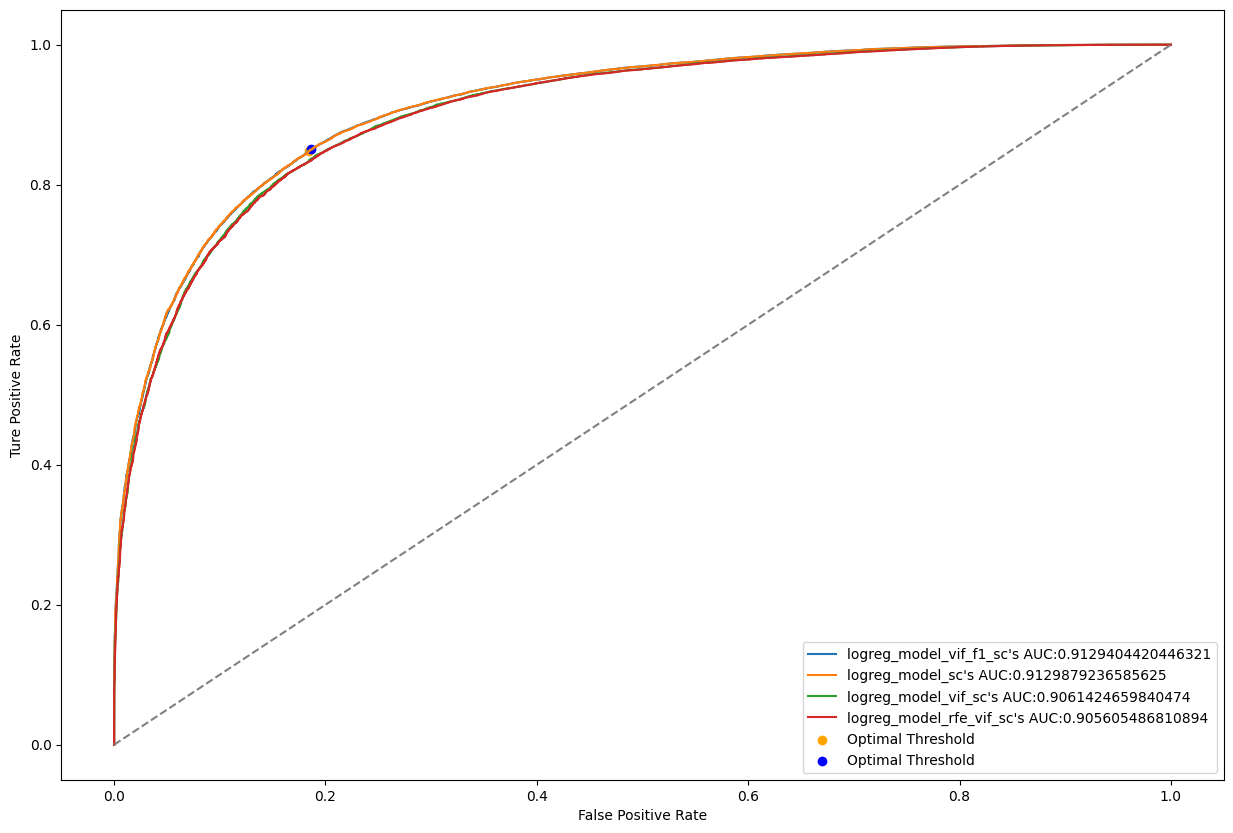

In [153]:
#plotting the tpr-fpr curve for the 4 models
plt.figure(figsize = (15,10))
plt.plot(fpr_vif_sc1, tpr_vif_sc1, label = f"logreg_model_vif_f1_sc's AUC:{auc_score_vif_sc1}")
plt.plot(fpr_sc, tpr_sc, label = f"logreg_model_sc's AUC:{auc_score_sc}")
plt.plot(fpr_vif_sc, tpr_vif_sc, label = f"logreg_model_vif_sc's AUC:{auc_score_vif_sc}")
plt.plot(fpr_rfe_vif_sc, tpr_rfe_vif_sc, label = f"logreg_model_rfe_vif_sc's AUC:{auc_score_rfe_vif_sc}")

#plotting the random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Find the threshold corresponding to the maximum distance
distance_to_top_left = tpr_sc - fpr_sc
optimal_threshold = thresholds_sc[np.argmax(distance_to_top_left)]

# Find the threshold corresponding to the maximum distance
distance_to_top_left_vif_sc1 = tpr_vif_sc1 - fpr_vif_sc1
optimal_threshold_vif_sc1 = thresholds_vif_sc1[np.argmax(distance_to_top_left_vif_sc1)]

#plotting the optimal thresholds
plt.scatter(fpr_sc[np.argmax(distance_to_top_left)], tpr_sc[np.argmax(distance_to_top_left)],
            color='orange', marker='o', label='Optimal Threshold')
plt.scatter(fpr_vif_sc1[np.argmax(distance_to_top_left_vif_sc1)], tpr_vif_sc1[np.argmax(distance_to_top_left_vif_sc1)],
            color='blue', marker='o', label='Optimal Threshold')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('Ture Positive Rate')
plt.show()

In [154]:
optimal_threshold_vif_sc1

0.5252181049243565

##### Performing evaluation of the model using test data with the optimal threshold obtained

In [155]:
#Test predictions
y_probs = logreg_model_vif_f1_sc.predict_proba(x_test_vif_sc1)[:,1]
y_predictions = []
#assigning labels based on the obtained threshold
for proba in y_probs:
    if proba >= optimal_threshold_vif_sc1:
        y_predictions.append(1)
    else:
        y_predictions.append(0)
#evaluatinng the model on test data
evaluation(ytest = y_test, ypreds = y_predictions, test_only  = True)

Test data Precision score: 0.9510328324594433
Test data Recall score: 0.8489108071178402
Test data weighted F1 score: 0.8530877467830367
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:54051	False Positives: 2783
True Negatives:12752	False Negatives:9620

Test data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  f1-score   support

           0       0.57      0.82      0.67     15535
           1       0.95      0.85      0.90     63671

    accuracy                           0.84     79206
   macro avg       0.76      0.83      0.78     79206
weighted avg       0.88      0.84      0.85     79206



0.8530877467830367

Observations:
1. The ROC chart shows the curves for 4 models. The best ROC-AUC is for logreg_model_sc (roc-auc = 0.91298) and logreg_model_vif_f1_sc (roc-auc = 0.912940).
2. The optimal threshold for logreg_model_vif_f1_sc is 0.525.
3. With the optimal threshold, logreg_model_vif_f1_sc model's performance on the test data is as follows:
    - Precision score: 0.95
    - Recall score: 0.84
    - weighted F1 score: 0.8530
4. The False Positives are 2783 and False Negatives are 9620. The ROC-AUC is giving more priority to Positive class. Though we are filtering more customers out from giving loan, we are potentially missing on interest earning opportunity. We need a threshold to slightly reduce the false negatives also and balance out the business opportunity vs risk.
5. Hence, try to find the best threshold using AU-PRC.

### Precision and Recall Curve - for the best model

In [159]:
#Training the model with train dataset so that threshold can be found using evaluation dataset
logreg_model_vif_f1_sc.fit(x_train_vif_sc1, y_train)
prec, recal, thresholds = metrics.precision_recall_curve(y_eval, logreg_model_vif_f1_sc.predict_proba(x_eval_vif_sc1)[:,1])

Best Threshold = 0.47025728405817424, F beta-Score = 0.929020050762479


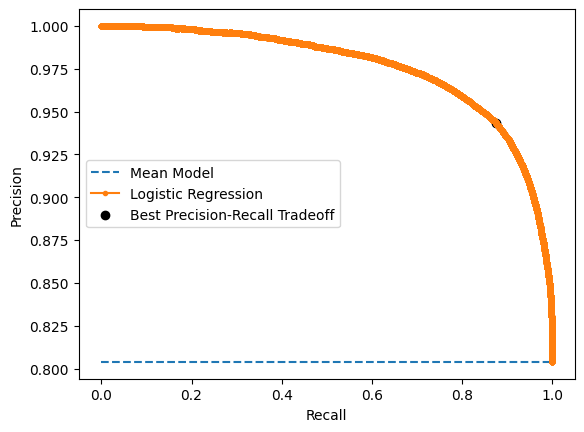

In [160]:
# calculating f-beta score using precision and recall for each threshold
beta = 0.5 #using beta = 0.5 to give more importance to precision so that False positives can be reduced
fbscore = ((1+(beta**2)) * prec * recal) / (((beta**2) * prec) + recal)

# locate the index of the largest f score
max_fb_score_index = np.argmax(fbscore)

#obtaining the best threshold
best_threshold = thresholds[max_fb_score_index]
print(f'Best Threshold = {best_threshold}, F beta-Score = {fbscore[max_fb_score_index]}')

# plot the Precision-Recall curve for the model
#mean model
mean_model = np.mean(y_test)

#plotting the mean model
plt.plot([0,1], [mean_model, mean_model], linestyle='--', label='Mean Model')

#plotting Precision and Recall curve
plt.plot(recal, prec, marker='.', label='Logistic Regression')

#marking the optimal Precision and Recall value
plt.scatter(x = recal[max_fb_score_index], y = prec[max_fb_score_index], 
            marker='o', color='black', label='Best Precision-Recall Tradeoff')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [162]:
best_threshold

0.47025728405817424

##### Model evaluation with optimal threshold using test data

In [161]:
#predicting the probabilities
y_probs = logreg_model_vif_f1_sc.predict_proba(x_test_vif_sc1)[:,1]
y_predictions = []

#assigning the class labels for test data using the obtained threshold
for proba in y_probs:
    if proba >= best_threshold:
        y_predictions.append(1)
    else:
        y_predictions.append(0)

#performing evaluations on test data
evaluation(ytest = y_test, ypreds = y_predictions, test_only  = True)

Test data Precision score: 0.9448752099628429
Test data Recall score: 0.8746525105621084
Test data weighted F1 score: 0.8648516211138485
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:55690	False Positives: 3249
True Negatives:12286	False Negatives:7981

Test data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  f1-score   support

           0       0.61      0.79      0.69     15535
           1       0.94      0.87      0.91     63671

    accuracy                           0.86     79206
   macro avg       0.78      0.83      0.80     79206
weighted avg       0.88      0.86      0.86     79206



0.8648516211138485

Observation:
1. The Precision-Recall curve is charted for the best model found 'logreg_model_vif_f1_sc'.
2. The optimal threshold for  is 0.47.
3. With the optimal threshold, logreg_model_vif_f1_sc model's performance on the test data is as follows:
    - Precision score: 0.945
    - Recall score: 0.875
    - weighted F1 score: 0.865
4. With this threshold, the Precision score slightly reduced by 0.005. However the Recall score increased by 0.035. The weighted F1 score also increase by 0.015.
5. The False Positives are 3249 (previously 2783) and False Negatives are 7981 (previously 9620). The P-R curve is bringing in a balance between the Positive and Negative classes and balance out the business opportunity vs risk.

## Final Training
Training the final model with train + eval datasets

In [165]:
logreg_model_vif_f1_sc.fit(x_trainingset_vif_sc1, y_trainingset)

LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0, n_jobs=-1,
                   random_state=42, solver='newton-cholesky', tol=0.001)

In [168]:
#Getting the feature coefficients
features = x_train_vif1.columns.tolist()
model_coefs = logreg_model_vif_f1_sc.coef_.tolist()[0]

feature_coef_dict = {'Features' : features, 
                     'Model Coefficients' : model_coefs}

Feature_coefs_df = pd.DataFrame(feature_coef_dict)
Feature_coefs_df.sort_values(['Model Coefficients'], ascending = False)

,Features,Model Coefficients
30,repay_ability_by_emp_title,1.453560
1,int_rate,1.060491
31,mort_acc_missing,0.721108
9,verification_status,0.332392
29,has_pub_rec_bankruptcies,0.321621
33,missing_pub_rec_bankruptcies,0.312817
20,mort_acc,0.124499
3,grade,0.083437
17,total_acc,0.061024
15,revol_bal,0.040674


In [258]:
#getting the model intercept
print(f"The model intercept is {logreg_model_vif_f1_sc.intercept_[0]}")

The model intercept is 1.9037790624124944


Observations:
1. Final model for deployment is a LogisticRegression model with selected hyperparameters C = 0.5, class_weight = 'balanced', l1_ratio = 0, n_jobs=-1, random_state=42, solver='newton-cholesky', tol=0.001.
2. The model is built on the following features with model coefficients as:
	- repay_ability_by_emp_title = 1.453560
    - int_rate = 1.060491
    - mort_acc_missing = 0.721108
    - verification_status = 0.332392
    - has_pub_rec_bankruptcies = 0.321621
    - missing_pub_rec_bankruptcies = 0.312817
    - mort_acc = 0.124499
    - grade = 0.083437
    - total_acc = 0.061024
    - revol_bal = 0.040674
    - title = 0.039201
    - purpose = 0.035096
    - state_code = 0.024321
    - application_type = 0.000054
    - earliest_cr_line_month = -0.001302
    - has_mort_acc = -0.001763
    - issue_d_month = -0.003375
    - annual_inc = -0.005279
    - term = -0.025435
    - initial_list_status = -0.028473
    - pub_rec = -0.056411
    - pub_rec_bankruptcies = -0.071987
    - emp_title = -0.096300
    - earliest_cr_line_year = -0.162896
    - open_acc = -0.165612
    - installment = -0.172291
    - has_pub_rec = -0.173714
    - revol_util = -0.209685
    - home_ownership = -0.238283
    - dti = -0.289083
    - missing_revol_util = -0.323095
    - emp_length = -0.329274
    - zip_code = -1.147147
    - sub_grade = -1.751454

## Evaluating the model on test data

In [173]:
best_threshold

0.47025728405817424

In [170]:
#Predicting the probabilities
y_probs = logreg_model_vif_f1_sc.predict_proba(x_test_vif_sc1)[:,1]
y_predictions = []

#assiging class labels with the best model, best hyperparamenter, best threshold on test data
for proba in y_probs:
    if proba >= best_threshold:
        y_predictions.append(1)
    else:
        y_predictions.append(0)

#Evaluating the model on test data
evaluation(ytest = y_test, ypreds = y_predictions, test_only  = True)

Test data Precision score: 0.9450500933944642
Test data Recall score: 0.8740871040190982
Test data weighted F1 score: 0.8646295868133945
------------------------------------------------------------------------------------------------------------------------
Test scores:
------------
True Positives:55654	False Positives: 3236
True Negatives:12299	False Negatives:8017

Test data Classification report:
------------------------------------------
Classification Matrics:
                precision    recall  f1-score   support

           0       0.61      0.79      0.69     15535
           1       0.95      0.87      0.91     63671

    accuracy                           0.86     79206
   macro avg       0.78      0.83      0.80     79206
weighted avg       0.88      0.86      0.86     79206



0.8646295868133945

Observations:
1. Final model performance with the test data:
    - Precision score: 0.9450
    - Recall score: 0.874
    - weighted F1 score: 0.8646
2. The Final model is trained with 316824 datapoints and 34 features ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
   'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'dti', 'open_acc', 'pub_rec',
   'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies',
   'zip_code', 'state_code', 'issue_d_month', 'earliest_cr_line_month', 'earliest_cr_line_year', 'has_mort_acc', 'has_pub_rec',
   'has_pub_rec_bankruptcies', 'repay_ability_by_emp_title', 'mort_acc_missing', 'missing_revol_util','missing_pub_rec_bankruptcies'].
3. The model is a Logistic Regression model with hyperparameters C = 0.5, class_weight = 'balanced', l1_ratio = 0, n_jobs=-1, random_state=42, solver='newton-cholesky', tol=0.001.
4. This model has effectively reduced both False Positives (3236) as well as the False Negatives (8017) than the other models with a probability threshold of 0.47025728405817424.

# Tradeoff Questions

1. **How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.**
   - In the context of credit risk assessment, we want to identify genuine customers (true positives) while minimizing false positives (potential defaulters incorrectly classified as genuine customers). At the same time we dont want to lose any potential genuine customers because out medel misclassified them as potential defaulters (False Negatives) so that we dont miss out on any business opportunities.
   - Here are some strategies to achieve this balance:
     - **Feature Engineering:**
       - Created a new feature that captures the repayment strength of the customers.
     - **Model Selection:**
       - Chose Logistic Regression with clas-weight as 'balanced to handle the imbalanced dataset.
     - **Threshold Adjustment:**
       - Domain expert and business point of contacts can give more requirements around the threshold to be used. A lower threshold increases sensitivity (detects more defaulters) but may lead to more false positives. A higher threshold reduces false positives but may miss some genuine defaulters. In our case, adjusted the classification threshold based on the Precision-Recall Curve. 
     - **Monitoring and Feedback Loop:**
       - Continuously monitor model performance and update it based on real-world outcomes. Regularly validate the model against new data.
     - **Business Rules:**
       - Incorporate domain-specific rules (e.g., minimum credit score, maximum debt-to-income ratio) into the decision-making process.

2. **Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone. **

   - Non-Performing Assets (NPAs) pose a significant risk to lenders. To mitigate this risk:
     - **Threshold adjustment**:
       - We have adjusted the threshold of our model to reduce the false positives thus increasing the model's ability to detect True Negatives (defaulters). This will enable us in reducing the risk. Although the model will help us filter out defaulters, there is still a potential risk of false positives in the model. Hence the following step can help.
     - **Stringent Eligibility Criteria:**
       - Set clear eligibility criteria for loan applicants. Consider factors like stable employment, income stability, and credit history.
     - **Collateral and Guarantees:**
       - For larger loan amounts, require collateral or personal guarantees. This provides a safety net in case of default.
     - **Loan-to-Value (LTV) Ratio:**
       - Limit the loan amount based on the value of the asset being financed (e.g., property, vehicle). A lower LTV reduces the risk of loss.
     - **Risk-Based Pricing:**
       - Charge higher interest rates for riskier borrowers. This compensates for the increased risk.
     - **Early Warning Systems:**
       - Implement systems that detect early signs of distress (e.g., missed payments, sudden drop in credit score). Prompt action can prevent further deterioration.
     - **Diversification:**
       - Diversify the loan portfolio across different segments (e.g., personal loans, business loans) to reduce concentration risk.

**Striking the right balance between risk and opportunity is essential for sustainable lending. Regular model monitoring, feedback loops, and continuous improvement are key to achieving this balance.**


# Insights & Recommendations

1. The emp_title, emp_length, title, revol_util, mort_acc and pub_rec_bankruptcies features have missing data as follows:
    - Analyzing at the data entry points about why there are missing data can help determine if these missing data are associated with defaulters. 
    - There is a pattern in the missing values for 'emp_title' and 'emp_length'. Most of the 'emp_length' are missing for those borrowers for whom the 'emp_title' is missing.
    - Also there is a statistically significant association between home_ownership and missing instances of mort_acc. About 8.4% of the customers who have Mortgage as their home_ownership, have not given their number of mortgage accounts details.
2. The dataset shows that about 19.61% of the loans are Charged Off and 80.39% of the loans are Fully Paid. About 20% of the loans being charged off is potentialy a bad situation for the business. Based on the amount of loan, this percentage might prove dangerous for the business.
    - More stringent policies must be in place to reduce the percentage of charge offs. A safe balance could be somewhere around 5% to 10%.
    - Consider insuring the personal loans so that the bank deos not have to bear the defaulters' loan amount as lose.
3. The grades G, F and E are the ones with the least number of borrowers. Grades G, F, E and D also seem to be a risky grades because they have more percentage of Charged Off loans although the Fully Paid is more. If the model choose these individuals as potential customers, do a good background verification on them. It will be a good idea to put a cap on the loan amount for these customers to reduce the amount of money in risk.
4. For most of the customers, their income source have been verified. Income was not verified for only a 31.6% of the customers. An interesting observation is that, the number of Charged Off loans are the least in the Not verified group. The verified groups have slightly more percentage of Charged Off loans. Re-establish the verification process and establish thorough background verification plan.
5. About 59.2% of the borrowers say that the purpose of the loan is for debt_consolidation. They are taking the loan in-order to close out other loans. This could be another potential product opportunity. The bank may consider offering a new product where they can take over the customers' existing loan for a better rate of interest, installment or tenure that attracts the customer from other banks. **Note:** The 'debt_consolidation' group has the highest number of Charge Off loans among the purposes. Although its a new business opprotunity, it is crucial to check the background of these customers before approving their loans. 
6. Customers from zip codes 00813, 05113 and 29597 have a very good repayment behaviour. It will be beneficial to expand the loan offering in these locations. Customers from zip codes 11650, 86630 and 93700 are high risk since they show a risky behaviour of loans being charged off. More stringent background verification is required in these locations.
7. **Loantap AI Model:** Designed to determine if a credit line should be extended to a customer appliying for loan.
    - Final model for deployment is a LogisticRegression model (model instance: logreg_model_vif_f1_sc) built with selected hyperparameters C = 0.5, class_weight = 'balanced', l1_ratio = 0, n_jobs=-1, random_state=42, solver='newton-cholesky', tol=0.001. 
    - The model is trained with 316824 datapoints and 34 features ['term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'title', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'zip_code' (extracted feature), 'state_code' (extracted feature), 'issue_d_month' (extracted feature), 'earliest_cr_line_month' (extracted feature), 'earliest_cr_line_year' (extracted feature), 'has_mort_acc' (new feature), 'has_pub_rec' (new feature), 'has_pub_rec_bankruptcies' (new feature), 'repay_ability_by_emp_title' (new feature), 'mort_acc_missing' (new feature), 'missing_revol_util' (new feature), 'missing_pub_rec_bankruptcies' (new feature)].
    - This model has effectively reduced both False Positives (3236) as well as the False Negatives (8017) than the other models with a probability threshold of 0.47025728405817424.
8. **Recommendations for deployment**:
    - Create a user friendly UI to interact with the model.
    - Make sure the model is deployed in a scalable and reliable platform for the best performance.
    - Build the model with the capability to see the probability at which a customer is predicted as a genuine customer or not. Based on the probability the background verifications can be made stringent if the probability is close to the threshold.
    - The model is only as good as the data given as input. Make sure to have input data with good quality.
    - Continuously monitor model performance and update it based on real-world outcomes. Regularly validate the model against new data.
    - Though the model is capable of identifying the genuine customers and potential defaulter, it is adjusted to tradeoff between risk and business opportunity. Hence, incorporate domain-specific rules and guidances into the decision-making process.
8. Observations on repayment Terms:
    - Currently there are two terms of repayments 36 months and 60 months.
    - About 76.56% of the customers have chosen the 36 months term and 23.7% of the customers have chosen 60 months term. There seem to be more percentage of Charge Off loans in 60 term than in 36.
    - Shorter terms mean higher monthly installments but lower overall interest paid.
    - These borrowers may prioritize faster loan repayment.
    - Longer terms spread out payments but result in higher total interest. However, there is an increase in the risk of default. Borrowers with financial instability or higher risk may choose longer terms. These borrowers may prefer lower monthly payments.
9. **Recommendations on repayment terms:**
    - Longer terms generate more interest income but carry higher risk. Balance profitability with risk management by offering more repayment term options like 12 months, 24 month and 48 months. This gives more flexibility for the customers to choose a suitable term.
    - Offer the loan with higher interest rates to customers who have predicted probability close to the threshold chosen. Allow only shorter terms for these customers if their job stability or income stability is low.
    - Regularly monitor loan performance by term. Adjust strategies based on real-world outcomes.
    - Chose installments and interest rates based on the customers' repayability strength.
    
10. Stringent Eligibility Criteria:
    - Set clear eligibility criteria for loan applicants. Consider factors like stable employment, income stability, and credit history.
    - For larger loan amounts, require collateral or personal guarantees. This provides a safety net in case of default.
    - Charge higher interest rates for riskier borrowers. This compensates for the increased risk.
    - Implement systems that detect early signs of distress (e.g., missed payments, sudden drop in credit score). Prompt action can prevent further deterioration.
    - Diversify the loan portfolio across different segments (e.g., personal loans, business loans) to reduce concentration risk.

# Questionnaire:
1. What percentage of customers have fully paid their Loan Amount?
    - **Answer:** About 80.39% of the customers have fully paid their loan amount. 
2. Comment about the correlation between Loan Amount and Installment features.
    - **Answer:** There is a positive correlation between the loan amount and installments. The correlation test using pearson correlation coefficient showed a very strong positive correlation of 0.9539289082615551 with a P value of 0.0. This indicates that there is a correlation between installment and loan amount features.
    - The borrowers with larger loan amounts tend to have higher installment payments. The loan_amnt ranges from a very small amount close to 0 to 40,000, and the installment on the y-axis ranges from a very small amount close to 0 to 1,600. The concentration of data points increases with the loan amount, suggesting that higher loans are common.
    - The scatter plot indicates variability in the installments as the loan amount increases. This variability means that for higher loan amounts, the installment amounts are not consistent and can vary widely among different borrowers.
    - Some possible reasons for this observation:
        - Interest Rates: Borrowers may have different interest rates based on their creditworthiness, which affects the installment amount.
        - Loan Terms: Different loan terms (e.g., length of the loan) can result in different installment amounts for the same loan amount.
        - Borrower’s Creditworthiness: Borrowers with better credit scores may receive more favorable loan conditions, leading to lower installments.
3. The majority of people have home ownership as:
    - **Answer:** Mortgage. About 50% of the customers have Mortgage. 
4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)
    - **Answer:** True! Although grade A has only the third most number of customers in it among the other Grades, about 93.71% of the customers in grade A have Fully Paid the loan amount. This is the most safest grade for loans.
5. Name the top 2 afforded job titles.
    - **Answer:** The top 2 afforded job titles is a bit ambiguous. 
    - Based on the annual salary, the top 2 afforded job titles are Correctional Sgt with an annual income of 8706582 and Interim Director of Case Management with an annual income of 7600000.
    - Based on the top 2 job titles that has got the most number of loans are Teacher with 4389 customers in that job title and Manager with 4250 customers in that job title. These two population also have the most number of Fully Paid loan status considering the number of loans disbursed.
    - Based on the 'dti' feature which gives insight about the debt burden on a customer (lesser the better), at least 126 emp_titles have dti as 0. So top 2 is not possible. Hence not considering this feature to answer this question.
6. Thinking from a bank's perspective, which metric should our primary focus be on.
    - **Answer:** Considering from the bank's perspective, the primary focus should be on the F1 Score metric. Meaning we need to focus on both Precision as well as Recall. We can also use AU-PRC (Area under Precision-Recall curve) instead of ROC AUC. The following are the reasons.
    - ROC AUC : The target variable is highly imbalanced. ROC AUC curve focuses more on the Positive class (TPR vs FPR). The imbalance in the data can give false impressions. Hence it is better to look at the Area Under Precision-Recall Curve (AU-PRC).
    - Precision : Precision shows us out of all the predicted Positive classes, how many truely belong to the positive class. This helps in reducing the False Positives. This will help prevent the bank extending its loan facility to defaulters.
    - Recall : Recall shows us out of all the actual positive class data points, how many are correctly predicted as positive class. This helps us reduce the number of False Negatives. That is, how many positive class datapoints does the model recall. This will help the bank identify all the creditworthy customers and prevents misssing out on any business opportunity.
    - F1 Score : F1 Score is a harmonic mean of the Precision and Recall. This focuses on both reducing the false positives as well as the false negatives. From the bank's perspective, we do not want to extend the loan facility to any defaulters as well as we do not want to miss out on any creditworthy customer. Hence our primary focus should be on F1 Score.
7. How does the gap in precision and recall affect the bank?
    - **Answer:** In our model the test data evaluation showed a Precision score of 0.9450 and a Recall score of 0.874 with a weighted F1 score of 0.8646. 
    - I have focussed on getting a higher precision score to reduce the risk of extending the loan to potential defaulters. Also with a tradeoff by increasing Recall to a decent score so that the bank does not miss out on any business opportunity to earn interest.
    - The "gap" between precision and recall refers to the trade-off between these two evaluation metrics in machine learning classification tasks. Let's break it down and explore its impact on a bank:

        - **Precision and Recall Definitions**:
           - **Precision**: Measures how often positive predictions are correct. It answers: "Out of all predicted positive cases, how many are truly positive?"
           - **Recall (Sensitivity)**: Measures how well the model identifies actual positive instances. It answers: "Out of all actual positive cases, how many did the model correctly predict?"

        - **Precision-Recall Trade-Off**:
           - **Inverse Relationship**: Precision and recall often have an inverse relationship. Improving one usually comes at the expense of the other.
           - **Precision Focus**: High precision minimizes false positives (e.g., wrongly approving risky loans).
           - **Recall Focus**: High recall minimizes false negatives (e.g., not missing creditworthy customers).

        - **Impact on the Bank**:
           - **False Positives (Low Precision)**:
             - **Effect**: Approving loans for risky borrowers (defaulters).
             - **Consequence**: Increased loan defaults, financial losses, and portfolio quality deterioration.
           - **False Negatives (Low Recall)**:
             - **Effect**: Rejecting loans for creditworthy applicants.
             - **Consequence**: Missed business opportunities, reduced revenue, and customer dissatisfaction.

        - **Business Strategy and Objectives**:
           - **Strategic Alignment**:
             - Banks must balance risk tolerance, growth targets, and profitability.
             - Precision and recall decisions impact loan portfolio quality and overall performance.
             - F1 Score (harmonic mean of precision and recall) provides a balanced view.

        - **Regulatory Compliance and Fair Lending Practices**:
           - **Fairness and Bias**:
             - High recall ensures inclusivity and avoids bias against certain groups.
             - High precision ensures responsible lending and avoids excessive risk.
             - Compliance with fair lending regulations is crucial.

        - **Model Calibration and Thresholds**:
           - **Threshold Adjustment**:
             - Banks can fine-tune prediction thresholds based on business goals.
             - Conservative thresholds (high precision) reduce false positives.
             - Aggressive thresholds (high recall) reduce false negatives.

    - In summary, the gap between precision and recall directly influences loan approval decisions, risk management, customer experience, and the bank's reputation. Striking the right balance is essential for sustainable growth and responsible lending.

8. Which were the features that heavily affected the outcome?
    - **Answer:** The following features impact the outcome with positive coefficients. repay_ability_by_emp_title = 1.453560, int_rate = 1.060491, mort_acc_missing = 0.721108, verification_status = 0.332392, has_pub_rec_bankruptcies = 0.321621 and missing_pub_rec_bankruptcies = 0.312817.
    - The following feature impact the outcome with negative coefficients. sub_grade = -1.751454, zip_code = -1.147147, emp_length = -0.329274, missing_revol_util = -0.323095, dti = -0.289083 and home_ownership = -0.238283.
9. Will the results be affected by geographical location? (Yes/No)
    - **Answer:** The loan-status seem to be affected by geographocal locations. Chi2 statistical test confirms that zip_code has significant association with loan_status but state_code does not. Customers from zip codes 00813, 05113 and 29597 have a very good repayment behaviour and customers from zip codes 11650, 86630 and 93700 are high risk since they show a risky behaviour of loans being charged off.